# Example for tobac application: Tracking of meso-scale precipitation features in ERA 5 


This example notebook demonstrates the use of tobac to track features of contiguous precipitation areas at meso-scale (~100 km horizontal dimension) for the reanalysis dataset ERA 5. 

**Import necessary python libraries:**

In [2]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import urllib,zipfile,shutil
from netCDF4 import Dataset
import glob
%matplotlib inline

In [5]:
# Import tobac itself
import tobac
from tobac import utils

In [4]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [6]:
# define output directory
data_dir='/media/juli/Elements/ERA5/monthly/'
# variable name in netCDF file 
param= "Total precipitation"


## Data preparation

Aggregation into monthly files for each year and setting time axis and calendar, in order to use the downloaded netCDF files with tobac. 



In [5]:
#Set up directory to save output and plots:
import os
savedir=data_dir + 'Save'
os.makedirs(savedir,exist_ok=True)
plotdir=data_dir + 'Plot'
os.makedirs(plotdir,exist_ok=True)

# Define parameters for feature detection, segmentation and tracking


## Feature detection 

In [6]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['position_threshold']='weighted_diff' # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
parameters_features['min_num']=3 #? 
parameters_features['min_distance']=0 # minimum distance between features 

parameters_features['sigma_threshold']=0.5 # for slightly smoothing (gaussian filter)
parameters_features['n_erosion_threshold']=0 # pixel erosion (for more robust results)

parameters_features['threshold']=[1,2,3,4,5,7,10,15] #mm/h, step-wise threshold for feature detection 
parameters_features['n_min_threshold']=5 # minimum nr of contiguous pixels for thresholds, 10 pixels = ca. 2000 km2


## Segmentation 

In [7]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=1  # mm/h mixing ratio (until which threshold the area is taken into account)

## Tracking

In [65]:
dxy,dt=tobac.get_spacings(Precip)

Available coordinates:     ['time', 'latitude', 'longitude']


In [8]:
dxy = 36000

In [64]:
# read in one test file and define spacing 
data_file= data_dir + '/era_precip_tobac_input_200606.nc'
#data_file= data_dir + '/timmean.nc'
Precip=iris.load_cube(data_file, "Total precipitation")
Precip.attributes = None
#display(Precip)
#dxy,dt=tobac.get_spacings(Precip)
Precip.coords('time')
#dt = 60*60 
#dxy = 36000

[DimCoord(array([    0.,    60.,   120.,   180.,   240.,   300.,   360.,   420.,
          480.,   540.,   600.,   660.,   720.,   780.,   840.,   900.,
          960.,  1020.,  1080.,  1140.,  1200.,  1260.,  1320.,  1380.,
         1440.,  1500.,  1560.,  1620.,  1680.,  1740.,  1800.,  1860.,
         1920.,  1980.,  2040.,  2100.,  2160.,  2220.,  2280.,  2340.,
         2400.,  2460.,  2520.,  2580.,  2640.,  2700.,  2760.,  2820.,
         2880.,  2940.,  3000.,  3060.,  3120.,  3180.,  3240.,  3300.,
         3360.,  3420.,  3480.,  3540.,  3600.,  3660.,  3720.,  3780.,
         3840.,  3900.,  3960.,  4020.,  4080.,  4140.,  4200.,  4260.,
         4320.,  4380.,  4440.,  4500.,  4560.,  4620.,  4680.,  4740.,
         4800.,  4860.,  4920.,  4980.,  5040.,  5100.,  5160.,  5220.,
         5280.,  5340.,  5400.,  5460.,  5520.,  5580.,  5640.,  5700.,
         5760.,  5820.,  5880.,  5940.,  6000.,  6060.,  6120.,  6180.,
         6240.,  6300.,  6360.,  6420.,  6480.,  6540.,

In [89]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']= 1000 # maximum size of subnetwork used for linking 
parameters_linking['memory']=0
parameters_linking['time_cell_min']= dt* 3
parameters_linking['method_linking']='predict'
parameters_linking['v_max']= 10
parameters_linking['d_min']=4*dxy # four times the grid spacing 

# Perform feature detection and segmentation with monthly data chunks

In [ ]:
# get list with all files by month
import glob
file_list= glob.glob(data_dir + '/*tobac_input*.nc')  
print('files in dataset:  ', len(file_list))
file_list.sort()

In [628]:
Features.to_hdf(os.path.join('/media/juli/Elements/ERA5/monthly/Save/Features_merged.h5'),'table')

In [ ]:
for file in file_list:
    i = file[57:63]
    print('start process for file.....', file)
    ## DATA PREPARATION
    Precip=iris.load_cube(file, param)
    Precip.attributes= None 
    Precip.data *= 1000
    #dxy,dt=tobac.get_spacings(Precip)
    
    # FEATURE DETECTION
    print('starting feature detection based on multiple thresholds')
    Features=tobac.feature_detection_multithreshold(Precip,dxy,**parameters_features)
    print('feature detection done')
    Features.to_hdf(os.path.join(savedir,'Features' + str(i) + '.h5'),'table')
    print('features saved')
    
    # SEGMENTATION 
    print('Starting segmentation based on surface precipitation')
    Mask,Features_Precip=tobac.segmentation_2D(Features,Precip,dxy,**parameters_segmentation)
    print('segmentation based on surface precipitation performed, start saving results to files')
    iris.save([Mask],os.path.join(savedir,'Mask_Segmentation_precip' + str(i) + '.nc'),zlib=True,complevel=4)                
    Features_Precip.to_hdf(os.path.join(savedir,'Features_Precip' + str(i) + '.h5'),'table')
    print('segmentation surface precipitation performed and saved')

# Trajectory linking

In [10]:
# read in HDF5 files with saved features
file_list= glob.glob(savedir  + '/Features_Precip??????.h5')  
file_list.sort()
print('nr. of monthly feature files:', len(file_list))

nr. of monthly feature files: 120


In [11]:
for file in file_list:
    date= file[len(file)-9: len(file)-3]
    ds = Dataset(savedir+ '/Mask_Segmentation_precip'+date+'.nc')
    mask = np.array(ds['segmentation_mask'])  
    print(date, np.shape(mask))

200601 (744, 81, 141)
200602 (672, 81, 141)
200603 (744, 81, 141)
200604 (720, 81, 141)
200605 (744, 81, 141)
200606 (720, 81, 141)
200607 (744, 81, 141)
200608 (744, 81, 141)
200609 (720, 81, 141)
200610 (744, 81, 141)
200611 (720, 81, 141)
200612 (744, 81, 141)
200701 (744, 81, 141)
200702 (672, 81, 141)
200703 (744, 81, 141)
200704 (720, 81, 141)
200705 (744, 81, 141)
200706 (720, 81, 141)
200707 (744, 81, 141)
200708 (744, 81, 141)
200709 (720, 81, 141)
200710 (744, 81, 141)
200711 (720, 81, 141)
200712 (744, 81, 141)
200901 (744, 81, 141)
200902 (672, 81, 141)
200903 (744, 81, 141)
200904 (720, 81, 141)
200905 (744, 81, 141)
200906 (720, 81, 141)
200907 (744, 81, 141)
200908 (744, 81, 141)
200909 (720, 81, 141)
200910 (744, 81, 141)
200911 (720, 81, 141)
200912 (744, 81, 141)
201001 (744, 81, 141)
201002 (672, 81, 141)
201003 (744, 81, 141)
201004 (720, 81, 141)
201005 (744, 81, 141)
201006 (720, 81, 141)
201007 (744, 81, 141)
201008 (744, 81, 141)
201009 (720, 81, 141)
201010 (74

## Recombination of dataframes with update of frame number

! When recombining the dataframes of feature chunks by month into one large dataframe, it is important to make sure to update the frame numbers !

In [13]:
i = 0 
frames = 0 

for file in file_list: 
    if i == 0:
        Features = pd.read_hdf(file, 'table')
        # read in data mask with segments for tracked cells 
        date= file[len(file)-9: len(file)-3]
        ds = Dataset(savedir+ '/Mask_Segmentation_precip'+date+'.nc')
        mask = np.array(ds['segmentation_mask'])  
        # update total nr of frames 
        frames += np.shape(mask)[0] -1
        i += 1 
        print('file for: ',date, 'rows: ',Features.shape[0], 'frames: ', frames)

    else:
        features = pd.read_hdf(file, 'table')
        # update frame number and make sure they are sequential
        features['frame'] = features['frame']  + frames
        # append dataframes 
        Features = Features.append(features, ignore_index=True)      
        # read in data mask with segments for tracked cells 
        date= file[len(file)-9: len(file)-3]
        ds = Dataset(savedir+ '/Mask_Segmentation_precip'+date+'.nc')
        mask = np.array(ds['segmentation_mask'])  
        #update total nr of frames
        frames += np.shape(mask)[0] 
        print('file for: ',date, 'rows: ',np.shape(mask)[0] , 'frames: ', frames)

file for:  200601 rows:  585 frames:  743
file for:  200602 rows:  672 frames:  1415
file for:  200603 rows:  744 frames:  2159
file for:  200604 rows:  720 frames:  2879
file for:  200605 rows:  744 frames:  3623
file for:  200606 rows:  720 frames:  4343
file for:  200607 rows:  744 frames:  5087
file for:  200608 rows:  744 frames:  5831
file for:  200609 rows:  720 frames:  6551
file for:  200610 rows:  744 frames:  7295
file for:  200611 rows:  720 frames:  8015
file for:  200612 rows:  744 frames:  8759
file for:  200701 rows:  744 frames:  9503
file for:  200702 rows:  672 frames:  10175
file for:  200703 rows:  744 frames:  10919
file for:  200704 rows:  720 frames:  11639
file for:  200705 rows:  744 frames:  12383
file for:  200706 rows:  720 frames:  13103
file for:  200707 rows:  744 frames:  13847
file for:  200708 rows:  744 frames:  14591
file for:  200709 rows:  720 frames:  15311
file for:  200710 rows:  744 frames:  16055
file for:  200711 rows:  720 frames:  16775
fi

## Perform tracking with merged features 

In [135]:
Track=tobac.linking_trackpy(Features,Precip,dt=dt,dxy=dxy,**parameters_linking)
# remove NaN tracks from feature space! 
Track = Tracks.loc[Tracks.cell > 0]
Track.to_hdf(os.path.join(savedir,'Tracks_ERA5_2006_2016_storms.h5'),'table')

NameError: name 'parameters_linking' is not defined

# Some examples for analysis and visualisation...

In [47]:
## SEGMENT SELECTION 

# This function takes a time slot of the cell mask (with tracked features) and a feature ID as an input and returns an index
# marking the entire region which belongs to cell in the specific timestep (this is needed), since
# the segmentation and cell masks still contain different feature IDs for one cloud object whereas
# only one feature is listed in the tracking dataframe

def select_segment(mask, f):
    import scipy.ndimage as ndi
    # labeling : each contiguous region is associated with an int
    labels, n = ndi.label(mask)
    x = np.where(mask== f)[0][0]
    y= np.where(mask == f)[1][0]
    new_label = labels[x,y]
    segment_i = labels == new_label

    return segment_i 


In [128]:
def get_rainrates(f, Tracks, path, frames ,it):
    from netCDF4 import Dataset
    date= f[len(f)-9: len(f)-3]
    yearmonth= f[len(f)-9: len(f)-5] + '-' + f[len(f)-5: len(f)-3]
    print('get rain rates for.....', date)

    # read in cell mask 
    ds = Dataset(f)
    mask = np.array(ds['__xarray_dataarray_variable__'])  
    
    file = glob.glob(path + 'era_precip_*tobac*'+ date + '.nc')[0]
    ds_precip= Dataset(file)
    precip = np.array(ds_precip['tp'])*1000
    precip[precip < 0.0 ] = 0 
    ds_precip.close()
    
    # select features for corresponding month in combined tracks 
    feat_select= Tracks.loc[Tracks['timestr'].dt.strftime('%Y-%m') == yearmonth]
    
    for frame, values in enumerate(mask):
        frame_idx_table = frame + feat_select['frame'].values[0]
        frame_select =feat_select.loc[feat_select['frame'] == frame_idx_table]  # all tracked features in this time frame 
        frame_idx_mask= frame_idx_table  - frames  
            
        if frame_idx_mask < 0 :
            print('error in mask index calculation! --->', frame_idx_mask)
            break
        if frame_select.shape[0] != 0 and frame_idx_mask < np.shape(mask)[0]: 
            
            features= mask[frame_idx_mask, :, :] # specific frame with tracked features
            precip_frame = precip[frame_idx_mask, :,:] # specific frame with rain rates 
            
            # extract max and mean rain rates 
            for f in np.unique(features[features > 0]):
                segment_i = select_segment(features, f )
                max_prec = np.nanmax(precip_frame[segment_i])
                mean_prec = np.nanmean(precip_frame[segment_i])   
                total_precip = np.nansum(precip_frame[segment_i])
                area = np.shape(precip_frame[segment_i])[0]*dxy*dxy 
                eq_radius = np.sqrt(area/np.pi)
                
                # add values to track dataframe 
                for i in Tracks[Tracks['feature'] == f ].index:
                    Tracks.at[i, 'total_precip']= total_precip
                    Tracks.at[i, 'max_rr']= max_prec
                    Tracks.at[i, 'mean_rr']= mean_prec
                    Tracks.at[i, 'area']= area
                    Tracks.at[i, 'eq_rad']= eq_radius 

    print('dataframe update for all features in ',str(yearmonth), 'frames:', frames, 'mask', np.shape(mask))
    if it == 0:
        frames += np.shape(mask)[0] - 1 
        it = 1 
    else:
        frames += np.shape(mask)[0]
        
    return Tracks, frames, it


In [106]:
# import tracks for ERA 
import pandas as pd
savedir='/media/juli/Elements/ERA5/monthly/Save'
file = savedir + '/Tracks_ERA5_2006_2016_new.h5'
Tracks_era = pd.read_hdf(file, 'table')
Tracks_era['timestr']=pd.to_datetime(Tracks_era['timestr'],format='%Y-%m-%d %H:%M:%S')

In [144]:
mcs.to_hdf(savedir + '/track_statistics_era5.h5','table')

In [138]:
Tracks.to_hdf(savedir + '/Tracks_ERA5_2006-2016_storms_v.h5','table')

In [131]:
# RAIN STATS
import glob
data_dir = '/media/juli/Elements/ERA5/monthly/'
# cell masks
file_list= glob.glob(savedir  + '/Precip_cells??????.nc')  
file_list.sort()

# add new column 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['total_precip']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['max_rr']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['mean_rr']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['area']) 
Tracks  = Tracks.reindex( columns = Tracks.columns.tolist() + ['eq_rad']) 

In [132]:
frames = 0 
it = 0 
path = data_dir
for f in file_list:
    Tracks, frames, it = get_rainrates(f, Tracks, path, frames, it )
    

get rain rates for..... 200601
dataframe update for all features in  2006-01 frames: 0 mask (744, 81, 141)
get rain rates for..... 200602
dataframe update for all features in  2006-02 frames: 743 mask (672, 81, 141)
get rain rates for..... 200603
dataframe update for all features in  2006-03 frames: 1415 mask (744, 81, 141)
get rain rates for..... 200604
dataframe update for all features in  2006-04 frames: 2159 mask (720, 81, 141)
get rain rates for..... 200605
dataframe update for all features in  2006-05 frames: 2879 mask (744, 81, 141)
get rain rates for..... 200606
dataframe update for all features in  2006-06 frames: 3623 mask (720, 81, 141)
get rain rates for..... 200607
dataframe update for all features in  2006-07 frames: 4343 mask (744, 81, 141)
get rain rates for..... 200608
dataframe update for all features in  2006-08 frames: 5087 mask (744, 81, 141)
get rain rates for..... 200609
dataframe update for all features in  2006-09 frames: 5831 mask (720, 81, 141)
get rain rates

dataframe update for all features in  2013-03 frames: 53999 mask (744, 81, 141)
get rain rates for..... 201304
dataframe update for all features in  2013-04 frames: 54743 mask (720, 81, 141)
get rain rates for..... 201305
dataframe update for all features in  2013-05 frames: 55463 mask (744, 81, 141)
get rain rates for..... 201306
dataframe update for all features in  2013-06 frames: 56207 mask (720, 81, 141)
get rain rates for..... 201307
dataframe update for all features in  2013-07 frames: 56927 mask (744, 81, 141)
get rain rates for..... 201308
dataframe update for all features in  2013-08 frames: 57671 mask (744, 81, 141)
get rain rates for..... 201309
dataframe update for all features in  2013-09 frames: 58415 mask (720, 81, 141)
get rain rates for..... 201310
dataframe update for all features in  2013-10 frames: 59135 mask (744, 81, 141)
get rain rates for..... 201311
dataframe update for all features in  2013-11 frames: 59879 mask (720, 81, 141)
get rain rates for..... 201312
d

In [141]:
## create a new dataframe for tracked cells, which are possible mesoscale convective system candidates

# dataframe to store system stats 
mcs = pd.DataFrame(columns=['id', 'init_time', 'total_precip','mean_rr', 'max_rr' ,'lifetime', 'v' , 'max_area', 'mean_area','total_area', 'features>5mm', 'TP_flag'])

for idx, cell in Tracks.groupby('cell'):
    # compute statistics 
    cell_id = cell.cell.values[0]
    init_time = cell.time.values[0]
    total_precip = np.nansum(cell.total_precip.values)*0.5
    mean_rr = np.nanmean(cell.mean_rr.values)
    max_rr= np.nanmax(cell.max_rr.values)
    lifetime = np.shape(cell)[0]*0.5
    v= np.nanmean(cell.v.values)
    mean_area = np.nanmean(cell.area.values)
    max_area = np.nanmax(cell.area.values)
    total_area = np.nansum(cell.area.values) 
    features_5 = np.shape(cell.threshold_value.values[cell.threshold_value.values >= 5])[0]
    flag = 999
    # add flag in order to mark whether the precip system lies within the 3000 boundary or not 
    #if np.nansum(cell.flag.values) == 0:
     #   flag = 0 
    #elif np.nansum(cell.flag.values) >= np.shape(cell)[0]*2 - 4:
     #   flag = 2 
    #else:
     #   flag = 1 

    # add to dataframe 
    data = [int(cell_id), str(init_time), float(total_precip),float(mean_rr), float(max_rr), float(lifetime), float(v), float(mean_area), float(max_area), float(total_area), float(features_5), int(flag)]
    mcs.loc[len(mcs)]= data
    print('dataframe updated for cell', cell_id)


dataframe updated for cell 1.0
dataframe updated for cell 2.0
dataframe updated for cell 5.0
dataframe updated for cell 12.0
dataframe updated for cell 14.0
dataframe updated for cell 15.0
dataframe updated for cell 17.0
dataframe updated for cell 18.0
dataframe updated for cell 19.0
dataframe updated for cell 20.0
dataframe updated for cell 22.0
dataframe updated for cell 27.0
dataframe updated for cell 28.0
dataframe updated for cell 31.0
dataframe updated for cell 32.0
dataframe updated for cell 34.0
dataframe updated for cell 37.0
dataframe updated for cell 44.0
dataframe updated for cell 51.0
dataframe updated for cell 57.0
dataframe updated for cell 58.0
dataframe updated for cell 65.0
dataframe updated for cell 67.0
dataframe updated for cell 70.0
dataframe updated for cell 72.0
dataframe updated for cell 73.0
dataframe updated for cell 74.0
dataframe updated for cell 76.0
dataframe updated for cell 79.0
dataframe updated for cell 80.0
dataframe updated for cell 82.0
dataframe u

dataframe updated for cell 887.0
dataframe updated for cell 889.0
dataframe updated for cell 890.0
dataframe updated for cell 892.0
dataframe updated for cell 897.0
dataframe updated for cell 901.0
dataframe updated for cell 906.0
dataframe updated for cell 909.0
dataframe updated for cell 917.0
dataframe updated for cell 924.0
dataframe updated for cell 925.0
dataframe updated for cell 928.0
dataframe updated for cell 937.0
dataframe updated for cell 938.0
dataframe updated for cell 942.0
dataframe updated for cell 953.0
dataframe updated for cell 956.0
dataframe updated for cell 959.0
dataframe updated for cell 966.0
dataframe updated for cell 979.0
dataframe updated for cell 983.0
dataframe updated for cell 984.0
dataframe updated for cell 985.0
dataframe updated for cell 986.0
dataframe updated for cell 988.0
dataframe updated for cell 991.0
dataframe updated for cell 994.0
dataframe updated for cell 997.0
dataframe updated for cell 1000.0
dataframe updated for cell 1006.0
datafram

dataframe updated for cell 1896.0
dataframe updated for cell 1898.0
dataframe updated for cell 1900.0
dataframe updated for cell 1901.0
dataframe updated for cell 1916.0
dataframe updated for cell 1917.0
dataframe updated for cell 1923.0
dataframe updated for cell 1925.0
dataframe updated for cell 1929.0
dataframe updated for cell 1940.0
dataframe updated for cell 1943.0
dataframe updated for cell 1944.0
dataframe updated for cell 1946.0
dataframe updated for cell 1951.0
dataframe updated for cell 1955.0
dataframe updated for cell 1963.0
dataframe updated for cell 1967.0
dataframe updated for cell 1985.0
dataframe updated for cell 1989.0
dataframe updated for cell 1991.0
dataframe updated for cell 1992.0
dataframe updated for cell 1997.0
dataframe updated for cell 1998.0
dataframe updated for cell 2002.0
dataframe updated for cell 2007.0
dataframe updated for cell 2009.0
dataframe updated for cell 2014.0
dataframe updated for cell 2017.0
dataframe updated for cell 2022.0
dataframe upda

dataframe updated for cell 3092.0
dataframe updated for cell 3094.0
dataframe updated for cell 3097.0
dataframe updated for cell 3099.0
dataframe updated for cell 3125.0
dataframe updated for cell 3130.0
dataframe updated for cell 3134.0
dataframe updated for cell 3140.0
dataframe updated for cell 3143.0
dataframe updated for cell 3147.0
dataframe updated for cell 3148.0
dataframe updated for cell 3152.0
dataframe updated for cell 3155.0
dataframe updated for cell 3161.0
dataframe updated for cell 3166.0
dataframe updated for cell 3170.0
dataframe updated for cell 3171.0
dataframe updated for cell 3176.0
dataframe updated for cell 3182.0
dataframe updated for cell 3183.0
dataframe updated for cell 3193.0
dataframe updated for cell 3195.0
dataframe updated for cell 3202.0
dataframe updated for cell 3204.0
dataframe updated for cell 3205.0
dataframe updated for cell 3206.0
dataframe updated for cell 3210.0
dataframe updated for cell 3211.0
dataframe updated for cell 3219.0
dataframe upda

dataframe updated for cell 4329.0
dataframe updated for cell 4336.0
dataframe updated for cell 4342.0
dataframe updated for cell 4343.0
dataframe updated for cell 4345.0
dataframe updated for cell 4348.0
dataframe updated for cell 4354.0
dataframe updated for cell 4357.0
dataframe updated for cell 4359.0
dataframe updated for cell 4362.0
dataframe updated for cell 4365.0
dataframe updated for cell 4366.0
dataframe updated for cell 4373.0
dataframe updated for cell 4377.0
dataframe updated for cell 4382.0
dataframe updated for cell 4384.0
dataframe updated for cell 4389.0
dataframe updated for cell 4398.0
dataframe updated for cell 4399.0
dataframe updated for cell 4400.0
dataframe updated for cell 4422.0
dataframe updated for cell 4428.0
dataframe updated for cell 4441.0
dataframe updated for cell 4442.0
dataframe updated for cell 4447.0
dataframe updated for cell 4452.0
dataframe updated for cell 4455.0
dataframe updated for cell 4456.0
dataframe updated for cell 4458.0
dataframe upda

dataframe updated for cell 5386.0
dataframe updated for cell 5390.0
dataframe updated for cell 5393.0
dataframe updated for cell 5394.0
dataframe updated for cell 5396.0
dataframe updated for cell 5397.0
dataframe updated for cell 5399.0
dataframe updated for cell 5401.0
dataframe updated for cell 5407.0
dataframe updated for cell 5410.0
dataframe updated for cell 5413.0
dataframe updated for cell 5420.0
dataframe updated for cell 5433.0
dataframe updated for cell 5439.0
dataframe updated for cell 5440.0
dataframe updated for cell 5443.0
dataframe updated for cell 5446.0
dataframe updated for cell 5448.0
dataframe updated for cell 5451.0
dataframe updated for cell 5456.0
dataframe updated for cell 5457.0
dataframe updated for cell 5460.0
dataframe updated for cell 5462.0
dataframe updated for cell 5465.0
dataframe updated for cell 5467.0
dataframe updated for cell 5472.0
dataframe updated for cell 5473.0
dataframe updated for cell 5475.0
dataframe updated for cell 5478.0
dataframe upda

dataframe updated for cell 6685.0
dataframe updated for cell 6686.0
dataframe updated for cell 6700.0
dataframe updated for cell 6703.0
dataframe updated for cell 6710.0
dataframe updated for cell 6712.0
dataframe updated for cell 6713.0
dataframe updated for cell 6725.0
dataframe updated for cell 6728.0
dataframe updated for cell 6734.0
dataframe updated for cell 6752.0
dataframe updated for cell 6769.0
dataframe updated for cell 6780.0
dataframe updated for cell 6783.0
dataframe updated for cell 6784.0
dataframe updated for cell 6785.0
dataframe updated for cell 6786.0
dataframe updated for cell 6787.0
dataframe updated for cell 6791.0
dataframe updated for cell 6802.0
dataframe updated for cell 6805.0
dataframe updated for cell 6806.0
dataframe updated for cell 6808.0
dataframe updated for cell 6809.0
dataframe updated for cell 6812.0
dataframe updated for cell 6815.0
dataframe updated for cell 6823.0
dataframe updated for cell 6832.0
dataframe updated for cell 6835.0
dataframe upda

dataframe updated for cell 8137.0
dataframe updated for cell 8138.0
dataframe updated for cell 8153.0
dataframe updated for cell 8155.0
dataframe updated for cell 8159.0
dataframe updated for cell 8185.0
dataframe updated for cell 8190.0
dataframe updated for cell 8192.0
dataframe updated for cell 8200.0
dataframe updated for cell 8208.0
dataframe updated for cell 8210.0
dataframe updated for cell 8211.0
dataframe updated for cell 8214.0
dataframe updated for cell 8215.0
dataframe updated for cell 8217.0
dataframe updated for cell 8218.0
dataframe updated for cell 8220.0
dataframe updated for cell 8224.0
dataframe updated for cell 8228.0
dataframe updated for cell 8229.0
dataframe updated for cell 8231.0
dataframe updated for cell 8235.0
dataframe updated for cell 8236.0
dataframe updated for cell 8250.0
dataframe updated for cell 8255.0
dataframe updated for cell 8272.0
dataframe updated for cell 8273.0
dataframe updated for cell 8274.0
dataframe updated for cell 8278.0
dataframe upda

dataframe updated for cell 9321.0
dataframe updated for cell 9324.0
dataframe updated for cell 9325.0
dataframe updated for cell 9336.0
dataframe updated for cell 9339.0
dataframe updated for cell 9340.0
dataframe updated for cell 9341.0
dataframe updated for cell 9342.0
dataframe updated for cell 9346.0
dataframe updated for cell 9347.0
dataframe updated for cell 9350.0
dataframe updated for cell 9357.0
dataframe updated for cell 9359.0
dataframe updated for cell 9360.0
dataframe updated for cell 9369.0
dataframe updated for cell 9370.0
dataframe updated for cell 9372.0
dataframe updated for cell 9374.0
dataframe updated for cell 9377.0
dataframe updated for cell 9381.0
dataframe updated for cell 9382.0
dataframe updated for cell 9386.0
dataframe updated for cell 9387.0
dataframe updated for cell 9392.0
dataframe updated for cell 9394.0
dataframe updated for cell 9398.0
dataframe updated for cell 9406.0
dataframe updated for cell 9422.0
dataframe updated for cell 9423.0
dataframe upda

dataframe updated for cell 10484.0
dataframe updated for cell 10495.0
dataframe updated for cell 10502.0
dataframe updated for cell 10505.0
dataframe updated for cell 10507.0
dataframe updated for cell 10509.0
dataframe updated for cell 10511.0
dataframe updated for cell 10512.0
dataframe updated for cell 10521.0
dataframe updated for cell 10522.0
dataframe updated for cell 10531.0
dataframe updated for cell 10536.0
dataframe updated for cell 10537.0
dataframe updated for cell 10541.0
dataframe updated for cell 10546.0
dataframe updated for cell 10548.0
dataframe updated for cell 10550.0
dataframe updated for cell 10552.0
dataframe updated for cell 10557.0
dataframe updated for cell 10561.0
dataframe updated for cell 10562.0
dataframe updated for cell 10564.0
dataframe updated for cell 10566.0
dataframe updated for cell 10571.0
dataframe updated for cell 10583.0
dataframe updated for cell 10584.0
dataframe updated for cell 10586.0
dataframe updated for cell 10588.0
dataframe updated fo

dataframe updated for cell 11643.0
dataframe updated for cell 11644.0
dataframe updated for cell 11648.0
dataframe updated for cell 11652.0
dataframe updated for cell 11654.0
dataframe updated for cell 11656.0
dataframe updated for cell 11662.0
dataframe updated for cell 11671.0
dataframe updated for cell 11672.0
dataframe updated for cell 11673.0
dataframe updated for cell 11675.0
dataframe updated for cell 11682.0
dataframe updated for cell 11690.0
dataframe updated for cell 11698.0
dataframe updated for cell 11707.0
dataframe updated for cell 11709.0
dataframe updated for cell 11715.0
dataframe updated for cell 11722.0
dataframe updated for cell 11723.0
dataframe updated for cell 11731.0
dataframe updated for cell 11736.0
dataframe updated for cell 11738.0
dataframe updated for cell 11739.0
dataframe updated for cell 11741.0
dataframe updated for cell 11742.0
dataframe updated for cell 11746.0
dataframe updated for cell 11747.0
dataframe updated for cell 11750.0
dataframe updated fo

dataframe updated for cell 12984.0
dataframe updated for cell 12990.0
dataframe updated for cell 12991.0
dataframe updated for cell 12994.0
dataframe updated for cell 12996.0
dataframe updated for cell 13000.0
dataframe updated for cell 13003.0
dataframe updated for cell 13004.0
dataframe updated for cell 13005.0
dataframe updated for cell 13033.0
dataframe updated for cell 13041.0
dataframe updated for cell 13049.0
dataframe updated for cell 13072.0
dataframe updated for cell 13080.0
dataframe updated for cell 13082.0
dataframe updated for cell 13089.0
dataframe updated for cell 13090.0
dataframe updated for cell 13092.0
dataframe updated for cell 13094.0
dataframe updated for cell 13095.0
dataframe updated for cell 13104.0
dataframe updated for cell 13106.0
dataframe updated for cell 13110.0
dataframe updated for cell 13112.0
dataframe updated for cell 13113.0
dataframe updated for cell 13116.0
dataframe updated for cell 13119.0
dataframe updated for cell 13121.0
dataframe updated fo

dataframe updated for cell 14556.0
dataframe updated for cell 14563.0
dataframe updated for cell 14565.0
dataframe updated for cell 14572.0
dataframe updated for cell 14578.0
dataframe updated for cell 14585.0
dataframe updated for cell 14586.0
dataframe updated for cell 14594.0
dataframe updated for cell 14596.0
dataframe updated for cell 14597.0
dataframe updated for cell 14598.0
dataframe updated for cell 14599.0
dataframe updated for cell 14606.0
dataframe updated for cell 14629.0
dataframe updated for cell 14674.0
dataframe updated for cell 14687.0
dataframe updated for cell 14692.0
dataframe updated for cell 14698.0
dataframe updated for cell 14707.0
dataframe updated for cell 14714.0
dataframe updated for cell 14715.0
dataframe updated for cell 14716.0
dataframe updated for cell 14719.0
dataframe updated for cell 14721.0
dataframe updated for cell 14724.0
dataframe updated for cell 14731.0
dataframe updated for cell 14732.0
dataframe updated for cell 14737.0
dataframe updated fo

dataframe updated for cell 15921.0
dataframe updated for cell 15928.0
dataframe updated for cell 15929.0
dataframe updated for cell 15934.0
dataframe updated for cell 15936.0
dataframe updated for cell 15941.0
dataframe updated for cell 15943.0
dataframe updated for cell 15946.0
dataframe updated for cell 15947.0
dataframe updated for cell 15948.0
dataframe updated for cell 15949.0
dataframe updated for cell 15953.0
dataframe updated for cell 15956.0
dataframe updated for cell 15957.0
dataframe updated for cell 15982.0
dataframe updated for cell 15983.0
dataframe updated for cell 15985.0
dataframe updated for cell 15986.0
dataframe updated for cell 15988.0
dataframe updated for cell 16000.0
dataframe updated for cell 16019.0
dataframe updated for cell 16041.0
dataframe updated for cell 16051.0
dataframe updated for cell 16070.0
dataframe updated for cell 16072.0
dataframe updated for cell 16078.0
dataframe updated for cell 16079.0
dataframe updated for cell 16080.0
dataframe updated fo

dataframe updated for cell 17212.0
dataframe updated for cell 17213.0
dataframe updated for cell 17217.0
dataframe updated for cell 17221.0
dataframe updated for cell 17224.0
dataframe updated for cell 17227.0
dataframe updated for cell 17228.0
dataframe updated for cell 17243.0
dataframe updated for cell 17259.0
dataframe updated for cell 17260.0
dataframe updated for cell 17265.0
dataframe updated for cell 17267.0
dataframe updated for cell 17269.0
dataframe updated for cell 17271.0
dataframe updated for cell 17272.0
dataframe updated for cell 17273.0
dataframe updated for cell 17274.0
dataframe updated for cell 17276.0
dataframe updated for cell 17280.0
dataframe updated for cell 17283.0
dataframe updated for cell 17285.0
dataframe updated for cell 17290.0
dataframe updated for cell 17291.0
dataframe updated for cell 17294.0
dataframe updated for cell 17297.0
dataframe updated for cell 17298.0
dataframe updated for cell 17321.0
dataframe updated for cell 17322.0
dataframe updated fo

dataframe updated for cell 18415.0
dataframe updated for cell 18417.0
dataframe updated for cell 18421.0
dataframe updated for cell 18429.0
dataframe updated for cell 18454.0
dataframe updated for cell 18455.0
dataframe updated for cell 18458.0
dataframe updated for cell 18460.0
dataframe updated for cell 18461.0
dataframe updated for cell 18465.0
dataframe updated for cell 18466.0
dataframe updated for cell 18467.0
dataframe updated for cell 18469.0
dataframe updated for cell 18474.0
dataframe updated for cell 18484.0
dataframe updated for cell 18491.0
dataframe updated for cell 18495.0
dataframe updated for cell 18496.0
dataframe updated for cell 18497.0
dataframe updated for cell 18499.0
dataframe updated for cell 18500.0
dataframe updated for cell 18502.0
dataframe updated for cell 18505.0
dataframe updated for cell 18509.0
dataframe updated for cell 18511.0
dataframe updated for cell 18513.0
dataframe updated for cell 18515.0
dataframe updated for cell 18526.0
dataframe updated fo

dataframe updated for cell 19670.0
dataframe updated for cell 19683.0
dataframe updated for cell 19684.0
dataframe updated for cell 19689.0
dataframe updated for cell 19691.0
dataframe updated for cell 19694.0
dataframe updated for cell 19697.0
dataframe updated for cell 19698.0
dataframe updated for cell 19701.0
dataframe updated for cell 19703.0
dataframe updated for cell 19704.0
dataframe updated for cell 19706.0
dataframe updated for cell 19708.0
dataframe updated for cell 19709.0
dataframe updated for cell 19722.0
dataframe updated for cell 19732.0
dataframe updated for cell 19736.0
dataframe updated for cell 19737.0
dataframe updated for cell 19741.0
dataframe updated for cell 19749.0
dataframe updated for cell 19765.0
dataframe updated for cell 19767.0
dataframe updated for cell 19773.0
dataframe updated for cell 19775.0
dataframe updated for cell 19780.0
dataframe updated for cell 19784.0
dataframe updated for cell 19797.0
dataframe updated for cell 19800.0
dataframe updated fo

dataframe updated for cell 20555.0
dataframe updated for cell 20557.0
dataframe updated for cell 20558.0
dataframe updated for cell 20571.0
dataframe updated for cell 20575.0
dataframe updated for cell 20587.0
dataframe updated for cell 20588.0
dataframe updated for cell 20592.0
dataframe updated for cell 20596.0
dataframe updated for cell 20604.0
dataframe updated for cell 20607.0
dataframe updated for cell 20609.0
dataframe updated for cell 20613.0
dataframe updated for cell 20620.0
dataframe updated for cell 20621.0
dataframe updated for cell 20622.0
dataframe updated for cell 20623.0
dataframe updated for cell 20625.0
dataframe updated for cell 20628.0
dataframe updated for cell 20629.0
dataframe updated for cell 20633.0
dataframe updated for cell 20635.0
dataframe updated for cell 20638.0
dataframe updated for cell 20641.0
dataframe updated for cell 20642.0
dataframe updated for cell 20646.0
dataframe updated for cell 20650.0
dataframe updated for cell 20653.0
dataframe updated fo

dataframe updated for cell 21511.0
dataframe updated for cell 21517.0
dataframe updated for cell 21519.0
dataframe updated for cell 21520.0
dataframe updated for cell 21522.0
dataframe updated for cell 21523.0
dataframe updated for cell 21525.0
dataframe updated for cell 21529.0
dataframe updated for cell 21531.0
dataframe updated for cell 21539.0
dataframe updated for cell 21544.0
dataframe updated for cell 21545.0
dataframe updated for cell 21548.0
dataframe updated for cell 21552.0
dataframe updated for cell 21553.0
dataframe updated for cell 21562.0
dataframe updated for cell 21563.0
dataframe updated for cell 21566.0
dataframe updated for cell 21567.0
dataframe updated for cell 21568.0
dataframe updated for cell 21571.0
dataframe updated for cell 21572.0
dataframe updated for cell 21579.0
dataframe updated for cell 21584.0
dataframe updated for cell 21586.0
dataframe updated for cell 21588.0
dataframe updated for cell 21589.0
dataframe updated for cell 21590.0
dataframe updated fo

dataframe updated for cell 22447.0
dataframe updated for cell 22449.0
dataframe updated for cell 22453.0
dataframe updated for cell 22455.0
dataframe updated for cell 22465.0
dataframe updated for cell 22469.0
dataframe updated for cell 22470.0
dataframe updated for cell 22484.0
dataframe updated for cell 22491.0
dataframe updated for cell 22494.0
dataframe updated for cell 22501.0
dataframe updated for cell 22505.0
dataframe updated for cell 22507.0
dataframe updated for cell 22509.0
dataframe updated for cell 22510.0
dataframe updated for cell 22511.0
dataframe updated for cell 22512.0
dataframe updated for cell 22520.0
dataframe updated for cell 22525.0
dataframe updated for cell 22527.0
dataframe updated for cell 22528.0
dataframe updated for cell 22529.0
dataframe updated for cell 22530.0
dataframe updated for cell 22534.0
dataframe updated for cell 22536.0
dataframe updated for cell 22537.0
dataframe updated for cell 22541.0
dataframe updated for cell 22544.0
dataframe updated fo

dataframe updated for cell 23730.0
dataframe updated for cell 23733.0
dataframe updated for cell 23736.0
dataframe updated for cell 23737.0
dataframe updated for cell 23738.0
dataframe updated for cell 23739.0
dataframe updated for cell 23740.0
dataframe updated for cell 23746.0
dataframe updated for cell 23760.0
dataframe updated for cell 23762.0
dataframe updated for cell 23781.0
dataframe updated for cell 23787.0
dataframe updated for cell 23788.0
dataframe updated for cell 23800.0
dataframe updated for cell 23809.0
dataframe updated for cell 23813.0
dataframe updated for cell 23817.0
dataframe updated for cell 23820.0
dataframe updated for cell 23822.0
dataframe updated for cell 23825.0
dataframe updated for cell 23826.0
dataframe updated for cell 23835.0
dataframe updated for cell 23836.0
dataframe updated for cell 23841.0
dataframe updated for cell 23843.0
dataframe updated for cell 23852.0
dataframe updated for cell 23855.0
dataframe updated for cell 23859.0
dataframe updated fo

dataframe updated for cell 25075.0
dataframe updated for cell 25076.0
dataframe updated for cell 25077.0
dataframe updated for cell 25078.0
dataframe updated for cell 25081.0
dataframe updated for cell 25082.0
dataframe updated for cell 25099.0
dataframe updated for cell 25101.0
dataframe updated for cell 25121.0
dataframe updated for cell 25134.0
dataframe updated for cell 25139.0
dataframe updated for cell 25142.0
dataframe updated for cell 25145.0
dataframe updated for cell 25147.0
dataframe updated for cell 25148.0
dataframe updated for cell 25151.0
dataframe updated for cell 25152.0
dataframe updated for cell 25153.0
dataframe updated for cell 25154.0
dataframe updated for cell 25166.0
dataframe updated for cell 25168.0
dataframe updated for cell 25173.0
dataframe updated for cell 25174.0
dataframe updated for cell 25175.0
dataframe updated for cell 25176.0
dataframe updated for cell 25177.0
dataframe updated for cell 25194.0
dataframe updated for cell 25202.0
dataframe updated fo

dataframe updated for cell 26238.0
dataframe updated for cell 26239.0
dataframe updated for cell 26242.0
dataframe updated for cell 26245.0
dataframe updated for cell 26248.0
dataframe updated for cell 26249.0
dataframe updated for cell 26251.0
dataframe updated for cell 26253.0
dataframe updated for cell 26254.0
dataframe updated for cell 26257.0
dataframe updated for cell 26267.0
dataframe updated for cell 26273.0
dataframe updated for cell 26275.0
dataframe updated for cell 26282.0
dataframe updated for cell 26299.0
dataframe updated for cell 26302.0
dataframe updated for cell 26304.0
dataframe updated for cell 26308.0
dataframe updated for cell 26310.0
dataframe updated for cell 26315.0
dataframe updated for cell 26318.0
dataframe updated for cell 26321.0
dataframe updated for cell 26322.0
dataframe updated for cell 26324.0
dataframe updated for cell 26325.0
dataframe updated for cell 26329.0
dataframe updated for cell 26335.0
dataframe updated for cell 26337.0
dataframe updated fo

dataframe updated for cell 27419.0
dataframe updated for cell 27422.0
dataframe updated for cell 27429.0
dataframe updated for cell 27436.0
dataframe updated for cell 27439.0
dataframe updated for cell 27459.0
dataframe updated for cell 27463.0
dataframe updated for cell 27467.0
dataframe updated for cell 27475.0
dataframe updated for cell 27477.0
dataframe updated for cell 27486.0
dataframe updated for cell 27487.0
dataframe updated for cell 27502.0
dataframe updated for cell 27509.0
dataframe updated for cell 27522.0
dataframe updated for cell 27524.0
dataframe updated for cell 27526.0
dataframe updated for cell 27529.0
dataframe updated for cell 27535.0
dataframe updated for cell 27546.0
dataframe updated for cell 27548.0
dataframe updated for cell 27552.0
dataframe updated for cell 27554.0
dataframe updated for cell 27555.0
dataframe updated for cell 27560.0
dataframe updated for cell 27565.0
dataframe updated for cell 27567.0
dataframe updated for cell 27568.0
dataframe updated fo

dataframe updated for cell 28856.0
dataframe updated for cell 28861.0
dataframe updated for cell 28862.0
dataframe updated for cell 28863.0
dataframe updated for cell 28864.0
dataframe updated for cell 28874.0
dataframe updated for cell 28876.0
dataframe updated for cell 28877.0
dataframe updated for cell 28879.0
dataframe updated for cell 28884.0
dataframe updated for cell 28886.0
dataframe updated for cell 28891.0
dataframe updated for cell 28893.0
dataframe updated for cell 28904.0
dataframe updated for cell 28906.0
dataframe updated for cell 28907.0
dataframe updated for cell 28908.0
dataframe updated for cell 28914.0
dataframe updated for cell 28916.0
dataframe updated for cell 28920.0
dataframe updated for cell 28921.0
dataframe updated for cell 28925.0
dataframe updated for cell 28929.0
dataframe updated for cell 28932.0
dataframe updated for cell 28943.0
dataframe updated for cell 28944.0
dataframe updated for cell 28949.0
dataframe updated for cell 28950.0
dataframe updated fo

dataframe updated for cell 29914.0
dataframe updated for cell 29919.0
dataframe updated for cell 29923.0
dataframe updated for cell 29933.0
dataframe updated for cell 29937.0
dataframe updated for cell 29941.0
dataframe updated for cell 29946.0
dataframe updated for cell 29948.0
dataframe updated for cell 29951.0
dataframe updated for cell 29954.0
dataframe updated for cell 29956.0
dataframe updated for cell 29957.0
dataframe updated for cell 29960.0
dataframe updated for cell 29968.0
dataframe updated for cell 29986.0
dataframe updated for cell 29994.0
dataframe updated for cell 29996.0
dataframe updated for cell 30011.0
dataframe updated for cell 30016.0
dataframe updated for cell 30026.0
dataframe updated for cell 30036.0
dataframe updated for cell 30040.0
dataframe updated for cell 30042.0
dataframe updated for cell 30045.0
dataframe updated for cell 30047.0
dataframe updated for cell 30049.0
dataframe updated for cell 30052.0
dataframe updated for cell 30053.0
dataframe updated fo

dataframe updated for cell 31134.0
dataframe updated for cell 31138.0
dataframe updated for cell 31140.0
dataframe updated for cell 31142.0
dataframe updated for cell 31148.0
dataframe updated for cell 31150.0
dataframe updated for cell 31156.0
dataframe updated for cell 31162.0
dataframe updated for cell 31164.0
dataframe updated for cell 31167.0
dataframe updated for cell 31168.0
dataframe updated for cell 31170.0
dataframe updated for cell 31172.0
dataframe updated for cell 31173.0
dataframe updated for cell 31174.0
dataframe updated for cell 31178.0
dataframe updated for cell 31181.0
dataframe updated for cell 31185.0
dataframe updated for cell 31194.0
dataframe updated for cell 31197.0
dataframe updated for cell 31206.0
dataframe updated for cell 31208.0
dataframe updated for cell 31212.0
dataframe updated for cell 31216.0
dataframe updated for cell 31218.0
dataframe updated for cell 31220.0
dataframe updated for cell 31233.0
dataframe updated for cell 31236.0
dataframe updated fo

dataframe updated for cell 32394.0
dataframe updated for cell 32401.0
dataframe updated for cell 32410.0
dataframe updated for cell 32411.0
dataframe updated for cell 32412.0
dataframe updated for cell 32415.0
dataframe updated for cell 32418.0
dataframe updated for cell 32420.0
dataframe updated for cell 32421.0
dataframe updated for cell 32423.0
dataframe updated for cell 32430.0
dataframe updated for cell 32431.0
dataframe updated for cell 32435.0
dataframe updated for cell 32437.0
dataframe updated for cell 32447.0
dataframe updated for cell 32454.0
dataframe updated for cell 32459.0
dataframe updated for cell 32462.0
dataframe updated for cell 32470.0
dataframe updated for cell 32515.0
dataframe updated for cell 32541.0
dataframe updated for cell 32546.0
dataframe updated for cell 32548.0
dataframe updated for cell 32550.0
dataframe updated for cell 32551.0
dataframe updated for cell 32553.0
dataframe updated for cell 32564.0
dataframe updated for cell 32568.0
dataframe updated fo

dataframe updated for cell 33658.0
dataframe updated for cell 33659.0
dataframe updated for cell 33666.0
dataframe updated for cell 33668.0
dataframe updated for cell 33669.0
dataframe updated for cell 33670.0
dataframe updated for cell 33675.0
dataframe updated for cell 33700.0
dataframe updated for cell 33702.0
dataframe updated for cell 33715.0
dataframe updated for cell 33716.0
dataframe updated for cell 33737.0
dataframe updated for cell 33745.0
dataframe updated for cell 33749.0
dataframe updated for cell 33750.0
dataframe updated for cell 33751.0
dataframe updated for cell 33752.0
dataframe updated for cell 33755.0
dataframe updated for cell 33757.0
dataframe updated for cell 33766.0
dataframe updated for cell 33767.0
dataframe updated for cell 33768.0
dataframe updated for cell 33769.0
dataframe updated for cell 33770.0
dataframe updated for cell 33785.0
dataframe updated for cell 33794.0
dataframe updated for cell 33807.0
dataframe updated for cell 33822.0
dataframe updated fo

dataframe updated for cell 35132.0
dataframe updated for cell 35137.0
dataframe updated for cell 35138.0
dataframe updated for cell 35139.0
dataframe updated for cell 35140.0
dataframe updated for cell 35141.0
dataframe updated for cell 35146.0
dataframe updated for cell 35147.0
dataframe updated for cell 35148.0
dataframe updated for cell 35149.0
dataframe updated for cell 35150.0
dataframe updated for cell 35153.0
dataframe updated for cell 35159.0
dataframe updated for cell 35162.0
dataframe updated for cell 35164.0
dataframe updated for cell 35165.0
dataframe updated for cell 35173.0
dataframe updated for cell 35174.0
dataframe updated for cell 35175.0
dataframe updated for cell 35176.0
dataframe updated for cell 35177.0
dataframe updated for cell 35178.0
dataframe updated for cell 35179.0
dataframe updated for cell 35182.0
dataframe updated for cell 35186.0
dataframe updated for cell 35187.0
dataframe updated for cell 35188.0
dataframe updated for cell 35189.0
dataframe updated fo

dataframe updated for cell 36521.0
dataframe updated for cell 36523.0
dataframe updated for cell 36524.0
dataframe updated for cell 36526.0
dataframe updated for cell 36528.0
dataframe updated for cell 36530.0
dataframe updated for cell 36531.0
dataframe updated for cell 36534.0
dataframe updated for cell 36535.0
dataframe updated for cell 36549.0
dataframe updated for cell 36550.0
dataframe updated for cell 36554.0
dataframe updated for cell 36563.0
dataframe updated for cell 36564.0
dataframe updated for cell 36590.0
dataframe updated for cell 36610.0
dataframe updated for cell 36625.0
dataframe updated for cell 36630.0
dataframe updated for cell 36635.0
dataframe updated for cell 36641.0
dataframe updated for cell 36655.0
dataframe updated for cell 36656.0
dataframe updated for cell 36666.0
dataframe updated for cell 36668.0
dataframe updated for cell 36669.0
dataframe updated for cell 36671.0
dataframe updated for cell 36673.0
dataframe updated for cell 36679.0
dataframe updated fo

dataframe updated for cell 38086.0
dataframe updated for cell 38087.0
dataframe updated for cell 38089.0
dataframe updated for cell 38094.0
dataframe updated for cell 38103.0
dataframe updated for cell 38112.0
dataframe updated for cell 38119.0
dataframe updated for cell 38126.0
dataframe updated for cell 38130.0
dataframe updated for cell 38132.0
dataframe updated for cell 38140.0
dataframe updated for cell 38147.0
dataframe updated for cell 38148.0
dataframe updated for cell 38153.0
dataframe updated for cell 38155.0
dataframe updated for cell 38157.0
dataframe updated for cell 38169.0
dataframe updated for cell 38175.0
dataframe updated for cell 38176.0
dataframe updated for cell 38182.0
dataframe updated for cell 38216.0
dataframe updated for cell 38218.0
dataframe updated for cell 38221.0
dataframe updated for cell 38222.0
dataframe updated for cell 38223.0
dataframe updated for cell 38224.0
dataframe updated for cell 38227.0
dataframe updated for cell 38230.0
dataframe updated fo

dataframe updated for cell 39199.0
dataframe updated for cell 39207.0
dataframe updated for cell 39208.0
dataframe updated for cell 39214.0
dataframe updated for cell 39219.0
dataframe updated for cell 39220.0
dataframe updated for cell 39222.0
dataframe updated for cell 39225.0
dataframe updated for cell 39226.0
dataframe updated for cell 39237.0
dataframe updated for cell 39249.0
dataframe updated for cell 39259.0
dataframe updated for cell 39263.0
dataframe updated for cell 39266.0
dataframe updated for cell 39269.0
dataframe updated for cell 39270.0
dataframe updated for cell 39277.0
dataframe updated for cell 39283.0
dataframe updated for cell 39284.0
dataframe updated for cell 39286.0
dataframe updated for cell 39299.0
dataframe updated for cell 39300.0
dataframe updated for cell 39304.0
dataframe updated for cell 39307.0
dataframe updated for cell 39309.0
dataframe updated for cell 39312.0
dataframe updated for cell 39313.0
dataframe updated for cell 39315.0
dataframe updated fo

dataframe updated for cell 40538.0
dataframe updated for cell 40539.0
dataframe updated for cell 40559.0
dataframe updated for cell 40560.0
dataframe updated for cell 40561.0
dataframe updated for cell 40562.0
dataframe updated for cell 40565.0
dataframe updated for cell 40567.0
dataframe updated for cell 40568.0
dataframe updated for cell 40571.0
dataframe updated for cell 40573.0
dataframe updated for cell 40575.0
dataframe updated for cell 40576.0
dataframe updated for cell 40577.0
dataframe updated for cell 40578.0
dataframe updated for cell 40580.0
dataframe updated for cell 40581.0
dataframe updated for cell 40582.0
dataframe updated for cell 40587.0
dataframe updated for cell 40588.0
dataframe updated for cell 40590.0
dataframe updated for cell 40599.0
dataframe updated for cell 40611.0
dataframe updated for cell 40612.0
dataframe updated for cell 40613.0
dataframe updated for cell 40616.0
dataframe updated for cell 40623.0
dataframe updated for cell 40625.0
dataframe updated fo

dataframe updated for cell 41460.0
dataframe updated for cell 41464.0
dataframe updated for cell 41469.0
dataframe updated for cell 41470.0
dataframe updated for cell 41474.0
dataframe updated for cell 41475.0
dataframe updated for cell 41477.0
dataframe updated for cell 41478.0
dataframe updated for cell 41484.0
dataframe updated for cell 41490.0
dataframe updated for cell 41496.0
dataframe updated for cell 41497.0
dataframe updated for cell 41501.0
dataframe updated for cell 41503.0
dataframe updated for cell 41504.0
dataframe updated for cell 41505.0
dataframe updated for cell 41507.0
dataframe updated for cell 41509.0
dataframe updated for cell 41512.0
dataframe updated for cell 41516.0
dataframe updated for cell 41517.0
dataframe updated for cell 41518.0
dataframe updated for cell 41525.0
dataframe updated for cell 41527.0
dataframe updated for cell 41533.0
dataframe updated for cell 41540.0
dataframe updated for cell 41547.0
dataframe updated for cell 41549.0
dataframe updated fo

dataframe updated for cell 42400.0
dataframe updated for cell 42407.0
dataframe updated for cell 42409.0
dataframe updated for cell 42410.0
dataframe updated for cell 42429.0
dataframe updated for cell 42432.0
dataframe updated for cell 42433.0
dataframe updated for cell 42440.0
dataframe updated for cell 42442.0
dataframe updated for cell 42443.0
dataframe updated for cell 42444.0
dataframe updated for cell 42449.0
dataframe updated for cell 42452.0
dataframe updated for cell 42455.0
dataframe updated for cell 42456.0
dataframe updated for cell 42458.0
dataframe updated for cell 42459.0
dataframe updated for cell 42463.0
dataframe updated for cell 42467.0
dataframe updated for cell 42472.0
dataframe updated for cell 42473.0
dataframe updated for cell 42482.0
dataframe updated for cell 42483.0
dataframe updated for cell 42485.0
dataframe updated for cell 42488.0
dataframe updated for cell 42490.0
dataframe updated for cell 42500.0
dataframe updated for cell 42506.0
dataframe updated fo

dataframe updated for cell 43362.0
dataframe updated for cell 43371.0
dataframe updated for cell 43374.0
dataframe updated for cell 43381.0
dataframe updated for cell 43382.0
dataframe updated for cell 43387.0
dataframe updated for cell 43388.0
dataframe updated for cell 43390.0
dataframe updated for cell 43392.0
dataframe updated for cell 43393.0
dataframe updated for cell 43394.0
dataframe updated for cell 43410.0
dataframe updated for cell 43412.0
dataframe updated for cell 43417.0
dataframe updated for cell 43419.0
dataframe updated for cell 43423.0
dataframe updated for cell 43426.0
dataframe updated for cell 43428.0
dataframe updated for cell 43431.0
dataframe updated for cell 43433.0
dataframe updated for cell 43437.0
dataframe updated for cell 43443.0
dataframe updated for cell 43448.0
dataframe updated for cell 43456.0
dataframe updated for cell 43465.0
dataframe updated for cell 43469.0
dataframe updated for cell 43470.0
dataframe updated for cell 43477.0
dataframe updated fo

dataframe updated for cell 44471.0
dataframe updated for cell 44472.0
dataframe updated for cell 44473.0
dataframe updated for cell 44476.0
dataframe updated for cell 44481.0
dataframe updated for cell 44488.0
dataframe updated for cell 44492.0
dataframe updated for cell 44496.0
dataframe updated for cell 44500.0
dataframe updated for cell 44502.0
dataframe updated for cell 44504.0
dataframe updated for cell 44506.0
dataframe updated for cell 44507.0
dataframe updated for cell 44508.0
dataframe updated for cell 44510.0
dataframe updated for cell 44511.0
dataframe updated for cell 44519.0
dataframe updated for cell 44520.0
dataframe updated for cell 44531.0
dataframe updated for cell 44532.0
dataframe updated for cell 44538.0
dataframe updated for cell 44543.0
dataframe updated for cell 44551.0
dataframe updated for cell 44555.0
dataframe updated for cell 44558.0
dataframe updated for cell 44559.0
dataframe updated for cell 44560.0
dataframe updated for cell 44564.0
dataframe updated fo

dataframe updated for cell 45533.0
dataframe updated for cell 45534.0
dataframe updated for cell 45535.0
dataframe updated for cell 45536.0
dataframe updated for cell 45543.0
dataframe updated for cell 45546.0
dataframe updated for cell 45551.0
dataframe updated for cell 45553.0
dataframe updated for cell 45556.0
dataframe updated for cell 45558.0
dataframe updated for cell 45565.0
dataframe updated for cell 45567.0
dataframe updated for cell 45568.0
dataframe updated for cell 45576.0
dataframe updated for cell 45593.0
dataframe updated for cell 45594.0
dataframe updated for cell 45602.0
dataframe updated for cell 45605.0
dataframe updated for cell 45617.0
dataframe updated for cell 45622.0
dataframe updated for cell 45626.0
dataframe updated for cell 45628.0
dataframe updated for cell 45631.0
dataframe updated for cell 45632.0
dataframe updated for cell 45636.0
dataframe updated for cell 45649.0
dataframe updated for cell 45660.0
dataframe updated for cell 45665.0
dataframe updated fo

dataframe updated for cell 46712.0
dataframe updated for cell 46728.0
dataframe updated for cell 46732.0
dataframe updated for cell 46734.0
dataframe updated for cell 46735.0
dataframe updated for cell 46741.0
dataframe updated for cell 46747.0
dataframe updated for cell 46750.0
dataframe updated for cell 46758.0
dataframe updated for cell 46760.0
dataframe updated for cell 46761.0
dataframe updated for cell 46762.0
dataframe updated for cell 46767.0
dataframe updated for cell 46773.0
dataframe updated for cell 46808.0
dataframe updated for cell 46814.0
dataframe updated for cell 46815.0
dataframe updated for cell 46819.0
dataframe updated for cell 46821.0
dataframe updated for cell 46822.0
dataframe updated for cell 46823.0
dataframe updated for cell 46830.0
dataframe updated for cell 46835.0
dataframe updated for cell 46840.0
dataframe updated for cell 46870.0
dataframe updated for cell 46871.0
dataframe updated for cell 46872.0
dataframe updated for cell 46874.0
dataframe updated fo

dataframe updated for cell 47982.0
dataframe updated for cell 48000.0
dataframe updated for cell 48005.0
dataframe updated for cell 48008.0
dataframe updated for cell 48010.0
dataframe updated for cell 48011.0
dataframe updated for cell 48016.0
dataframe updated for cell 48023.0
dataframe updated for cell 48029.0
dataframe updated for cell 48030.0
dataframe updated for cell 48033.0
dataframe updated for cell 48038.0
dataframe updated for cell 48043.0
dataframe updated for cell 48046.0
dataframe updated for cell 48048.0
dataframe updated for cell 48050.0
dataframe updated for cell 48055.0
dataframe updated for cell 48057.0
dataframe updated for cell 48058.0
dataframe updated for cell 48059.0
dataframe updated for cell 48061.0
dataframe updated for cell 48067.0
dataframe updated for cell 48072.0
dataframe updated for cell 48073.0
dataframe updated for cell 48074.0
dataframe updated for cell 48075.0
dataframe updated for cell 48076.0
dataframe updated for cell 48077.0
dataframe updated fo

dataframe updated for cell 48896.0
dataframe updated for cell 48898.0
dataframe updated for cell 48901.0
dataframe updated for cell 48909.0
dataframe updated for cell 48921.0
dataframe updated for cell 48927.0
dataframe updated for cell 48930.0
dataframe updated for cell 48933.0
dataframe updated for cell 48935.0
dataframe updated for cell 48942.0
dataframe updated for cell 48943.0
dataframe updated for cell 48945.0
dataframe updated for cell 48948.0
dataframe updated for cell 48950.0
dataframe updated for cell 48955.0
dataframe updated for cell 48956.0
dataframe updated for cell 48960.0
dataframe updated for cell 48964.0
dataframe updated for cell 48968.0
dataframe updated for cell 48971.0
dataframe updated for cell 48974.0
dataframe updated for cell 48977.0
dataframe updated for cell 48978.0
dataframe updated for cell 48981.0
dataframe updated for cell 48990.0
dataframe updated for cell 48996.0
dataframe updated for cell 48999.0
dataframe updated for cell 49010.0
dataframe updated fo

dataframe updated for cell 50116.0
dataframe updated for cell 50119.0
dataframe updated for cell 50120.0
dataframe updated for cell 50124.0
dataframe updated for cell 50125.0
dataframe updated for cell 50126.0
dataframe updated for cell 50128.0
dataframe updated for cell 50131.0
dataframe updated for cell 50149.0
dataframe updated for cell 50151.0
dataframe updated for cell 50159.0
dataframe updated for cell 50161.0
dataframe updated for cell 50167.0
dataframe updated for cell 50169.0
dataframe updated for cell 50172.0
dataframe updated for cell 50173.0
dataframe updated for cell 50174.0
dataframe updated for cell 50179.0
dataframe updated for cell 50188.0
dataframe updated for cell 50190.0
dataframe updated for cell 50193.0
dataframe updated for cell 50202.0
dataframe updated for cell 50203.0
dataframe updated for cell 50204.0
dataframe updated for cell 50207.0
dataframe updated for cell 50215.0
dataframe updated for cell 50224.0
dataframe updated for cell 50229.0
dataframe updated fo

dataframe updated for cell 51277.0
dataframe updated for cell 51278.0
dataframe updated for cell 51285.0
dataframe updated for cell 51288.0
dataframe updated for cell 51289.0
dataframe updated for cell 51292.0
dataframe updated for cell 51297.0
dataframe updated for cell 51300.0
dataframe updated for cell 51311.0
dataframe updated for cell 51314.0
dataframe updated for cell 51316.0
dataframe updated for cell 51320.0
dataframe updated for cell 51321.0
dataframe updated for cell 51322.0
dataframe updated for cell 51329.0
dataframe updated for cell 51331.0
dataframe updated for cell 51341.0
dataframe updated for cell 51342.0
dataframe updated for cell 51355.0
dataframe updated for cell 51359.0
dataframe updated for cell 51362.0
dataframe updated for cell 51368.0
dataframe updated for cell 51369.0
dataframe updated for cell 51371.0
dataframe updated for cell 51372.0
dataframe updated for cell 51374.0
dataframe updated for cell 51377.0
dataframe updated for cell 51388.0
dataframe updated fo

dataframe updated for cell 52499.0
dataframe updated for cell 52518.0
dataframe updated for cell 52523.0
dataframe updated for cell 52530.0
dataframe updated for cell 52532.0
dataframe updated for cell 52533.0
dataframe updated for cell 52536.0
dataframe updated for cell 52539.0
dataframe updated for cell 52540.0
dataframe updated for cell 52541.0
dataframe updated for cell 52543.0
dataframe updated for cell 52546.0
dataframe updated for cell 52547.0
dataframe updated for cell 52549.0
dataframe updated for cell 52552.0
dataframe updated for cell 52553.0
dataframe updated for cell 52554.0
dataframe updated for cell 52556.0
dataframe updated for cell 52557.0
dataframe updated for cell 52559.0
dataframe updated for cell 52562.0
dataframe updated for cell 52567.0
dataframe updated for cell 52572.0
dataframe updated for cell 52575.0
dataframe updated for cell 52579.0
dataframe updated for cell 52585.0
dataframe updated for cell 52591.0
dataframe updated for cell 52592.0
dataframe updated fo

dataframe updated for cell 53741.0
dataframe updated for cell 53742.0
dataframe updated for cell 53745.0
dataframe updated for cell 53749.0
dataframe updated for cell 53753.0
dataframe updated for cell 53756.0
dataframe updated for cell 53758.0
dataframe updated for cell 53764.0
dataframe updated for cell 53766.0
dataframe updated for cell 53767.0
dataframe updated for cell 53773.0
dataframe updated for cell 53779.0
dataframe updated for cell 53783.0
dataframe updated for cell 53785.0
dataframe updated for cell 53790.0
dataframe updated for cell 53795.0
dataframe updated for cell 53830.0
dataframe updated for cell 53833.0
dataframe updated for cell 53834.0
dataframe updated for cell 53843.0
dataframe updated for cell 53850.0
dataframe updated for cell 53852.0
dataframe updated for cell 53865.0
dataframe updated for cell 53868.0
dataframe updated for cell 53870.0
dataframe updated for cell 53875.0
dataframe updated for cell 53876.0
dataframe updated for cell 53878.0
dataframe updated fo

dataframe updated for cell 54827.0
dataframe updated for cell 54831.0
dataframe updated for cell 54833.0
dataframe updated for cell 54834.0
dataframe updated for cell 54835.0
dataframe updated for cell 54845.0
dataframe updated for cell 54860.0
dataframe updated for cell 54861.0
dataframe updated for cell 54862.0
dataframe updated for cell 54871.0
dataframe updated for cell 54874.0
dataframe updated for cell 54876.0
dataframe updated for cell 54883.0
dataframe updated for cell 54885.0
dataframe updated for cell 54892.0
dataframe updated for cell 54896.0
dataframe updated for cell 54897.0
dataframe updated for cell 54898.0
dataframe updated for cell 54905.0
dataframe updated for cell 54908.0
dataframe updated for cell 54910.0
dataframe updated for cell 54914.0
dataframe updated for cell 54916.0
dataframe updated for cell 54921.0
dataframe updated for cell 54922.0
dataframe updated for cell 54923.0
dataframe updated for cell 54924.0
dataframe updated for cell 54927.0
dataframe updated fo

dataframe updated for cell 55942.0
dataframe updated for cell 55945.0
dataframe updated for cell 55950.0
dataframe updated for cell 55951.0
dataframe updated for cell 55953.0
dataframe updated for cell 55954.0
dataframe updated for cell 55955.0
dataframe updated for cell 55957.0
dataframe updated for cell 55962.0
dataframe updated for cell 55965.0
dataframe updated for cell 55971.0
dataframe updated for cell 55975.0
dataframe updated for cell 55979.0
dataframe updated for cell 55980.0
dataframe updated for cell 55984.0
dataframe updated for cell 55989.0
dataframe updated for cell 56013.0
dataframe updated for cell 56016.0
dataframe updated for cell 56025.0
dataframe updated for cell 56028.0
dataframe updated for cell 56038.0
dataframe updated for cell 56040.0
dataframe updated for cell 56041.0
dataframe updated for cell 56044.0
dataframe updated for cell 56046.0
dataframe updated for cell 56048.0
dataframe updated for cell 56049.0
dataframe updated for cell 56053.0
dataframe updated fo

dataframe updated for cell 57236.0
dataframe updated for cell 57238.0
dataframe updated for cell 57245.0
dataframe updated for cell 57252.0
dataframe updated for cell 57255.0
dataframe updated for cell 57265.0
dataframe updated for cell 57271.0
dataframe updated for cell 57272.0
dataframe updated for cell 57276.0
dataframe updated for cell 57278.0
dataframe updated for cell 57280.0
dataframe updated for cell 57283.0
dataframe updated for cell 57284.0
dataframe updated for cell 57286.0
dataframe updated for cell 57288.0
dataframe updated for cell 57289.0
dataframe updated for cell 57290.0
dataframe updated for cell 57293.0
dataframe updated for cell 57294.0
dataframe updated for cell 57298.0
dataframe updated for cell 57300.0
dataframe updated for cell 57301.0
dataframe updated for cell 57303.0
dataframe updated for cell 57305.0
dataframe updated for cell 57308.0
dataframe updated for cell 57311.0
dataframe updated for cell 57316.0
dataframe updated for cell 57318.0
dataframe updated fo

dataframe updated for cell 58479.0
dataframe updated for cell 58480.0
dataframe updated for cell 58487.0
dataframe updated for cell 58488.0
dataframe updated for cell 58490.0
dataframe updated for cell 58496.0
dataframe updated for cell 58500.0
dataframe updated for cell 58507.0
dataframe updated for cell 58509.0
dataframe updated for cell 58512.0
dataframe updated for cell 58532.0
dataframe updated for cell 58541.0
dataframe updated for cell 58545.0
dataframe updated for cell 58546.0
dataframe updated for cell 58554.0
dataframe updated for cell 58562.0
dataframe updated for cell 58568.0
dataframe updated for cell 58573.0
dataframe updated for cell 58574.0
dataframe updated for cell 58576.0
dataframe updated for cell 58577.0
dataframe updated for cell 58581.0
dataframe updated for cell 58582.0
dataframe updated for cell 58583.0
dataframe updated for cell 58594.0
dataframe updated for cell 58603.0
dataframe updated for cell 58604.0
dataframe updated for cell 58630.0
dataframe updated fo

dataframe updated for cell 59757.0
dataframe updated for cell 59764.0
dataframe updated for cell 59772.0
dataframe updated for cell 59774.0
dataframe updated for cell 59775.0
dataframe updated for cell 59777.0
dataframe updated for cell 59778.0
dataframe updated for cell 59781.0
dataframe updated for cell 59784.0
dataframe updated for cell 59787.0
dataframe updated for cell 59788.0
dataframe updated for cell 59789.0
dataframe updated for cell 59791.0
dataframe updated for cell 59793.0
dataframe updated for cell 59797.0
dataframe updated for cell 59800.0
dataframe updated for cell 59801.0
dataframe updated for cell 59803.0
dataframe updated for cell 59804.0
dataframe updated for cell 59806.0
dataframe updated for cell 59809.0
dataframe updated for cell 59812.0
dataframe updated for cell 59816.0
dataframe updated for cell 59817.0
dataframe updated for cell 59820.0
dataframe updated for cell 59824.0
dataframe updated for cell 59828.0
dataframe updated for cell 59831.0
dataframe updated fo

dataframe updated for cell 60551.0
dataframe updated for cell 60558.0
dataframe updated for cell 60559.0
dataframe updated for cell 60561.0
dataframe updated for cell 60564.0
dataframe updated for cell 60565.0
dataframe updated for cell 60567.0
dataframe updated for cell 60574.0
dataframe updated for cell 60579.0
dataframe updated for cell 60582.0
dataframe updated for cell 60586.0
dataframe updated for cell 60588.0
dataframe updated for cell 60590.0
dataframe updated for cell 60591.0
dataframe updated for cell 60594.0
dataframe updated for cell 60605.0
dataframe updated for cell 60610.0
dataframe updated for cell 60612.0
dataframe updated for cell 60625.0
dataframe updated for cell 60627.0
dataframe updated for cell 60630.0
dataframe updated for cell 60631.0
dataframe updated for cell 60636.0
dataframe updated for cell 60637.0
dataframe updated for cell 60639.0
dataframe updated for cell 60640.0
dataframe updated for cell 60641.0
dataframe updated for cell 60643.0
dataframe updated fo

dataframe updated for cell 61432.0
dataframe updated for cell 61433.0
dataframe updated for cell 61435.0
dataframe updated for cell 61438.0
dataframe updated for cell 61441.0
dataframe updated for cell 61448.0
dataframe updated for cell 61452.0
dataframe updated for cell 61457.0
dataframe updated for cell 61461.0
dataframe updated for cell 61463.0
dataframe updated for cell 61466.0
dataframe updated for cell 61467.0
dataframe updated for cell 61471.0
dataframe updated for cell 61472.0
dataframe updated for cell 61473.0
dataframe updated for cell 61475.0
dataframe updated for cell 61476.0
dataframe updated for cell 61481.0
dataframe updated for cell 61488.0
dataframe updated for cell 61492.0
dataframe updated for cell 61503.0
dataframe updated for cell 61507.0
dataframe updated for cell 61509.0
dataframe updated for cell 61511.0
dataframe updated for cell 61514.0
dataframe updated for cell 61515.0
dataframe updated for cell 61517.0
dataframe updated for cell 61523.0
dataframe updated fo

dataframe updated for cell 62362.0
dataframe updated for cell 62363.0
dataframe updated for cell 62364.0
dataframe updated for cell 62366.0
dataframe updated for cell 62368.0
dataframe updated for cell 62373.0
dataframe updated for cell 62374.0
dataframe updated for cell 62377.0
dataframe updated for cell 62386.0
dataframe updated for cell 62393.0
dataframe updated for cell 62395.0
dataframe updated for cell 62396.0
dataframe updated for cell 62398.0
dataframe updated for cell 62403.0
dataframe updated for cell 62405.0
dataframe updated for cell 62407.0
dataframe updated for cell 62412.0
dataframe updated for cell 62414.0
dataframe updated for cell 62417.0
dataframe updated for cell 62419.0
dataframe updated for cell 62422.0
dataframe updated for cell 62427.0
dataframe updated for cell 62431.0
dataframe updated for cell 62438.0
dataframe updated for cell 62453.0
dataframe updated for cell 62454.0
dataframe updated for cell 62460.0
dataframe updated for cell 62463.0
dataframe updated fo

dataframe updated for cell 63510.0
dataframe updated for cell 63523.0
dataframe updated for cell 63524.0
dataframe updated for cell 63527.0
dataframe updated for cell 63528.0
dataframe updated for cell 63539.0
dataframe updated for cell 63552.0
dataframe updated for cell 63556.0
dataframe updated for cell 63558.0
dataframe updated for cell 63561.0
dataframe updated for cell 63563.0
dataframe updated for cell 63564.0
dataframe updated for cell 63566.0
dataframe updated for cell 63567.0
dataframe updated for cell 63568.0
dataframe updated for cell 63575.0
dataframe updated for cell 63584.0
dataframe updated for cell 63588.0
dataframe updated for cell 63591.0
dataframe updated for cell 63593.0
dataframe updated for cell 63598.0
dataframe updated for cell 63603.0
dataframe updated for cell 63604.0
dataframe updated for cell 63607.0
dataframe updated for cell 63608.0
dataframe updated for cell 63609.0
dataframe updated for cell 63612.0
dataframe updated for cell 63613.0
dataframe updated fo

dataframe updated for cell 64585.0
dataframe updated for cell 64589.0
dataframe updated for cell 64590.0
dataframe updated for cell 64594.0
dataframe updated for cell 64596.0
dataframe updated for cell 64598.0
dataframe updated for cell 64604.0
dataframe updated for cell 64629.0
dataframe updated for cell 64634.0
dataframe updated for cell 64636.0
dataframe updated for cell 64638.0
dataframe updated for cell 64640.0
dataframe updated for cell 64643.0
dataframe updated for cell 64644.0
dataframe updated for cell 64645.0
dataframe updated for cell 64646.0
dataframe updated for cell 64648.0
dataframe updated for cell 64652.0
dataframe updated for cell 64654.0
dataframe updated for cell 64659.0
dataframe updated for cell 64667.0
dataframe updated for cell 64672.0
dataframe updated for cell 64678.0
dataframe updated for cell 64689.0
dataframe updated for cell 64691.0
dataframe updated for cell 64699.0
dataframe updated for cell 64700.0
dataframe updated for cell 64707.0
dataframe updated fo

dataframe updated for cell 65654.0
dataframe updated for cell 65655.0
dataframe updated for cell 65657.0
dataframe updated for cell 65659.0
dataframe updated for cell 65663.0
dataframe updated for cell 65692.0
dataframe updated for cell 65694.0
dataframe updated for cell 65697.0
dataframe updated for cell 65702.0
dataframe updated for cell 65706.0
dataframe updated for cell 65707.0
dataframe updated for cell 65709.0
dataframe updated for cell 65710.0
dataframe updated for cell 65712.0
dataframe updated for cell 65713.0
dataframe updated for cell 65722.0
dataframe updated for cell 65724.0
dataframe updated for cell 65725.0
dataframe updated for cell 65727.0
dataframe updated for cell 65731.0
dataframe updated for cell 65734.0
dataframe updated for cell 65736.0
dataframe updated for cell 65739.0
dataframe updated for cell 65742.0
dataframe updated for cell 65743.0
dataframe updated for cell 65747.0
dataframe updated for cell 65757.0
dataframe updated for cell 65768.0
dataframe updated fo

dataframe updated for cell 66847.0
dataframe updated for cell 66849.0
dataframe updated for cell 66853.0
dataframe updated for cell 66854.0
dataframe updated for cell 66857.0
dataframe updated for cell 66865.0
dataframe updated for cell 66869.0
dataframe updated for cell 66870.0
dataframe updated for cell 66876.0
dataframe updated for cell 66902.0
dataframe updated for cell 66903.0
dataframe updated for cell 66904.0
dataframe updated for cell 66916.0
dataframe updated for cell 66921.0
dataframe updated for cell 66927.0
dataframe updated for cell 66929.0
dataframe updated for cell 66930.0
dataframe updated for cell 66931.0
dataframe updated for cell 66940.0
dataframe updated for cell 66941.0
dataframe updated for cell 66942.0
dataframe updated for cell 66950.0
dataframe updated for cell 66953.0
dataframe updated for cell 66954.0
dataframe updated for cell 66956.0
dataframe updated for cell 66958.0
dataframe updated for cell 66961.0
dataframe updated for cell 66966.0
dataframe updated fo

dataframe updated for cell 68037.0
dataframe updated for cell 68038.0
dataframe updated for cell 68041.0
dataframe updated for cell 68042.0
dataframe updated for cell 68046.0
dataframe updated for cell 68049.0
dataframe updated for cell 68050.0
dataframe updated for cell 68051.0
dataframe updated for cell 68061.0
dataframe updated for cell 68068.0
dataframe updated for cell 68071.0
dataframe updated for cell 68072.0
dataframe updated for cell 68073.0
dataframe updated for cell 68076.0
dataframe updated for cell 68079.0
dataframe updated for cell 68085.0
dataframe updated for cell 68090.0
dataframe updated for cell 68099.0
dataframe updated for cell 68108.0
dataframe updated for cell 68122.0
dataframe updated for cell 68125.0
dataframe updated for cell 68132.0
dataframe updated for cell 68134.0
dataframe updated for cell 68139.0
dataframe updated for cell 68140.0
dataframe updated for cell 68141.0
dataframe updated for cell 68146.0
dataframe updated for cell 68152.0
dataframe updated fo

dataframe updated for cell 69168.0
dataframe updated for cell 69169.0
dataframe updated for cell 69174.0
dataframe updated for cell 69175.0
dataframe updated for cell 69177.0
dataframe updated for cell 69179.0
dataframe updated for cell 69181.0
dataframe updated for cell 69187.0
dataframe updated for cell 69191.0
dataframe updated for cell 69192.0
dataframe updated for cell 69194.0
dataframe updated for cell 69202.0
dataframe updated for cell 69205.0
dataframe updated for cell 69206.0
dataframe updated for cell 69207.0
dataframe updated for cell 69212.0
dataframe updated for cell 69232.0
dataframe updated for cell 69250.0
dataframe updated for cell 69251.0
dataframe updated for cell 69252.0
dataframe updated for cell 69254.0
dataframe updated for cell 69256.0
dataframe updated for cell 69264.0
dataframe updated for cell 69276.0
dataframe updated for cell 69277.0
dataframe updated for cell 69278.0
dataframe updated for cell 69279.0
dataframe updated for cell 69287.0
dataframe updated fo

dataframe updated for cell 70302.0
dataframe updated for cell 70304.0
dataframe updated for cell 70305.0
dataframe updated for cell 70306.0
dataframe updated for cell 70307.0
dataframe updated for cell 70308.0
dataframe updated for cell 70317.0
dataframe updated for cell 70319.0
dataframe updated for cell 70320.0
dataframe updated for cell 70329.0
dataframe updated for cell 70331.0
dataframe updated for cell 70332.0
dataframe updated for cell 70339.0
dataframe updated for cell 70340.0
dataframe updated for cell 70343.0
dataframe updated for cell 70344.0
dataframe updated for cell 70345.0
dataframe updated for cell 70352.0
dataframe updated for cell 70357.0
dataframe updated for cell 70360.0
dataframe updated for cell 70370.0
dataframe updated for cell 70382.0
dataframe updated for cell 70404.0
dataframe updated for cell 70405.0
dataframe updated for cell 70407.0
dataframe updated for cell 70410.0
dataframe updated for cell 70416.0
dataframe updated for cell 70417.0
dataframe updated fo

dataframe updated for cell 71382.0
dataframe updated for cell 71389.0
dataframe updated for cell 71392.0
dataframe updated for cell 71395.0
dataframe updated for cell 71397.0
dataframe updated for cell 71398.0
dataframe updated for cell 71401.0
dataframe updated for cell 71402.0
dataframe updated for cell 71410.0
dataframe updated for cell 71413.0
dataframe updated for cell 71415.0
dataframe updated for cell 71416.0
dataframe updated for cell 71418.0
dataframe updated for cell 71425.0
dataframe updated for cell 71426.0
dataframe updated for cell 71433.0
dataframe updated for cell 71436.0
dataframe updated for cell 71440.0
dataframe updated for cell 71442.0
dataframe updated for cell 71450.0
dataframe updated for cell 71475.0
dataframe updated for cell 71481.0
dataframe updated for cell 71484.0
dataframe updated for cell 71487.0
dataframe updated for cell 71491.0
dataframe updated for cell 71492.0
dataframe updated for cell 71507.0
dataframe updated for cell 71512.0
dataframe updated fo

dataframe updated for cell 72571.0
dataframe updated for cell 72575.0
dataframe updated for cell 72578.0
dataframe updated for cell 72589.0
dataframe updated for cell 72600.0
dataframe updated for cell 72607.0
dataframe updated for cell 72645.0
dataframe updated for cell 72651.0
dataframe updated for cell 72659.0
dataframe updated for cell 72667.0
dataframe updated for cell 72680.0
dataframe updated for cell 72681.0
dataframe updated for cell 72692.0
dataframe updated for cell 72694.0
dataframe updated for cell 72696.0
dataframe updated for cell 72698.0
dataframe updated for cell 72701.0
dataframe updated for cell 72708.0
dataframe updated for cell 72709.0
dataframe updated for cell 72713.0
dataframe updated for cell 72715.0
dataframe updated for cell 72717.0
dataframe updated for cell 72720.0
dataframe updated for cell 72727.0
dataframe updated for cell 72729.0
dataframe updated for cell 72732.0
dataframe updated for cell 72738.0
dataframe updated for cell 72743.0
dataframe updated fo

dataframe updated for cell 73835.0
dataframe updated for cell 73836.0
dataframe updated for cell 73844.0
dataframe updated for cell 73847.0
dataframe updated for cell 73853.0
dataframe updated for cell 73859.0
dataframe updated for cell 73861.0
dataframe updated for cell 73870.0
dataframe updated for cell 73879.0
dataframe updated for cell 73880.0
dataframe updated for cell 73883.0
dataframe updated for cell 73890.0
dataframe updated for cell 73892.0
dataframe updated for cell 73894.0
dataframe updated for cell 73895.0
dataframe updated for cell 73896.0
dataframe updated for cell 73899.0
dataframe updated for cell 73900.0
dataframe updated for cell 73901.0
dataframe updated for cell 73905.0
dataframe updated for cell 73909.0
dataframe updated for cell 73912.0
dataframe updated for cell 73916.0
dataframe updated for cell 73922.0
dataframe updated for cell 73927.0
dataframe updated for cell 73950.0
dataframe updated for cell 73962.0
dataframe updated for cell 73965.0
dataframe updated fo

dataframe updated for cell 75339.0
dataframe updated for cell 75348.0
dataframe updated for cell 75353.0
dataframe updated for cell 75354.0
dataframe updated for cell 75356.0
dataframe updated for cell 75358.0
dataframe updated for cell 75372.0
dataframe updated for cell 75373.0
dataframe updated for cell 75375.0
dataframe updated for cell 75380.0
dataframe updated for cell 75382.0
dataframe updated for cell 75389.0
dataframe updated for cell 75397.0
dataframe updated for cell 75398.0
dataframe updated for cell 75399.0
dataframe updated for cell 75404.0
dataframe updated for cell 75406.0
dataframe updated for cell 75411.0
dataframe updated for cell 75412.0
dataframe updated for cell 75418.0
dataframe updated for cell 75419.0
dataframe updated for cell 75434.0
dataframe updated for cell 75444.0
dataframe updated for cell 75466.0
dataframe updated for cell 75471.0
dataframe updated for cell 75474.0
dataframe updated for cell 75488.0
dataframe updated for cell 75489.0
dataframe updated fo

dataframe updated for cell 76507.0
dataframe updated for cell 76508.0
dataframe updated for cell 76517.0
dataframe updated for cell 76519.0
dataframe updated for cell 76523.0
dataframe updated for cell 76527.0
dataframe updated for cell 76534.0
dataframe updated for cell 76538.0
dataframe updated for cell 76541.0
dataframe updated for cell 76546.0
dataframe updated for cell 76547.0
dataframe updated for cell 76549.0
dataframe updated for cell 76552.0
dataframe updated for cell 76554.0
dataframe updated for cell 76561.0
dataframe updated for cell 76566.0
dataframe updated for cell 76569.0
dataframe updated for cell 76591.0
dataframe updated for cell 76594.0
dataframe updated for cell 76595.0
dataframe updated for cell 76597.0
dataframe updated for cell 76616.0
dataframe updated for cell 76625.0
dataframe updated for cell 76650.0
dataframe updated for cell 76652.0
dataframe updated for cell 76653.0
dataframe updated for cell 76661.0
dataframe updated for cell 76663.0
dataframe updated fo

dataframe updated for cell 77550.0
dataframe updated for cell 77555.0
dataframe updated for cell 77558.0
dataframe updated for cell 77561.0
dataframe updated for cell 77562.0
dataframe updated for cell 77563.0
dataframe updated for cell 77564.0
dataframe updated for cell 77565.0
dataframe updated for cell 77566.0
dataframe updated for cell 77567.0
dataframe updated for cell 77568.0
dataframe updated for cell 77576.0
dataframe updated for cell 77578.0
dataframe updated for cell 77582.0
dataframe updated for cell 77584.0
dataframe updated for cell 77591.0
dataframe updated for cell 77594.0
dataframe updated for cell 77596.0
dataframe updated for cell 77601.0
dataframe updated for cell 77603.0
dataframe updated for cell 77604.0
dataframe updated for cell 77605.0
dataframe updated for cell 77607.0
dataframe updated for cell 77608.0
dataframe updated for cell 77617.0
dataframe updated for cell 77618.0
dataframe updated for cell 77621.0
dataframe updated for cell 77636.0
dataframe updated fo

dataframe updated for cell 78621.0
dataframe updated for cell 78624.0
dataframe updated for cell 78630.0
dataframe updated for cell 78634.0
dataframe updated for cell 78635.0
dataframe updated for cell 78667.0
dataframe updated for cell 78684.0
dataframe updated for cell 78687.0
dataframe updated for cell 78690.0
dataframe updated for cell 78696.0
dataframe updated for cell 78700.0
dataframe updated for cell 78701.0
dataframe updated for cell 78702.0
dataframe updated for cell 78703.0
dataframe updated for cell 78704.0
dataframe updated for cell 78709.0
dataframe updated for cell 78710.0
dataframe updated for cell 78713.0
dataframe updated for cell 78714.0
dataframe updated for cell 78718.0
dataframe updated for cell 78720.0
dataframe updated for cell 78722.0
dataframe updated for cell 78726.0
dataframe updated for cell 78727.0
dataframe updated for cell 78728.0
dataframe updated for cell 78731.0
dataframe updated for cell 78732.0
dataframe updated for cell 78734.0
dataframe updated fo

dataframe updated for cell 79865.0
dataframe updated for cell 79866.0
dataframe updated for cell 79867.0
dataframe updated for cell 79871.0
dataframe updated for cell 79872.0
dataframe updated for cell 79876.0
dataframe updated for cell 79882.0
dataframe updated for cell 79886.0
dataframe updated for cell 79892.0
dataframe updated for cell 79903.0
dataframe updated for cell 79929.0
dataframe updated for cell 79930.0
dataframe updated for cell 79938.0
dataframe updated for cell 79947.0
dataframe updated for cell 79951.0
dataframe updated for cell 79954.0
dataframe updated for cell 79957.0
dataframe updated for cell 79958.0
dataframe updated for cell 79973.0
dataframe updated for cell 79977.0
dataframe updated for cell 79979.0
dataframe updated for cell 79983.0
dataframe updated for cell 79988.0
dataframe updated for cell 79993.0
dataframe updated for cell 79999.0
dataframe updated for cell 80009.0
dataframe updated for cell 80010.0
dataframe updated for cell 80017.0
dataframe updated fo

dataframe updated for cell 81126.0
dataframe updated for cell 81128.0
dataframe updated for cell 81129.0
dataframe updated for cell 81130.0
dataframe updated for cell 81136.0
dataframe updated for cell 81141.0
dataframe updated for cell 81152.0
dataframe updated for cell 81176.0
dataframe updated for cell 81177.0
dataframe updated for cell 81191.0
dataframe updated for cell 81193.0
dataframe updated for cell 81207.0
dataframe updated for cell 81211.0
dataframe updated for cell 81215.0
dataframe updated for cell 81216.0
dataframe updated for cell 81218.0
dataframe updated for cell 81219.0
dataframe updated for cell 81220.0
dataframe updated for cell 81225.0
dataframe updated for cell 81231.0
dataframe updated for cell 81238.0
dataframe updated for cell 81239.0
dataframe updated for cell 81244.0
dataframe updated for cell 81246.0
dataframe updated for cell 81247.0
dataframe updated for cell 81249.0
dataframe updated for cell 81250.0
dataframe updated for cell 81252.0
dataframe updated fo

dataframe updated for cell 82244.0
dataframe updated for cell 82248.0
dataframe updated for cell 82251.0
dataframe updated for cell 82255.0
dataframe updated for cell 82259.0
dataframe updated for cell 82262.0
dataframe updated for cell 82289.0
dataframe updated for cell 82291.0
dataframe updated for cell 82299.0
dataframe updated for cell 82302.0
dataframe updated for cell 82305.0
dataframe updated for cell 82312.0
dataframe updated for cell 82316.0
dataframe updated for cell 82324.0
dataframe updated for cell 82327.0
dataframe updated for cell 82328.0
dataframe updated for cell 82329.0
dataframe updated for cell 82330.0
dataframe updated for cell 82334.0
dataframe updated for cell 82345.0
dataframe updated for cell 82346.0
dataframe updated for cell 82356.0
dataframe updated for cell 82362.0
dataframe updated for cell 82368.0
dataframe updated for cell 82373.0
dataframe updated for cell 82374.0
dataframe updated for cell 82383.0
dataframe updated for cell 82387.0
dataframe updated fo

dataframe updated for cell 83102.0
dataframe updated for cell 83103.0
dataframe updated for cell 83109.0
dataframe updated for cell 83111.0
dataframe updated for cell 83113.0
dataframe updated for cell 83114.0
dataframe updated for cell 83115.0
dataframe updated for cell 83116.0
dataframe updated for cell 83118.0
dataframe updated for cell 83124.0
dataframe updated for cell 83126.0
dataframe updated for cell 83127.0
dataframe updated for cell 83128.0
dataframe updated for cell 83129.0
dataframe updated for cell 83130.0
dataframe updated for cell 83132.0
dataframe updated for cell 83133.0
dataframe updated for cell 83142.0
dataframe updated for cell 83143.0
dataframe updated for cell 83153.0
dataframe updated for cell 83154.0
dataframe updated for cell 83155.0
dataframe updated for cell 83156.0
dataframe updated for cell 83159.0
dataframe updated for cell 83163.0
dataframe updated for cell 83167.0
dataframe updated for cell 83169.0
dataframe updated for cell 83172.0
dataframe updated fo

dataframe updated for cell 83869.0
dataframe updated for cell 83870.0
dataframe updated for cell 83872.0
dataframe updated for cell 83874.0
dataframe updated for cell 83875.0
dataframe updated for cell 83877.0
dataframe updated for cell 83878.0
dataframe updated for cell 83880.0
dataframe updated for cell 83881.0
dataframe updated for cell 83883.0
dataframe updated for cell 83888.0
dataframe updated for cell 83890.0
dataframe updated for cell 83893.0
dataframe updated for cell 83897.0
dataframe updated for cell 83901.0
dataframe updated for cell 83904.0
dataframe updated for cell 83906.0
dataframe updated for cell 83909.0
dataframe updated for cell 83912.0
dataframe updated for cell 83913.0
dataframe updated for cell 83916.0
dataframe updated for cell 83919.0
dataframe updated for cell 83922.0
dataframe updated for cell 83928.0
dataframe updated for cell 83929.0
dataframe updated for cell 83930.0
dataframe updated for cell 83940.0
dataframe updated for cell 83942.0
dataframe updated fo

dataframe updated for cell 84692.0
dataframe updated for cell 84697.0
dataframe updated for cell 84698.0
dataframe updated for cell 84702.0
dataframe updated for cell 84712.0
dataframe updated for cell 84713.0
dataframe updated for cell 84716.0
dataframe updated for cell 84717.0
dataframe updated for cell 84718.0
dataframe updated for cell 84720.0
dataframe updated for cell 84722.0
dataframe updated for cell 84730.0
dataframe updated for cell 84731.0
dataframe updated for cell 84732.0
dataframe updated for cell 84734.0
dataframe updated for cell 84735.0
dataframe updated for cell 84737.0
dataframe updated for cell 84738.0
dataframe updated for cell 84757.0
dataframe updated for cell 84762.0
dataframe updated for cell 84773.0
dataframe updated for cell 84777.0
dataframe updated for cell 84781.0
dataframe updated for cell 84801.0
dataframe updated for cell 84802.0
dataframe updated for cell 84807.0
dataframe updated for cell 84808.0
dataframe updated for cell 84819.0
dataframe updated fo

dataframe updated for cell 85817.0
dataframe updated for cell 85819.0
dataframe updated for cell 85820.0
dataframe updated for cell 85821.0
dataframe updated for cell 85822.0
dataframe updated for cell 85823.0
dataframe updated for cell 85827.0
dataframe updated for cell 85829.0
dataframe updated for cell 85831.0
dataframe updated for cell 85832.0
dataframe updated for cell 85833.0
dataframe updated for cell 85834.0
dataframe updated for cell 85836.0
dataframe updated for cell 85837.0
dataframe updated for cell 85843.0
dataframe updated for cell 85846.0
dataframe updated for cell 85847.0
dataframe updated for cell 85855.0
dataframe updated for cell 85857.0
dataframe updated for cell 85858.0
dataframe updated for cell 85863.0
dataframe updated for cell 85864.0
dataframe updated for cell 85865.0
dataframe updated for cell 85871.0
dataframe updated for cell 85875.0
dataframe updated for cell 85876.0
dataframe updated for cell 85877.0
dataframe updated for cell 85883.0
dataframe updated fo

dataframe updated for cell 86685.0
dataframe updated for cell 86689.0
dataframe updated for cell 86690.0
dataframe updated for cell 86691.0
dataframe updated for cell 86694.0
dataframe updated for cell 86697.0
dataframe updated for cell 86698.0
dataframe updated for cell 86699.0
dataframe updated for cell 86700.0
dataframe updated for cell 86703.0
dataframe updated for cell 86705.0
dataframe updated for cell 86706.0
dataframe updated for cell 86713.0
dataframe updated for cell 86721.0
dataframe updated for cell 86730.0
dataframe updated for cell 86731.0
dataframe updated for cell 86732.0
dataframe updated for cell 86740.0
dataframe updated for cell 86742.0
dataframe updated for cell 86745.0
dataframe updated for cell 86747.0
dataframe updated for cell 86748.0
dataframe updated for cell 86751.0
dataframe updated for cell 86756.0
dataframe updated for cell 86760.0
dataframe updated for cell 86763.0
dataframe updated for cell 86766.0
dataframe updated for cell 86770.0
dataframe updated fo

dataframe updated for cell 87638.0
dataframe updated for cell 87644.0
dataframe updated for cell 87666.0
dataframe updated for cell 87678.0
dataframe updated for cell 87682.0
dataframe updated for cell 87683.0
dataframe updated for cell 87684.0
dataframe updated for cell 87686.0
dataframe updated for cell 87687.0
dataframe updated for cell 87689.0
dataframe updated for cell 87694.0
dataframe updated for cell 87697.0
dataframe updated for cell 87699.0
dataframe updated for cell 87701.0
dataframe updated for cell 87712.0
dataframe updated for cell 87718.0
dataframe updated for cell 87721.0
dataframe updated for cell 87729.0
dataframe updated for cell 87730.0
dataframe updated for cell 87733.0
dataframe updated for cell 87743.0
dataframe updated for cell 87752.0
dataframe updated for cell 87756.0
dataframe updated for cell 87760.0
dataframe updated for cell 87761.0
dataframe updated for cell 87764.0
dataframe updated for cell 87774.0
dataframe updated for cell 87775.0
dataframe updated fo

dataframe updated for cell 88993.0
dataframe updated for cell 89003.0
dataframe updated for cell 89006.0
dataframe updated for cell 89007.0
dataframe updated for cell 89008.0
dataframe updated for cell 89017.0
dataframe updated for cell 89024.0
dataframe updated for cell 89027.0
dataframe updated for cell 89034.0
dataframe updated for cell 89039.0
dataframe updated for cell 89047.0
dataframe updated for cell 89048.0
dataframe updated for cell 89049.0
dataframe updated for cell 89050.0
dataframe updated for cell 89053.0
dataframe updated for cell 89054.0
dataframe updated for cell 89057.0
dataframe updated for cell 89059.0
dataframe updated for cell 89069.0
dataframe updated for cell 89070.0
dataframe updated for cell 89075.0
dataframe updated for cell 89076.0
dataframe updated for cell 89077.0
dataframe updated for cell 89078.0
dataframe updated for cell 89082.0
dataframe updated for cell 89087.0
dataframe updated for cell 89097.0
dataframe updated for cell 89101.0
dataframe updated fo

dataframe updated for cell 90126.0
dataframe updated for cell 90127.0
dataframe updated for cell 90138.0
dataframe updated for cell 90139.0
dataframe updated for cell 90140.0
dataframe updated for cell 90142.0
dataframe updated for cell 90145.0
dataframe updated for cell 90152.0
dataframe updated for cell 90153.0
dataframe updated for cell 90154.0
dataframe updated for cell 90169.0
dataframe updated for cell 90171.0
dataframe updated for cell 90172.0
dataframe updated for cell 90182.0
dataframe updated for cell 90192.0
dataframe updated for cell 90194.0
dataframe updated for cell 90196.0
dataframe updated for cell 90201.0
dataframe updated for cell 90206.0
dataframe updated for cell 90207.0
dataframe updated for cell 90214.0
dataframe updated for cell 90217.0
dataframe updated for cell 90221.0
dataframe updated for cell 90224.0
dataframe updated for cell 90226.0
dataframe updated for cell 90227.0
dataframe updated for cell 90230.0
dataframe updated for cell 90232.0
dataframe updated fo

dataframe updated for cell 91182.0
dataframe updated for cell 91184.0
dataframe updated for cell 91195.0
dataframe updated for cell 91198.0
dataframe updated for cell 91200.0
dataframe updated for cell 91205.0
dataframe updated for cell 91206.0
dataframe updated for cell 91210.0
dataframe updated for cell 91211.0
dataframe updated for cell 91218.0
dataframe updated for cell 91220.0
dataframe updated for cell 91224.0
dataframe updated for cell 91228.0
dataframe updated for cell 91230.0
dataframe updated for cell 91231.0
dataframe updated for cell 91234.0
dataframe updated for cell 91241.0
dataframe updated for cell 91243.0
dataframe updated for cell 91258.0
dataframe updated for cell 91260.0
dataframe updated for cell 91271.0
dataframe updated for cell 91288.0
dataframe updated for cell 91293.0
dataframe updated for cell 91294.0
dataframe updated for cell 91295.0
dataframe updated for cell 91297.0
dataframe updated for cell 91298.0
dataframe updated for cell 91302.0
dataframe updated fo

dataframe updated for cell 92326.0
dataframe updated for cell 92327.0
dataframe updated for cell 92328.0
dataframe updated for cell 92337.0
dataframe updated for cell 92340.0
dataframe updated for cell 92345.0
dataframe updated for cell 92352.0
dataframe updated for cell 92357.0
dataframe updated for cell 92358.0
dataframe updated for cell 92366.0
dataframe updated for cell 92367.0
dataframe updated for cell 92368.0
dataframe updated for cell 92370.0
dataframe updated for cell 92373.0
dataframe updated for cell 92376.0
dataframe updated for cell 92380.0
dataframe updated for cell 92383.0
dataframe updated for cell 92384.0
dataframe updated for cell 92391.0
dataframe updated for cell 92393.0
dataframe updated for cell 92395.0
dataframe updated for cell 92396.0
dataframe updated for cell 92401.0
dataframe updated for cell 92403.0
dataframe updated for cell 92407.0
dataframe updated for cell 92409.0
dataframe updated for cell 92427.0
dataframe updated for cell 92434.0
dataframe updated fo

dataframe updated for cell 93597.0
dataframe updated for cell 93602.0
dataframe updated for cell 93604.0
dataframe updated for cell 93617.0
dataframe updated for cell 93624.0
dataframe updated for cell 93636.0
dataframe updated for cell 93644.0
dataframe updated for cell 93652.0
dataframe updated for cell 93657.0
dataframe updated for cell 93658.0
dataframe updated for cell 93664.0
dataframe updated for cell 93669.0
dataframe updated for cell 93670.0
dataframe updated for cell 93671.0
dataframe updated for cell 93673.0
dataframe updated for cell 93690.0
dataframe updated for cell 93694.0
dataframe updated for cell 93696.0
dataframe updated for cell 93700.0
dataframe updated for cell 93702.0
dataframe updated for cell 93704.0
dataframe updated for cell 93706.0
dataframe updated for cell 93707.0
dataframe updated for cell 93711.0
dataframe updated for cell 93713.0
dataframe updated for cell 93715.0
dataframe updated for cell 93720.0
dataframe updated for cell 93725.0
dataframe updated fo

dataframe updated for cell 94805.0
dataframe updated for cell 94811.0
dataframe updated for cell 94812.0
dataframe updated for cell 94813.0
dataframe updated for cell 94814.0
dataframe updated for cell 94820.0
dataframe updated for cell 94825.0
dataframe updated for cell 94831.0
dataframe updated for cell 94836.0
dataframe updated for cell 94838.0
dataframe updated for cell 94839.0
dataframe updated for cell 94841.0
dataframe updated for cell 94843.0
dataframe updated for cell 94845.0
dataframe updated for cell 94856.0
dataframe updated for cell 94858.0
dataframe updated for cell 94863.0
dataframe updated for cell 94865.0
dataframe updated for cell 94870.0
dataframe updated for cell 94871.0
dataframe updated for cell 94872.0
dataframe updated for cell 94875.0
dataframe updated for cell 94880.0
dataframe updated for cell 94894.0
dataframe updated for cell 94899.0
dataframe updated for cell 94920.0
dataframe updated for cell 94932.0
dataframe updated for cell 94935.0
dataframe updated fo

dataframe updated for cell 95988.0
dataframe updated for cell 95989.0
dataframe updated for cell 95990.0
dataframe updated for cell 96002.0
dataframe updated for cell 96006.0
dataframe updated for cell 96007.0
dataframe updated for cell 96013.0
dataframe updated for cell 96018.0
dataframe updated for cell 96022.0
dataframe updated for cell 96031.0
dataframe updated for cell 96037.0
dataframe updated for cell 96039.0
dataframe updated for cell 96046.0
dataframe updated for cell 96049.0
dataframe updated for cell 96050.0
dataframe updated for cell 96055.0
dataframe updated for cell 96056.0
dataframe updated for cell 96057.0
dataframe updated for cell 96069.0
dataframe updated for cell 96072.0
dataframe updated for cell 96074.0
dataframe updated for cell 96075.0
dataframe updated for cell 96081.0
dataframe updated for cell 96084.0
dataframe updated for cell 96085.0
dataframe updated for cell 96089.0
dataframe updated for cell 96092.0
dataframe updated for cell 96093.0
dataframe updated fo

dataframe updated for cell 97188.0
dataframe updated for cell 97190.0
dataframe updated for cell 97193.0
dataframe updated for cell 97195.0
dataframe updated for cell 97197.0
dataframe updated for cell 97204.0
dataframe updated for cell 97205.0
dataframe updated for cell 97208.0
dataframe updated for cell 97209.0
dataframe updated for cell 97220.0
dataframe updated for cell 97235.0
dataframe updated for cell 97238.0
dataframe updated for cell 97240.0
dataframe updated for cell 97248.0
dataframe updated for cell 97261.0
dataframe updated for cell 97263.0
dataframe updated for cell 97272.0
dataframe updated for cell 97282.0
dataframe updated for cell 97285.0
dataframe updated for cell 97290.0
dataframe updated for cell 97303.0
dataframe updated for cell 97304.0
dataframe updated for cell 97308.0
dataframe updated for cell 97309.0
dataframe updated for cell 97311.0
dataframe updated for cell 97319.0
dataframe updated for cell 97320.0
dataframe updated for cell 97326.0
dataframe updated fo

dataframe updated for cell 98497.0
dataframe updated for cell 98510.0
dataframe updated for cell 98511.0
dataframe updated for cell 98517.0
dataframe updated for cell 98523.0
dataframe updated for cell 98525.0
dataframe updated for cell 98528.0
dataframe updated for cell 98535.0
dataframe updated for cell 98540.0
dataframe updated for cell 98541.0
dataframe updated for cell 98545.0
dataframe updated for cell 98546.0
dataframe updated for cell 98548.0
dataframe updated for cell 98551.0
dataframe updated for cell 98557.0
dataframe updated for cell 98562.0
dataframe updated for cell 98563.0
dataframe updated for cell 98566.0
dataframe updated for cell 98570.0
dataframe updated for cell 98572.0
dataframe updated for cell 98578.0
dataframe updated for cell 98584.0
dataframe updated for cell 98594.0
dataframe updated for cell 98615.0
dataframe updated for cell 98636.0
dataframe updated for cell 98637.0
dataframe updated for cell 98640.0
dataframe updated for cell 98641.0
dataframe updated fo

dataframe updated for cell 99858.0
dataframe updated for cell 99861.0
dataframe updated for cell 99864.0
dataframe updated for cell 99873.0
dataframe updated for cell 99875.0
dataframe updated for cell 99879.0
dataframe updated for cell 99882.0
dataframe updated for cell 99888.0
dataframe updated for cell 99891.0
dataframe updated for cell 99893.0
dataframe updated for cell 99894.0
dataframe updated for cell 99896.0
dataframe updated for cell 99904.0
dataframe updated for cell 99908.0
dataframe updated for cell 99911.0
dataframe updated for cell 99913.0
dataframe updated for cell 99922.0
dataframe updated for cell 99923.0
dataframe updated for cell 99928.0
dataframe updated for cell 99939.0
dataframe updated for cell 99942.0
dataframe updated for cell 99943.0
dataframe updated for cell 99970.0
dataframe updated for cell 99974.0
dataframe updated for cell 99977.0
dataframe updated for cell 99983.0
dataframe updated for cell 99985.0
dataframe updated for cell 99988.0
dataframe updated fo

dataframe updated for cell 101070.0
dataframe updated for cell 101077.0
dataframe updated for cell 101079.0
dataframe updated for cell 101083.0
dataframe updated for cell 101084.0
dataframe updated for cell 101099.0
dataframe updated for cell 101100.0
dataframe updated for cell 101104.0
dataframe updated for cell 101116.0
dataframe updated for cell 101117.0
dataframe updated for cell 101122.0
dataframe updated for cell 101124.0
dataframe updated for cell 101126.0
dataframe updated for cell 101128.0
dataframe updated for cell 101129.0
dataframe updated for cell 101131.0
dataframe updated for cell 101144.0
dataframe updated for cell 101154.0
dataframe updated for cell 101158.0
dataframe updated for cell 101160.0
dataframe updated for cell 101165.0
dataframe updated for cell 101170.0
dataframe updated for cell 101186.0
dataframe updated for cell 101190.0
dataframe updated for cell 101191.0
dataframe updated for cell 101198.0
dataframe updated for cell 101202.0
dataframe updated for cell 1

dataframe updated for cell 102275.0
dataframe updated for cell 102280.0
dataframe updated for cell 102282.0
dataframe updated for cell 102287.0
dataframe updated for cell 102292.0
dataframe updated for cell 102294.0
dataframe updated for cell 102295.0
dataframe updated for cell 102302.0
dataframe updated for cell 102311.0
dataframe updated for cell 102319.0
dataframe updated for cell 102320.0
dataframe updated for cell 102329.0
dataframe updated for cell 102335.0
dataframe updated for cell 102337.0
dataframe updated for cell 102339.0
dataframe updated for cell 102345.0
dataframe updated for cell 102347.0
dataframe updated for cell 102348.0
dataframe updated for cell 102352.0
dataframe updated for cell 102355.0
dataframe updated for cell 102362.0
dataframe updated for cell 102371.0
dataframe updated for cell 102379.0
dataframe updated for cell 102391.0
dataframe updated for cell 102397.0
dataframe updated for cell 102407.0
dataframe updated for cell 102416.0
dataframe updated for cell 1

dataframe updated for cell 103509.0
dataframe updated for cell 103512.0
dataframe updated for cell 103516.0
dataframe updated for cell 103517.0
dataframe updated for cell 103520.0
dataframe updated for cell 103522.0
dataframe updated for cell 103527.0
dataframe updated for cell 103528.0
dataframe updated for cell 103529.0
dataframe updated for cell 103533.0
dataframe updated for cell 103536.0
dataframe updated for cell 103537.0
dataframe updated for cell 103538.0
dataframe updated for cell 103540.0
dataframe updated for cell 103543.0
dataframe updated for cell 103544.0
dataframe updated for cell 103547.0
dataframe updated for cell 103548.0
dataframe updated for cell 103549.0
dataframe updated for cell 103550.0
dataframe updated for cell 103552.0
dataframe updated for cell 103553.0
dataframe updated for cell 103554.0
dataframe updated for cell 103561.0
dataframe updated for cell 103564.0
dataframe updated for cell 103567.0
dataframe updated for cell 103570.0
dataframe updated for cell 1

dataframe updated for cell 104420.0
dataframe updated for cell 104425.0
dataframe updated for cell 104429.0
dataframe updated for cell 104433.0
dataframe updated for cell 104435.0
dataframe updated for cell 104436.0
dataframe updated for cell 104438.0
dataframe updated for cell 104448.0
dataframe updated for cell 104451.0
dataframe updated for cell 104453.0
dataframe updated for cell 104455.0
dataframe updated for cell 104456.0
dataframe updated for cell 104457.0
dataframe updated for cell 104464.0
dataframe updated for cell 104465.0
dataframe updated for cell 104467.0
dataframe updated for cell 104472.0
dataframe updated for cell 104476.0
dataframe updated for cell 104478.0
dataframe updated for cell 104480.0
dataframe updated for cell 104481.0
dataframe updated for cell 104482.0
dataframe updated for cell 104483.0
dataframe updated for cell 104486.0
dataframe updated for cell 104492.0
dataframe updated for cell 104493.0
dataframe updated for cell 104503.0
dataframe updated for cell 1

dataframe updated for cell 105316.0
dataframe updated for cell 105317.0
dataframe updated for cell 105322.0
dataframe updated for cell 105329.0
dataframe updated for cell 105332.0
dataframe updated for cell 105335.0
dataframe updated for cell 105337.0
dataframe updated for cell 105343.0
dataframe updated for cell 105353.0
dataframe updated for cell 105358.0
dataframe updated for cell 105360.0
dataframe updated for cell 105362.0
dataframe updated for cell 105367.0
dataframe updated for cell 105374.0
dataframe updated for cell 105385.0
dataframe updated for cell 105387.0
dataframe updated for cell 105389.0
dataframe updated for cell 105392.0
dataframe updated for cell 105394.0
dataframe updated for cell 105400.0
dataframe updated for cell 105402.0
dataframe updated for cell 105406.0
dataframe updated for cell 105410.0
dataframe updated for cell 105413.0
dataframe updated for cell 105423.0
dataframe updated for cell 105430.0
dataframe updated for cell 105434.0
dataframe updated for cell 1

dataframe updated for cell 106472.0
dataframe updated for cell 106475.0
dataframe updated for cell 106479.0
dataframe updated for cell 106480.0
dataframe updated for cell 106489.0
dataframe updated for cell 106505.0
dataframe updated for cell 106510.0
dataframe updated for cell 106520.0
dataframe updated for cell 106528.0
dataframe updated for cell 106529.0
dataframe updated for cell 106531.0
dataframe updated for cell 106550.0
dataframe updated for cell 106561.0
dataframe updated for cell 106563.0
dataframe updated for cell 106569.0
dataframe updated for cell 106579.0
dataframe updated for cell 106580.0
dataframe updated for cell 106587.0
dataframe updated for cell 106606.0
dataframe updated for cell 106619.0
dataframe updated for cell 106621.0
dataframe updated for cell 106632.0
dataframe updated for cell 106638.0
dataframe updated for cell 106645.0
dataframe updated for cell 106647.0
dataframe updated for cell 106649.0
dataframe updated for cell 106653.0
dataframe updated for cell 1

dataframe updated for cell 107699.0
dataframe updated for cell 107705.0
dataframe updated for cell 107715.0
dataframe updated for cell 107734.0
dataframe updated for cell 107741.0
dataframe updated for cell 107744.0
dataframe updated for cell 107745.0
dataframe updated for cell 107746.0
dataframe updated for cell 107747.0
dataframe updated for cell 107748.0
dataframe updated for cell 107753.0
dataframe updated for cell 107758.0
dataframe updated for cell 107759.0
dataframe updated for cell 107760.0
dataframe updated for cell 107765.0
dataframe updated for cell 107766.0
dataframe updated for cell 107772.0
dataframe updated for cell 107782.0
dataframe updated for cell 107788.0
dataframe updated for cell 107793.0
dataframe updated for cell 107801.0
dataframe updated for cell 107833.0
dataframe updated for cell 107837.0
dataframe updated for cell 107839.0
dataframe updated for cell 107840.0
dataframe updated for cell 107842.0
dataframe updated for cell 107845.0
dataframe updated for cell 1

dataframe updated for cell 108946.0
dataframe updated for cell 108954.0
dataframe updated for cell 108957.0
dataframe updated for cell 108959.0
dataframe updated for cell 108960.0
dataframe updated for cell 108964.0
dataframe updated for cell 108965.0
dataframe updated for cell 108968.0
dataframe updated for cell 108969.0
dataframe updated for cell 108970.0
dataframe updated for cell 108977.0
dataframe updated for cell 108978.0
dataframe updated for cell 108985.0
dataframe updated for cell 108998.0
dataframe updated for cell 108999.0
dataframe updated for cell 109001.0
dataframe updated for cell 109008.0
dataframe updated for cell 109014.0
dataframe updated for cell 109027.0
dataframe updated for cell 109032.0
dataframe updated for cell 109034.0
dataframe updated for cell 109035.0
dataframe updated for cell 109039.0
dataframe updated for cell 109044.0
dataframe updated for cell 109048.0
dataframe updated for cell 109051.0
dataframe updated for cell 109052.0
dataframe updated for cell 1

dataframe updated for cell 110200.0
dataframe updated for cell 110204.0
dataframe updated for cell 110216.0
dataframe updated for cell 110218.0
dataframe updated for cell 110219.0
dataframe updated for cell 110224.0
dataframe updated for cell 110248.0
dataframe updated for cell 110251.0
dataframe updated for cell 110263.0
dataframe updated for cell 110272.0
dataframe updated for cell 110280.0
dataframe updated for cell 110284.0
dataframe updated for cell 110298.0
dataframe updated for cell 110306.0
dataframe updated for cell 110313.0
dataframe updated for cell 110314.0
dataframe updated for cell 110315.0
dataframe updated for cell 110316.0
dataframe updated for cell 110319.0
dataframe updated for cell 110321.0
dataframe updated for cell 110329.0
dataframe updated for cell 110334.0
dataframe updated for cell 110335.0
dataframe updated for cell 110337.0
dataframe updated for cell 110340.0
dataframe updated for cell 110344.0
dataframe updated for cell 110346.0
dataframe updated for cell 1

dataframe updated for cell 111445.0
dataframe updated for cell 111448.0
dataframe updated for cell 111450.0
dataframe updated for cell 111456.0
dataframe updated for cell 111463.0
dataframe updated for cell 111471.0
dataframe updated for cell 111473.0
dataframe updated for cell 111480.0
dataframe updated for cell 111484.0
dataframe updated for cell 111487.0
dataframe updated for cell 111488.0
dataframe updated for cell 111489.0
dataframe updated for cell 111498.0
dataframe updated for cell 111501.0
dataframe updated for cell 111505.0
dataframe updated for cell 111506.0
dataframe updated for cell 111509.0
dataframe updated for cell 111528.0
dataframe updated for cell 111532.0
dataframe updated for cell 111536.0
dataframe updated for cell 111538.0
dataframe updated for cell 111542.0
dataframe updated for cell 111543.0
dataframe updated for cell 111544.0
dataframe updated for cell 111545.0
dataframe updated for cell 111547.0
dataframe updated for cell 111549.0
dataframe updated for cell 1

dataframe updated for cell 112483.0
dataframe updated for cell 112486.0
dataframe updated for cell 112489.0
dataframe updated for cell 112492.0
dataframe updated for cell 112497.0
dataframe updated for cell 112502.0
dataframe updated for cell 112507.0
dataframe updated for cell 112513.0
dataframe updated for cell 112514.0
dataframe updated for cell 112527.0
dataframe updated for cell 112529.0
dataframe updated for cell 112532.0
dataframe updated for cell 112539.0
dataframe updated for cell 112540.0
dataframe updated for cell 112549.0
dataframe updated for cell 112553.0
dataframe updated for cell 112555.0
dataframe updated for cell 112556.0
dataframe updated for cell 112559.0
dataframe updated for cell 112562.0
dataframe updated for cell 112563.0
dataframe updated for cell 112565.0
dataframe updated for cell 112574.0
dataframe updated for cell 112576.0
dataframe updated for cell 112589.0
dataframe updated for cell 112590.0
dataframe updated for cell 112593.0
dataframe updated for cell 1

dataframe updated for cell 113496.0
dataframe updated for cell 113510.0
dataframe updated for cell 113516.0
dataframe updated for cell 113532.0
dataframe updated for cell 113539.0
dataframe updated for cell 113542.0
dataframe updated for cell 113543.0
dataframe updated for cell 113549.0
dataframe updated for cell 113553.0
dataframe updated for cell 113554.0
dataframe updated for cell 113555.0
dataframe updated for cell 113558.0
dataframe updated for cell 113564.0
dataframe updated for cell 113566.0
dataframe updated for cell 113567.0
dataframe updated for cell 113568.0
dataframe updated for cell 113571.0
dataframe updated for cell 113572.0
dataframe updated for cell 113574.0
dataframe updated for cell 113576.0
dataframe updated for cell 113577.0
dataframe updated for cell 113578.0
dataframe updated for cell 113579.0
dataframe updated for cell 113582.0
dataframe updated for cell 113593.0
dataframe updated for cell 113600.0
dataframe updated for cell 113609.0
dataframe updated for cell 1

dataframe updated for cell 114711.0
dataframe updated for cell 114712.0
dataframe updated for cell 114716.0
dataframe updated for cell 114721.0
dataframe updated for cell 114724.0
dataframe updated for cell 114728.0
dataframe updated for cell 114734.0
dataframe updated for cell 114739.0
dataframe updated for cell 114755.0
dataframe updated for cell 114756.0
dataframe updated for cell 114763.0
dataframe updated for cell 114774.0
dataframe updated for cell 114776.0
dataframe updated for cell 114778.0
dataframe updated for cell 114783.0
dataframe updated for cell 114806.0
dataframe updated for cell 114807.0
dataframe updated for cell 114812.0
dataframe updated for cell 114813.0
dataframe updated for cell 114835.0
dataframe updated for cell 114840.0
dataframe updated for cell 114843.0
dataframe updated for cell 114844.0
dataframe updated for cell 114850.0
dataframe updated for cell 114855.0
dataframe updated for cell 114861.0
dataframe updated for cell 114862.0
dataframe updated for cell 1

dataframe updated for cell 115848.0
dataframe updated for cell 115850.0
dataframe updated for cell 115852.0
dataframe updated for cell 115853.0
dataframe updated for cell 115854.0
dataframe updated for cell 115857.0
dataframe updated for cell 115858.0
dataframe updated for cell 115859.0
dataframe updated for cell 115865.0
dataframe updated for cell 115872.0
dataframe updated for cell 115874.0
dataframe updated for cell 115878.0
dataframe updated for cell 115881.0
dataframe updated for cell 115883.0
dataframe updated for cell 115884.0
dataframe updated for cell 115885.0
dataframe updated for cell 115886.0
dataframe updated for cell 115891.0
dataframe updated for cell 115892.0
dataframe updated for cell 115895.0
dataframe updated for cell 115896.0
dataframe updated for cell 115900.0
dataframe updated for cell 115904.0
dataframe updated for cell 115905.0
dataframe updated for cell 115913.0
dataframe updated for cell 115928.0
dataframe updated for cell 115931.0
dataframe updated for cell 1

dataframe updated for cell 116882.0
dataframe updated for cell 116884.0
dataframe updated for cell 116892.0
dataframe updated for cell 116894.0
dataframe updated for cell 116895.0
dataframe updated for cell 116896.0
dataframe updated for cell 116898.0
dataframe updated for cell 116899.0
dataframe updated for cell 116907.0
dataframe updated for cell 116908.0
dataframe updated for cell 116909.0
dataframe updated for cell 116913.0
dataframe updated for cell 116919.0
dataframe updated for cell 116922.0
dataframe updated for cell 116924.0
dataframe updated for cell 116925.0
dataframe updated for cell 116928.0
dataframe updated for cell 116931.0
dataframe updated for cell 116932.0
dataframe updated for cell 116937.0
dataframe updated for cell 116938.0
dataframe updated for cell 116944.0
dataframe updated for cell 116952.0
dataframe updated for cell 116955.0
dataframe updated for cell 116959.0
dataframe updated for cell 116976.0
dataframe updated for cell 116980.0
dataframe updated for cell 1

dataframe updated for cell 118107.0
dataframe updated for cell 118112.0
dataframe updated for cell 118119.0
dataframe updated for cell 118123.0
dataframe updated for cell 118129.0
dataframe updated for cell 118136.0
dataframe updated for cell 118147.0
dataframe updated for cell 118151.0
dataframe updated for cell 118157.0
dataframe updated for cell 118161.0
dataframe updated for cell 118162.0
dataframe updated for cell 118163.0
dataframe updated for cell 118165.0
dataframe updated for cell 118171.0
dataframe updated for cell 118177.0
dataframe updated for cell 118182.0
dataframe updated for cell 118186.0
dataframe updated for cell 118191.0
dataframe updated for cell 118192.0
dataframe updated for cell 118193.0
dataframe updated for cell 118200.0
dataframe updated for cell 118201.0
dataframe updated for cell 118213.0
dataframe updated for cell 118216.0
dataframe updated for cell 118226.0
dataframe updated for cell 118228.0
dataframe updated for cell 118230.0
dataframe updated for cell 1

dataframe updated for cell 119379.0
dataframe updated for cell 119382.0
dataframe updated for cell 119393.0
dataframe updated for cell 119394.0
dataframe updated for cell 119395.0
dataframe updated for cell 119396.0
dataframe updated for cell 119397.0
dataframe updated for cell 119398.0
dataframe updated for cell 119399.0
dataframe updated for cell 119402.0
dataframe updated for cell 119413.0
dataframe updated for cell 119416.0
dataframe updated for cell 119417.0
dataframe updated for cell 119422.0
dataframe updated for cell 119423.0
dataframe updated for cell 119426.0
dataframe updated for cell 119427.0
dataframe updated for cell 119431.0
dataframe updated for cell 119432.0
dataframe updated for cell 119436.0
dataframe updated for cell 119438.0
dataframe updated for cell 119440.0
dataframe updated for cell 119448.0
dataframe updated for cell 119450.0
dataframe updated for cell 119470.0
dataframe updated for cell 119477.0
dataframe updated for cell 119480.0
dataframe updated for cell 1

dataframe updated for cell 120453.0
dataframe updated for cell 120462.0
dataframe updated for cell 120468.0
dataframe updated for cell 120469.0
dataframe updated for cell 120471.0
dataframe updated for cell 120474.0
dataframe updated for cell 120479.0
dataframe updated for cell 120495.0
dataframe updated for cell 120496.0
dataframe updated for cell 120511.0
dataframe updated for cell 120539.0
dataframe updated for cell 120551.0
dataframe updated for cell 120557.0
dataframe updated for cell 120560.0
dataframe updated for cell 120568.0
dataframe updated for cell 120575.0
dataframe updated for cell 120577.0
dataframe updated for cell 120578.0
dataframe updated for cell 120596.0
dataframe updated for cell 120605.0
dataframe updated for cell 120611.0
dataframe updated for cell 120615.0
dataframe updated for cell 120616.0
dataframe updated for cell 120618.0
dataframe updated for cell 120619.0
dataframe updated for cell 120623.0
dataframe updated for cell 120625.0
dataframe updated for cell 1

dataframe updated for cell 121866.0
dataframe updated for cell 121873.0
dataframe updated for cell 121878.0
dataframe updated for cell 121882.0
dataframe updated for cell 121896.0
dataframe updated for cell 121902.0
dataframe updated for cell 121908.0
dataframe updated for cell 121911.0
dataframe updated for cell 121914.0
dataframe updated for cell 121917.0
dataframe updated for cell 121921.0
dataframe updated for cell 121922.0
dataframe updated for cell 121929.0
dataframe updated for cell 121931.0
dataframe updated for cell 121932.0
dataframe updated for cell 121935.0
dataframe updated for cell 121936.0
dataframe updated for cell 121941.0
dataframe updated for cell 121947.0
dataframe updated for cell 121950.0
dataframe updated for cell 121951.0
dataframe updated for cell 121952.0
dataframe updated for cell 121954.0
dataframe updated for cell 121959.0
dataframe updated for cell 121967.0
dataframe updated for cell 121972.0
dataframe updated for cell 121976.0
dataframe updated for cell 1

dataframe updated for cell 122982.0
dataframe updated for cell 122984.0
dataframe updated for cell 123016.0
dataframe updated for cell 123019.0
dataframe updated for cell 123021.0
dataframe updated for cell 123028.0
dataframe updated for cell 123031.0
dataframe updated for cell 123033.0
dataframe updated for cell 123035.0
dataframe updated for cell 123036.0
dataframe updated for cell 123039.0
dataframe updated for cell 123043.0
dataframe updated for cell 123049.0
dataframe updated for cell 123051.0
dataframe updated for cell 123054.0
dataframe updated for cell 123062.0
dataframe updated for cell 123063.0
dataframe updated for cell 123066.0
dataframe updated for cell 123068.0
dataframe updated for cell 123072.0
dataframe updated for cell 123073.0
dataframe updated for cell 123074.0
dataframe updated for cell 123079.0
dataframe updated for cell 123080.0
dataframe updated for cell 123087.0
dataframe updated for cell 123088.0
dataframe updated for cell 123099.0
dataframe updated for cell 1

dataframe updated for cell 124066.0
dataframe updated for cell 124081.0
dataframe updated for cell 124082.0
dataframe updated for cell 124083.0
dataframe updated for cell 124084.0
dataframe updated for cell 124088.0
dataframe updated for cell 124090.0
dataframe updated for cell 124092.0
dataframe updated for cell 124099.0
dataframe updated for cell 124104.0
dataframe updated for cell 124106.0
dataframe updated for cell 124107.0
dataframe updated for cell 124108.0
dataframe updated for cell 124110.0
dataframe updated for cell 124111.0
dataframe updated for cell 124112.0
dataframe updated for cell 124113.0
dataframe updated for cell 124119.0
dataframe updated for cell 124124.0
dataframe updated for cell 124129.0
dataframe updated for cell 124137.0
dataframe updated for cell 124140.0
dataframe updated for cell 124149.0
dataframe updated for cell 124152.0
dataframe updated for cell 124153.0
dataframe updated for cell 124155.0
dataframe updated for cell 124156.0
dataframe updated for cell 1

dataframe updated for cell 124871.0
dataframe updated for cell 124873.0
dataframe updated for cell 124876.0
dataframe updated for cell 124877.0
dataframe updated for cell 124879.0
dataframe updated for cell 124884.0
dataframe updated for cell 124892.0
dataframe updated for cell 124895.0
dataframe updated for cell 124900.0
dataframe updated for cell 124902.0
dataframe updated for cell 124906.0
dataframe updated for cell 124907.0
dataframe updated for cell 124909.0
dataframe updated for cell 124914.0
dataframe updated for cell 124916.0
dataframe updated for cell 124917.0
dataframe updated for cell 124918.0
dataframe updated for cell 124920.0
dataframe updated for cell 124922.0
dataframe updated for cell 124923.0
dataframe updated for cell 124924.0
dataframe updated for cell 124926.0
dataframe updated for cell 124927.0
dataframe updated for cell 124929.0
dataframe updated for cell 124931.0
dataframe updated for cell 124932.0
dataframe updated for cell 124934.0
dataframe updated for cell 1

dataframe updated for cell 125558.0
dataframe updated for cell 125563.0
dataframe updated for cell 125568.0
dataframe updated for cell 125570.0
dataframe updated for cell 125571.0
dataframe updated for cell 125573.0
dataframe updated for cell 125575.0
dataframe updated for cell 125579.0
dataframe updated for cell 125582.0
dataframe updated for cell 125591.0
dataframe updated for cell 125593.0
dataframe updated for cell 125594.0
dataframe updated for cell 125601.0
dataframe updated for cell 125603.0
dataframe updated for cell 125608.0
dataframe updated for cell 125611.0
dataframe updated for cell 125612.0
dataframe updated for cell 125614.0
dataframe updated for cell 125617.0
dataframe updated for cell 125618.0
dataframe updated for cell 125620.0
dataframe updated for cell 125629.0
dataframe updated for cell 125630.0
dataframe updated for cell 125634.0
dataframe updated for cell 125635.0
dataframe updated for cell 125641.0
dataframe updated for cell 125642.0
dataframe updated for cell 1

dataframe updated for cell 126406.0
dataframe updated for cell 126415.0
dataframe updated for cell 126416.0
dataframe updated for cell 126418.0
dataframe updated for cell 126421.0
dataframe updated for cell 126425.0
dataframe updated for cell 126426.0
dataframe updated for cell 126427.0
dataframe updated for cell 126434.0
dataframe updated for cell 126440.0
dataframe updated for cell 126451.0
dataframe updated for cell 126453.0
dataframe updated for cell 126454.0
dataframe updated for cell 126457.0
dataframe updated for cell 126460.0
dataframe updated for cell 126462.0
dataframe updated for cell 126466.0
dataframe updated for cell 126469.0
dataframe updated for cell 126472.0
dataframe updated for cell 126478.0
dataframe updated for cell 126479.0
dataframe updated for cell 126482.0
dataframe updated for cell 126488.0
dataframe updated for cell 126489.0
dataframe updated for cell 126499.0
dataframe updated for cell 126502.0
dataframe updated for cell 126503.0
dataframe updated for cell 1

dataframe updated for cell 127402.0
dataframe updated for cell 127411.0
dataframe updated for cell 127431.0
dataframe updated for cell 127433.0
dataframe updated for cell 127434.0
dataframe updated for cell 127435.0
dataframe updated for cell 127439.0
dataframe updated for cell 127440.0
dataframe updated for cell 127443.0
dataframe updated for cell 127445.0
dataframe updated for cell 127449.0
dataframe updated for cell 127455.0
dataframe updated for cell 127461.0
dataframe updated for cell 127463.0
dataframe updated for cell 127477.0
dataframe updated for cell 127483.0
dataframe updated for cell 127485.0
dataframe updated for cell 127488.0
dataframe updated for cell 127491.0
dataframe updated for cell 127493.0
dataframe updated for cell 127501.0
dataframe updated for cell 127504.0
dataframe updated for cell 127506.0
dataframe updated for cell 127514.0
dataframe updated for cell 127518.0
dataframe updated for cell 127527.0
dataframe updated for cell 127528.0
dataframe updated for cell 1

dataframe updated for cell 128338.0
dataframe updated for cell 128341.0
dataframe updated for cell 128348.0
dataframe updated for cell 128358.0
dataframe updated for cell 128366.0
dataframe updated for cell 128368.0
dataframe updated for cell 128376.0
dataframe updated for cell 128379.0
dataframe updated for cell 128380.0
dataframe updated for cell 128382.0
dataframe updated for cell 128383.0
dataframe updated for cell 128387.0
dataframe updated for cell 128390.0
dataframe updated for cell 128391.0
dataframe updated for cell 128394.0
dataframe updated for cell 128396.0
dataframe updated for cell 128404.0
dataframe updated for cell 128406.0
dataframe updated for cell 128408.0
dataframe updated for cell 128413.0
dataframe updated for cell 128416.0
dataframe updated for cell 128422.0
dataframe updated for cell 128423.0
dataframe updated for cell 128427.0
dataframe updated for cell 128428.0
dataframe updated for cell 128429.0
dataframe updated for cell 128449.0
dataframe updated for cell 1

dataframe updated for cell 129293.0
dataframe updated for cell 129307.0
dataframe updated for cell 129310.0
dataframe updated for cell 129315.0
dataframe updated for cell 129317.0
dataframe updated for cell 129318.0
dataframe updated for cell 129327.0
dataframe updated for cell 129333.0
dataframe updated for cell 129338.0
dataframe updated for cell 129341.0
dataframe updated for cell 129342.0
dataframe updated for cell 129344.0
dataframe updated for cell 129347.0
dataframe updated for cell 129350.0
dataframe updated for cell 129358.0
dataframe updated for cell 129361.0
dataframe updated for cell 129363.0
dataframe updated for cell 129372.0
dataframe updated for cell 129375.0
dataframe updated for cell 129381.0
dataframe updated for cell 129384.0
dataframe updated for cell 129386.0
dataframe updated for cell 129394.0
dataframe updated for cell 129395.0
dataframe updated for cell 129397.0
dataframe updated for cell 129398.0
dataframe updated for cell 129400.0
dataframe updated for cell 1

dataframe updated for cell 130256.0
dataframe updated for cell 130260.0
dataframe updated for cell 130265.0
dataframe updated for cell 130267.0
dataframe updated for cell 130268.0
dataframe updated for cell 130270.0
dataframe updated for cell 130288.0
dataframe updated for cell 130294.0
dataframe updated for cell 130296.0
dataframe updated for cell 130299.0
dataframe updated for cell 130304.0
dataframe updated for cell 130317.0
dataframe updated for cell 130320.0
dataframe updated for cell 130321.0
dataframe updated for cell 130323.0
dataframe updated for cell 130326.0
dataframe updated for cell 130331.0
dataframe updated for cell 130332.0
dataframe updated for cell 130335.0
dataframe updated for cell 130340.0
dataframe updated for cell 130346.0
dataframe updated for cell 130349.0
dataframe updated for cell 130351.0
dataframe updated for cell 130352.0
dataframe updated for cell 130360.0
dataframe updated for cell 130361.0
dataframe updated for cell 130363.0
dataframe updated for cell 1

dataframe updated for cell 131183.0
dataframe updated for cell 131186.0
dataframe updated for cell 131189.0
dataframe updated for cell 131194.0
dataframe updated for cell 131209.0
dataframe updated for cell 131212.0
dataframe updated for cell 131213.0
dataframe updated for cell 131215.0
dataframe updated for cell 131217.0
dataframe updated for cell 131218.0
dataframe updated for cell 131219.0
dataframe updated for cell 131220.0
dataframe updated for cell 131224.0
dataframe updated for cell 131227.0
dataframe updated for cell 131230.0
dataframe updated for cell 131231.0
dataframe updated for cell 131238.0
dataframe updated for cell 131242.0
dataframe updated for cell 131243.0
dataframe updated for cell 131244.0
dataframe updated for cell 131251.0
dataframe updated for cell 131258.0
dataframe updated for cell 131259.0
dataframe updated for cell 131260.0
dataframe updated for cell 131266.0
dataframe updated for cell 131267.0
dataframe updated for cell 131268.0
dataframe updated for cell 1

dataframe updated for cell 132236.0
dataframe updated for cell 132239.0
dataframe updated for cell 132246.0
dataframe updated for cell 132254.0
dataframe updated for cell 132260.0
dataframe updated for cell 132276.0
dataframe updated for cell 132278.0
dataframe updated for cell 132281.0
dataframe updated for cell 132286.0
dataframe updated for cell 132293.0
dataframe updated for cell 132296.0
dataframe updated for cell 132297.0
dataframe updated for cell 132300.0
dataframe updated for cell 132303.0
dataframe updated for cell 132304.0
dataframe updated for cell 132305.0
dataframe updated for cell 132308.0
dataframe updated for cell 132315.0
dataframe updated for cell 132316.0
dataframe updated for cell 132324.0
dataframe updated for cell 132325.0
dataframe updated for cell 132326.0
dataframe updated for cell 132330.0
dataframe updated for cell 132347.0
dataframe updated for cell 132349.0
dataframe updated for cell 132354.0
dataframe updated for cell 132355.0
dataframe updated for cell 1

dataframe updated for cell 133430.0
dataframe updated for cell 133431.0
dataframe updated for cell 133433.0
dataframe updated for cell 133443.0
dataframe updated for cell 133452.0
dataframe updated for cell 133459.0
dataframe updated for cell 133476.0
dataframe updated for cell 133487.0
dataframe updated for cell 133491.0
dataframe updated for cell 133499.0
dataframe updated for cell 133503.0
dataframe updated for cell 133507.0
dataframe updated for cell 133510.0
dataframe updated for cell 133511.0
dataframe updated for cell 133512.0
dataframe updated for cell 133514.0
dataframe updated for cell 133519.0
dataframe updated for cell 133521.0
dataframe updated for cell 133523.0
dataframe updated for cell 133524.0
dataframe updated for cell 133527.0
dataframe updated for cell 133528.0
dataframe updated for cell 133530.0
dataframe updated for cell 133532.0
dataframe updated for cell 133533.0
dataframe updated for cell 133534.0
dataframe updated for cell 133535.0
dataframe updated for cell 1

dataframe updated for cell 134488.0
dataframe updated for cell 134490.0
dataframe updated for cell 134497.0
dataframe updated for cell 134499.0
dataframe updated for cell 134501.0
dataframe updated for cell 134502.0
dataframe updated for cell 134505.0
dataframe updated for cell 134508.0
dataframe updated for cell 134510.0
dataframe updated for cell 134513.0
dataframe updated for cell 134517.0
dataframe updated for cell 134518.0
dataframe updated for cell 134522.0
dataframe updated for cell 134533.0
dataframe updated for cell 134538.0
dataframe updated for cell 134549.0
dataframe updated for cell 134551.0
dataframe updated for cell 134554.0
dataframe updated for cell 134556.0
dataframe updated for cell 134570.0
dataframe updated for cell 134585.0
dataframe updated for cell 134601.0
dataframe updated for cell 134605.0
dataframe updated for cell 134606.0
dataframe updated for cell 134609.0
dataframe updated for cell 134610.0
dataframe updated for cell 134620.0
dataframe updated for cell 1

dataframe updated for cell 135703.0
dataframe updated for cell 135705.0
dataframe updated for cell 135707.0
dataframe updated for cell 135711.0
dataframe updated for cell 135732.0
dataframe updated for cell 135749.0
dataframe updated for cell 135751.0
dataframe updated for cell 135752.0
dataframe updated for cell 135753.0
dataframe updated for cell 135755.0
dataframe updated for cell 135756.0
dataframe updated for cell 135757.0
dataframe updated for cell 135762.0
dataframe updated for cell 135764.0
dataframe updated for cell 135766.0
dataframe updated for cell 135777.0
dataframe updated for cell 135779.0
dataframe updated for cell 135780.0
dataframe updated for cell 135782.0
dataframe updated for cell 135785.0
dataframe updated for cell 135787.0
dataframe updated for cell 135790.0
dataframe updated for cell 135792.0
dataframe updated for cell 135818.0
dataframe updated for cell 135835.0
dataframe updated for cell 135840.0
dataframe updated for cell 135842.0
dataframe updated for cell 1

dataframe updated for cell 136898.0
dataframe updated for cell 136899.0
dataframe updated for cell 136900.0
dataframe updated for cell 136904.0
dataframe updated for cell 136906.0
dataframe updated for cell 136907.0
dataframe updated for cell 136912.0
dataframe updated for cell 136913.0
dataframe updated for cell 136914.0
dataframe updated for cell 136924.0
dataframe updated for cell 136933.0
dataframe updated for cell 136935.0
dataframe updated for cell 136940.0
dataframe updated for cell 136945.0
dataframe updated for cell 136950.0
dataframe updated for cell 136953.0
dataframe updated for cell 136962.0
dataframe updated for cell 136968.0
dataframe updated for cell 136969.0
dataframe updated for cell 136975.0
dataframe updated for cell 136977.0
dataframe updated for cell 136987.0
dataframe updated for cell 136992.0
dataframe updated for cell 137001.0
dataframe updated for cell 137005.0
dataframe updated for cell 137008.0
dataframe updated for cell 137019.0
dataframe updated for cell 1

dataframe updated for cell 138130.0
dataframe updated for cell 138135.0
dataframe updated for cell 138137.0
dataframe updated for cell 138139.0
dataframe updated for cell 138142.0
dataframe updated for cell 138149.0
dataframe updated for cell 138150.0
dataframe updated for cell 138152.0
dataframe updated for cell 138157.0
dataframe updated for cell 138164.0
dataframe updated for cell 138165.0
dataframe updated for cell 138167.0
dataframe updated for cell 138169.0
dataframe updated for cell 138173.0
dataframe updated for cell 138174.0
dataframe updated for cell 138183.0
dataframe updated for cell 138185.0
dataframe updated for cell 138186.0
dataframe updated for cell 138189.0
dataframe updated for cell 138211.0
dataframe updated for cell 138217.0
dataframe updated for cell 138240.0
dataframe updated for cell 138249.0
dataframe updated for cell 138253.0
dataframe updated for cell 138272.0
dataframe updated for cell 138274.0
dataframe updated for cell 138276.0
dataframe updated for cell 1

dataframe updated for cell 139193.0
dataframe updated for cell 139220.0
dataframe updated for cell 139227.0
dataframe updated for cell 139228.0
dataframe updated for cell 139233.0
dataframe updated for cell 139241.0
dataframe updated for cell 139256.0
dataframe updated for cell 139257.0
dataframe updated for cell 139260.0
dataframe updated for cell 139263.0
dataframe updated for cell 139265.0
dataframe updated for cell 139266.0
dataframe updated for cell 139267.0
dataframe updated for cell 139268.0
dataframe updated for cell 139271.0
dataframe updated for cell 139273.0
dataframe updated for cell 139275.0
dataframe updated for cell 139277.0
dataframe updated for cell 139280.0
dataframe updated for cell 139281.0
dataframe updated for cell 139282.0
dataframe updated for cell 139291.0
dataframe updated for cell 139306.0
dataframe updated for cell 139307.0
dataframe updated for cell 139308.0
dataframe updated for cell 139309.0
dataframe updated for cell 139320.0
dataframe updated for cell 1

dataframe updated for cell 140403.0
dataframe updated for cell 140406.0
dataframe updated for cell 140408.0
dataframe updated for cell 140409.0
dataframe updated for cell 140419.0
dataframe updated for cell 140421.0
dataframe updated for cell 140429.0
dataframe updated for cell 140430.0
dataframe updated for cell 140437.0
dataframe updated for cell 140438.0
dataframe updated for cell 140442.0
dataframe updated for cell 140448.0
dataframe updated for cell 140453.0
dataframe updated for cell 140454.0
dataframe updated for cell 140455.0
dataframe updated for cell 140461.0
dataframe updated for cell 140481.0
dataframe updated for cell 140483.0
dataframe updated for cell 140496.0
dataframe updated for cell 140502.0
dataframe updated for cell 140504.0
dataframe updated for cell 140514.0
dataframe updated for cell 140519.0
dataframe updated for cell 140520.0
dataframe updated for cell 140527.0
dataframe updated for cell 140537.0
dataframe updated for cell 140541.0
dataframe updated for cell 1

dataframe updated for cell 141769.0
dataframe updated for cell 141771.0
dataframe updated for cell 141772.0
dataframe updated for cell 141776.0
dataframe updated for cell 141784.0
dataframe updated for cell 141785.0
dataframe updated for cell 141786.0
dataframe updated for cell 141798.0
dataframe updated for cell 141799.0
dataframe updated for cell 141805.0
dataframe updated for cell 141807.0
dataframe updated for cell 141811.0
dataframe updated for cell 141824.0
dataframe updated for cell 141828.0
dataframe updated for cell 141832.0
dataframe updated for cell 141838.0
dataframe updated for cell 141847.0
dataframe updated for cell 141854.0
dataframe updated for cell 141856.0
dataframe updated for cell 141861.0
dataframe updated for cell 141862.0
dataframe updated for cell 141863.0
dataframe updated for cell 141866.0
dataframe updated for cell 141868.0
dataframe updated for cell 141869.0
dataframe updated for cell 141870.0
dataframe updated for cell 141875.0
dataframe updated for cell 1

dataframe updated for cell 142878.0
dataframe updated for cell 142880.0
dataframe updated for cell 142881.0
dataframe updated for cell 142885.0
dataframe updated for cell 142887.0
dataframe updated for cell 142892.0
dataframe updated for cell 142895.0
dataframe updated for cell 142899.0
dataframe updated for cell 142905.0
dataframe updated for cell 142907.0
dataframe updated for cell 142912.0
dataframe updated for cell 142924.0
dataframe updated for cell 142926.0
dataframe updated for cell 142929.0
dataframe updated for cell 142930.0
dataframe updated for cell 142934.0
dataframe updated for cell 142971.0
dataframe updated for cell 142972.0
dataframe updated for cell 142973.0
dataframe updated for cell 142974.0
dataframe updated for cell 142977.0
dataframe updated for cell 142981.0
dataframe updated for cell 142986.0
dataframe updated for cell 142992.0
dataframe updated for cell 142995.0
dataframe updated for cell 142996.0
dataframe updated for cell 143012.0
dataframe updated for cell 1

dataframe updated for cell 144245.0
dataframe updated for cell 144251.0
dataframe updated for cell 144252.0
dataframe updated for cell 144257.0
dataframe updated for cell 144264.0
dataframe updated for cell 144265.0
dataframe updated for cell 144267.0
dataframe updated for cell 144268.0
dataframe updated for cell 144269.0
dataframe updated for cell 144285.0
dataframe updated for cell 144292.0
dataframe updated for cell 144294.0
dataframe updated for cell 144297.0
dataframe updated for cell 144302.0
dataframe updated for cell 144329.0
dataframe updated for cell 144340.0
dataframe updated for cell 144341.0
dataframe updated for cell 144342.0
dataframe updated for cell 144343.0
dataframe updated for cell 144353.0
dataframe updated for cell 144358.0
dataframe updated for cell 144359.0
dataframe updated for cell 144363.0
dataframe updated for cell 144367.0
dataframe updated for cell 144373.0
dataframe updated for cell 144374.0
dataframe updated for cell 144378.0
dataframe updated for cell 1

dataframe updated for cell 145398.0
dataframe updated for cell 145399.0
dataframe updated for cell 145410.0
dataframe updated for cell 145416.0
dataframe updated for cell 145418.0
dataframe updated for cell 145421.0
dataframe updated for cell 145422.0
dataframe updated for cell 145423.0
dataframe updated for cell 145428.0
dataframe updated for cell 145436.0
dataframe updated for cell 145437.0
dataframe updated for cell 145439.0
dataframe updated for cell 145440.0
dataframe updated for cell 145441.0
dataframe updated for cell 145446.0
dataframe updated for cell 145449.0
dataframe updated for cell 145451.0
dataframe updated for cell 145454.0
dataframe updated for cell 145456.0
dataframe updated for cell 145457.0
dataframe updated for cell 145461.0
dataframe updated for cell 145471.0
dataframe updated for cell 145474.0
dataframe updated for cell 145476.0
dataframe updated for cell 145481.0
dataframe updated for cell 145483.0
dataframe updated for cell 145484.0
dataframe updated for cell 1

dataframe updated for cell 146138.0
dataframe updated for cell 146142.0
dataframe updated for cell 146143.0
dataframe updated for cell 146147.0
dataframe updated for cell 146148.0
dataframe updated for cell 146149.0
dataframe updated for cell 146156.0
dataframe updated for cell 146160.0
dataframe updated for cell 146162.0
dataframe updated for cell 146166.0
dataframe updated for cell 146171.0
dataframe updated for cell 146176.0
dataframe updated for cell 146178.0
dataframe updated for cell 146182.0
dataframe updated for cell 146184.0
dataframe updated for cell 146190.0
dataframe updated for cell 146191.0
dataframe updated for cell 146194.0
dataframe updated for cell 146196.0
dataframe updated for cell 146199.0
dataframe updated for cell 146200.0
dataframe updated for cell 146201.0
dataframe updated for cell 146206.0
dataframe updated for cell 146209.0
dataframe updated for cell 146220.0
dataframe updated for cell 146228.0
dataframe updated for cell 146229.0
dataframe updated for cell 1

dataframe updated for cell 147075.0
dataframe updated for cell 147078.0
dataframe updated for cell 147092.0
dataframe updated for cell 147103.0
dataframe updated for cell 147108.0
dataframe updated for cell 147110.0
dataframe updated for cell 147111.0
dataframe updated for cell 147116.0
dataframe updated for cell 147121.0
dataframe updated for cell 147124.0
dataframe updated for cell 147125.0
dataframe updated for cell 147130.0
dataframe updated for cell 147143.0
dataframe updated for cell 147145.0
dataframe updated for cell 147146.0
dataframe updated for cell 147148.0
dataframe updated for cell 147155.0
dataframe updated for cell 147158.0
dataframe updated for cell 147163.0
dataframe updated for cell 147167.0
dataframe updated for cell 147173.0
dataframe updated for cell 147174.0
dataframe updated for cell 147178.0
dataframe updated for cell 147184.0
dataframe updated for cell 147185.0
dataframe updated for cell 147188.0
dataframe updated for cell 147191.0
dataframe updated for cell 1

dataframe updated for cell 148111.0
dataframe updated for cell 148116.0
dataframe updated for cell 148119.0
dataframe updated for cell 148124.0
dataframe updated for cell 148125.0
dataframe updated for cell 148126.0
dataframe updated for cell 148140.0
dataframe updated for cell 148141.0
dataframe updated for cell 148142.0
dataframe updated for cell 148144.0
dataframe updated for cell 148147.0
dataframe updated for cell 148148.0
dataframe updated for cell 148149.0
dataframe updated for cell 148153.0
dataframe updated for cell 148159.0
dataframe updated for cell 148165.0
dataframe updated for cell 148175.0
dataframe updated for cell 148179.0
dataframe updated for cell 148180.0
dataframe updated for cell 148184.0
dataframe updated for cell 148185.0
dataframe updated for cell 148188.0
dataframe updated for cell 148192.0
dataframe updated for cell 148193.0
dataframe updated for cell 148197.0
dataframe updated for cell 148199.0
dataframe updated for cell 148200.0
dataframe updated for cell 1

dataframe updated for cell 149190.0
dataframe updated for cell 149192.0
dataframe updated for cell 149194.0
dataframe updated for cell 149196.0
dataframe updated for cell 149197.0
dataframe updated for cell 149198.0
dataframe updated for cell 149201.0
dataframe updated for cell 149204.0
dataframe updated for cell 149208.0
dataframe updated for cell 149210.0
dataframe updated for cell 149212.0
dataframe updated for cell 149214.0
dataframe updated for cell 149216.0
dataframe updated for cell 149218.0
dataframe updated for cell 149221.0
dataframe updated for cell 149222.0
dataframe updated for cell 149223.0
dataframe updated for cell 149225.0
dataframe updated for cell 149226.0
dataframe updated for cell 149233.0
dataframe updated for cell 149236.0
dataframe updated for cell 149238.0
dataframe updated for cell 149241.0
dataframe updated for cell 149245.0
dataframe updated for cell 149249.0
dataframe updated for cell 149250.0
dataframe updated for cell 149253.0
dataframe updated for cell 1

dataframe updated for cell 150132.0
dataframe updated for cell 150134.0
dataframe updated for cell 150135.0
dataframe updated for cell 150137.0
dataframe updated for cell 150138.0
dataframe updated for cell 150140.0
dataframe updated for cell 150146.0
dataframe updated for cell 150149.0
dataframe updated for cell 150154.0
dataframe updated for cell 150165.0
dataframe updated for cell 150168.0
dataframe updated for cell 150170.0
dataframe updated for cell 150181.0
dataframe updated for cell 150184.0
dataframe updated for cell 150186.0
dataframe updated for cell 150188.0
dataframe updated for cell 150194.0
dataframe updated for cell 150197.0
dataframe updated for cell 150205.0
dataframe updated for cell 150206.0
dataframe updated for cell 150210.0
dataframe updated for cell 150216.0
dataframe updated for cell 150218.0
dataframe updated for cell 150221.0
dataframe updated for cell 150223.0
dataframe updated for cell 150225.0
dataframe updated for cell 150238.0
dataframe updated for cell 1

dataframe updated for cell 151123.0
dataframe updated for cell 151126.0
dataframe updated for cell 151133.0
dataframe updated for cell 151137.0
dataframe updated for cell 151138.0
dataframe updated for cell 151139.0
dataframe updated for cell 151140.0
dataframe updated for cell 151148.0
dataframe updated for cell 151154.0
dataframe updated for cell 151155.0
dataframe updated for cell 151161.0
dataframe updated for cell 151168.0
dataframe updated for cell 151170.0
dataframe updated for cell 151171.0
dataframe updated for cell 151172.0
dataframe updated for cell 151173.0
dataframe updated for cell 151183.0
dataframe updated for cell 151187.0
dataframe updated for cell 151190.0
dataframe updated for cell 151196.0
dataframe updated for cell 151198.0
dataframe updated for cell 151200.0
dataframe updated for cell 151201.0
dataframe updated for cell 151202.0
dataframe updated for cell 151206.0
dataframe updated for cell 151210.0
dataframe updated for cell 151217.0
dataframe updated for cell 1

dataframe updated for cell 152072.0
dataframe updated for cell 152075.0
dataframe updated for cell 152076.0
dataframe updated for cell 152079.0
dataframe updated for cell 152080.0
dataframe updated for cell 152085.0
dataframe updated for cell 152088.0
dataframe updated for cell 152092.0
dataframe updated for cell 152095.0
dataframe updated for cell 152107.0
dataframe updated for cell 152108.0
dataframe updated for cell 152111.0
dataframe updated for cell 152112.0
dataframe updated for cell 152113.0
dataframe updated for cell 152114.0
dataframe updated for cell 152119.0
dataframe updated for cell 152126.0
dataframe updated for cell 152137.0
dataframe updated for cell 152139.0
dataframe updated for cell 152153.0
dataframe updated for cell 152159.0
dataframe updated for cell 152163.0
dataframe updated for cell 152165.0
dataframe updated for cell 152175.0
dataframe updated for cell 152176.0
dataframe updated for cell 152186.0
dataframe updated for cell 152187.0
dataframe updated for cell 1

dataframe updated for cell 153146.0
dataframe updated for cell 153147.0
dataframe updated for cell 153150.0
dataframe updated for cell 153157.0
dataframe updated for cell 153158.0
dataframe updated for cell 153161.0
dataframe updated for cell 153163.0
dataframe updated for cell 153165.0
dataframe updated for cell 153168.0
dataframe updated for cell 153176.0
dataframe updated for cell 153179.0
dataframe updated for cell 153191.0
dataframe updated for cell 153195.0
dataframe updated for cell 153196.0
dataframe updated for cell 153199.0
dataframe updated for cell 153200.0
dataframe updated for cell 153212.0
dataframe updated for cell 153214.0
dataframe updated for cell 153219.0
dataframe updated for cell 153224.0
dataframe updated for cell 153226.0
dataframe updated for cell 153230.0
dataframe updated for cell 153232.0
dataframe updated for cell 153241.0
dataframe updated for cell 153248.0
dataframe updated for cell 153250.0
dataframe updated for cell 153258.0
dataframe updated for cell 1

dataframe updated for cell 154276.0
dataframe updated for cell 154281.0
dataframe updated for cell 154282.0
dataframe updated for cell 154283.0
dataframe updated for cell 154288.0
dataframe updated for cell 154289.0
dataframe updated for cell 154292.0
dataframe updated for cell 154293.0
dataframe updated for cell 154299.0
dataframe updated for cell 154303.0
dataframe updated for cell 154305.0
dataframe updated for cell 154309.0
dataframe updated for cell 154311.0
dataframe updated for cell 154313.0
dataframe updated for cell 154315.0
dataframe updated for cell 154317.0
dataframe updated for cell 154319.0
dataframe updated for cell 154326.0
dataframe updated for cell 154328.0
dataframe updated for cell 154333.0
dataframe updated for cell 154335.0
dataframe updated for cell 154340.0
dataframe updated for cell 154341.0
dataframe updated for cell 154342.0
dataframe updated for cell 154345.0
dataframe updated for cell 154353.0
dataframe updated for cell 154364.0
dataframe updated for cell 1

dataframe updated for cell 155376.0
dataframe updated for cell 155383.0
dataframe updated for cell 155387.0
dataframe updated for cell 155392.0
dataframe updated for cell 155395.0
dataframe updated for cell 155399.0
dataframe updated for cell 155402.0
dataframe updated for cell 155404.0
dataframe updated for cell 155406.0
dataframe updated for cell 155409.0
dataframe updated for cell 155414.0
dataframe updated for cell 155424.0
dataframe updated for cell 155445.0
dataframe updated for cell 155453.0
dataframe updated for cell 155459.0
dataframe updated for cell 155465.0
dataframe updated for cell 155470.0
dataframe updated for cell 155473.0
dataframe updated for cell 155484.0
dataframe updated for cell 155489.0
dataframe updated for cell 155490.0
dataframe updated for cell 155491.0
dataframe updated for cell 155494.0
dataframe updated for cell 155499.0
dataframe updated for cell 155504.0
dataframe updated for cell 155510.0
dataframe updated for cell 155511.0
dataframe updated for cell 1

dataframe updated for cell 156416.0
dataframe updated for cell 156418.0
dataframe updated for cell 156420.0
dataframe updated for cell 156427.0
dataframe updated for cell 156428.0
dataframe updated for cell 156430.0
dataframe updated for cell 156437.0
dataframe updated for cell 156439.0
dataframe updated for cell 156444.0
dataframe updated for cell 156467.0
dataframe updated for cell 156480.0
dataframe updated for cell 156495.0
dataframe updated for cell 156503.0
dataframe updated for cell 156519.0
dataframe updated for cell 156520.0
dataframe updated for cell 156525.0
dataframe updated for cell 156537.0
dataframe updated for cell 156539.0
dataframe updated for cell 156544.0
dataframe updated for cell 156545.0
dataframe updated for cell 156554.0
dataframe updated for cell 156555.0
dataframe updated for cell 156556.0
dataframe updated for cell 156558.0
dataframe updated for cell 156560.0
dataframe updated for cell 156561.0
dataframe updated for cell 156568.0
dataframe updated for cell 1

dataframe updated for cell 157729.0
dataframe updated for cell 157730.0
dataframe updated for cell 157731.0
dataframe updated for cell 157732.0
dataframe updated for cell 157733.0
dataframe updated for cell 157734.0
dataframe updated for cell 157740.0
dataframe updated for cell 157741.0
dataframe updated for cell 157742.0
dataframe updated for cell 157743.0
dataframe updated for cell 157744.0
dataframe updated for cell 157746.0
dataframe updated for cell 157747.0
dataframe updated for cell 157749.0
dataframe updated for cell 157751.0
dataframe updated for cell 157757.0
dataframe updated for cell 157758.0
dataframe updated for cell 157770.0
dataframe updated for cell 157774.0
dataframe updated for cell 157783.0
dataframe updated for cell 157784.0
dataframe updated for cell 157821.0
dataframe updated for cell 157839.0
dataframe updated for cell 157841.0
dataframe updated for cell 157844.0
dataframe updated for cell 157850.0
dataframe updated for cell 157851.0
dataframe updated for cell 1

dataframe updated for cell 158849.0
dataframe updated for cell 158851.0
dataframe updated for cell 158853.0
dataframe updated for cell 158855.0
dataframe updated for cell 158858.0
dataframe updated for cell 158859.0
dataframe updated for cell 158860.0
dataframe updated for cell 158864.0
dataframe updated for cell 158868.0
dataframe updated for cell 158869.0
dataframe updated for cell 158873.0
dataframe updated for cell 158874.0
dataframe updated for cell 158881.0
dataframe updated for cell 158882.0
dataframe updated for cell 158883.0
dataframe updated for cell 158889.0
dataframe updated for cell 158890.0
dataframe updated for cell 158893.0
dataframe updated for cell 158895.0
dataframe updated for cell 158896.0
dataframe updated for cell 158900.0
dataframe updated for cell 158901.0
dataframe updated for cell 158903.0
dataframe updated for cell 158920.0
dataframe updated for cell 158935.0
dataframe updated for cell 158942.0
dataframe updated for cell 158957.0
dataframe updated for cell 1

dataframe updated for cell 159747.0
dataframe updated for cell 159748.0
dataframe updated for cell 159751.0
dataframe updated for cell 159753.0
dataframe updated for cell 159757.0
dataframe updated for cell 159761.0
dataframe updated for cell 159765.0
dataframe updated for cell 159768.0
dataframe updated for cell 159770.0
dataframe updated for cell 159772.0
dataframe updated for cell 159776.0
dataframe updated for cell 159785.0
dataframe updated for cell 159795.0
dataframe updated for cell 159803.0
dataframe updated for cell 159819.0
dataframe updated for cell 159824.0
dataframe updated for cell 159825.0
dataframe updated for cell 159837.0
dataframe updated for cell 159847.0
dataframe updated for cell 159850.0
dataframe updated for cell 159851.0
dataframe updated for cell 159860.0
dataframe updated for cell 159864.0
dataframe updated for cell 159871.0
dataframe updated for cell 159874.0
dataframe updated for cell 159875.0
dataframe updated for cell 159877.0
dataframe updated for cell 1

dataframe updated for cell 160932.0
dataframe updated for cell 160934.0
dataframe updated for cell 160935.0
dataframe updated for cell 160937.0
dataframe updated for cell 160944.0
dataframe updated for cell 160947.0
dataframe updated for cell 160949.0
dataframe updated for cell 160951.0
dataframe updated for cell 160956.0
dataframe updated for cell 160959.0
dataframe updated for cell 161002.0
dataframe updated for cell 161021.0
dataframe updated for cell 161022.0
dataframe updated for cell 161024.0
dataframe updated for cell 161027.0
dataframe updated for cell 161028.0
dataframe updated for cell 161032.0
dataframe updated for cell 161033.0
dataframe updated for cell 161040.0
dataframe updated for cell 161041.0
dataframe updated for cell 161042.0
dataframe updated for cell 161043.0
dataframe updated for cell 161044.0
dataframe updated for cell 161054.0
dataframe updated for cell 161056.0
dataframe updated for cell 161057.0
dataframe updated for cell 161062.0
dataframe updated for cell 1

dataframe updated for cell 162219.0
dataframe updated for cell 162222.0
dataframe updated for cell 162224.0
dataframe updated for cell 162226.0
dataframe updated for cell 162227.0
dataframe updated for cell 162239.0
dataframe updated for cell 162244.0
dataframe updated for cell 162250.0
dataframe updated for cell 162255.0
dataframe updated for cell 162274.0
dataframe updated for cell 162284.0
dataframe updated for cell 162286.0
dataframe updated for cell 162290.0
dataframe updated for cell 162297.0
dataframe updated for cell 162298.0
dataframe updated for cell 162300.0
dataframe updated for cell 162301.0
dataframe updated for cell 162307.0
dataframe updated for cell 162310.0
dataframe updated for cell 162320.0
dataframe updated for cell 162323.0
dataframe updated for cell 162326.0
dataframe updated for cell 162327.0
dataframe updated for cell 162329.0
dataframe updated for cell 162330.0
dataframe updated for cell 162332.0
dataframe updated for cell 162339.0
dataframe updated for cell 1

dataframe updated for cell 163496.0
dataframe updated for cell 163503.0
dataframe updated for cell 163507.0
dataframe updated for cell 163510.0
dataframe updated for cell 163530.0
dataframe updated for cell 163534.0
dataframe updated for cell 163536.0
dataframe updated for cell 163545.0
dataframe updated for cell 163550.0
dataframe updated for cell 163553.0
dataframe updated for cell 163557.0
dataframe updated for cell 163561.0
dataframe updated for cell 163565.0
dataframe updated for cell 163568.0
dataframe updated for cell 163569.0
dataframe updated for cell 163576.0
dataframe updated for cell 163581.0
dataframe updated for cell 163585.0
dataframe updated for cell 163586.0
dataframe updated for cell 163589.0
dataframe updated for cell 163592.0
dataframe updated for cell 163593.0
dataframe updated for cell 163606.0
dataframe updated for cell 163612.0
dataframe updated for cell 163613.0
dataframe updated for cell 163617.0
dataframe updated for cell 163624.0
dataframe updated for cell 1

dataframe updated for cell 164582.0
dataframe updated for cell 164583.0
dataframe updated for cell 164584.0
dataframe updated for cell 164591.0
dataframe updated for cell 164593.0
dataframe updated for cell 164604.0
dataframe updated for cell 164615.0
dataframe updated for cell 164619.0
dataframe updated for cell 164621.0
dataframe updated for cell 164623.0
dataframe updated for cell 164631.0
dataframe updated for cell 164645.0
dataframe updated for cell 164650.0
dataframe updated for cell 164652.0
dataframe updated for cell 164659.0
dataframe updated for cell 164661.0
dataframe updated for cell 164664.0
dataframe updated for cell 164670.0
dataframe updated for cell 164671.0
dataframe updated for cell 164679.0
dataframe updated for cell 164686.0
dataframe updated for cell 164693.0
dataframe updated for cell 164697.0
dataframe updated for cell 164699.0
dataframe updated for cell 164702.0
dataframe updated for cell 164711.0
dataframe updated for cell 164715.0
dataframe updated for cell 1

dataframe updated for cell 165370.0
dataframe updated for cell 165371.0
dataframe updated for cell 165375.0
dataframe updated for cell 165377.0
dataframe updated for cell 165385.0
dataframe updated for cell 165386.0
dataframe updated for cell 165389.0
dataframe updated for cell 165391.0
dataframe updated for cell 165402.0
dataframe updated for cell 165403.0
dataframe updated for cell 165410.0
dataframe updated for cell 165412.0
dataframe updated for cell 165414.0
dataframe updated for cell 165416.0
dataframe updated for cell 165417.0
dataframe updated for cell 165418.0
dataframe updated for cell 165419.0
dataframe updated for cell 165420.0
dataframe updated for cell 165421.0
dataframe updated for cell 165423.0
dataframe updated for cell 165426.0
dataframe updated for cell 165428.0
dataframe updated for cell 165433.0
dataframe updated for cell 165434.0
dataframe updated for cell 165442.0
dataframe updated for cell 165446.0
dataframe updated for cell 165449.0
dataframe updated for cell 1

dataframe updated for cell 166208.0
dataframe updated for cell 166212.0
dataframe updated for cell 166214.0
dataframe updated for cell 166216.0
dataframe updated for cell 166218.0
dataframe updated for cell 166220.0
dataframe updated for cell 166226.0
dataframe updated for cell 166227.0
dataframe updated for cell 166232.0
dataframe updated for cell 166243.0
dataframe updated for cell 166246.0
dataframe updated for cell 166248.0
dataframe updated for cell 166249.0
dataframe updated for cell 166251.0
dataframe updated for cell 166254.0
dataframe updated for cell 166255.0
dataframe updated for cell 166259.0
dataframe updated for cell 166266.0
dataframe updated for cell 166267.0
dataframe updated for cell 166270.0
dataframe updated for cell 166271.0
dataframe updated for cell 166277.0
dataframe updated for cell 166280.0
dataframe updated for cell 166284.0
dataframe updated for cell 166286.0
dataframe updated for cell 166295.0
dataframe updated for cell 166309.0
dataframe updated for cell 1

dataframe updated for cell 167125.0
dataframe updated for cell 167127.0
dataframe updated for cell 167135.0
dataframe updated for cell 167140.0
dataframe updated for cell 167145.0
dataframe updated for cell 167148.0
dataframe updated for cell 167177.0
dataframe updated for cell 167179.0
dataframe updated for cell 167183.0
dataframe updated for cell 167186.0
dataframe updated for cell 167187.0
dataframe updated for cell 167190.0
dataframe updated for cell 167192.0
dataframe updated for cell 167195.0
dataframe updated for cell 167196.0
dataframe updated for cell 167202.0
dataframe updated for cell 167203.0
dataframe updated for cell 167204.0
dataframe updated for cell 167206.0
dataframe updated for cell 167210.0
dataframe updated for cell 167219.0
dataframe updated for cell 167224.0
dataframe updated for cell 167230.0
dataframe updated for cell 167231.0
dataframe updated for cell 167239.0
dataframe updated for cell 167247.0
dataframe updated for cell 167249.0
dataframe updated for cell 1

dataframe updated for cell 168087.0
dataframe updated for cell 168088.0
dataframe updated for cell 168095.0
dataframe updated for cell 168096.0
dataframe updated for cell 168098.0
dataframe updated for cell 168111.0
dataframe updated for cell 168113.0
dataframe updated for cell 168114.0
dataframe updated for cell 168119.0
dataframe updated for cell 168134.0
dataframe updated for cell 168137.0
dataframe updated for cell 168145.0
dataframe updated for cell 168146.0
dataframe updated for cell 168147.0
dataframe updated for cell 168148.0
dataframe updated for cell 168157.0
dataframe updated for cell 168160.0
dataframe updated for cell 168172.0
dataframe updated for cell 168179.0
dataframe updated for cell 168181.0
dataframe updated for cell 168184.0
dataframe updated for cell 168196.0
dataframe updated for cell 168210.0
dataframe updated for cell 168213.0
dataframe updated for cell 168218.0
dataframe updated for cell 168220.0
dataframe updated for cell 168223.0
dataframe updated for cell 1

dataframe updated for cell 169213.0
dataframe updated for cell 169214.0
dataframe updated for cell 169215.0
dataframe updated for cell 169217.0
dataframe updated for cell 169222.0
dataframe updated for cell 169223.0
dataframe updated for cell 169226.0
dataframe updated for cell 169232.0
dataframe updated for cell 169236.0
dataframe updated for cell 169237.0
dataframe updated for cell 169243.0
dataframe updated for cell 169252.0
dataframe updated for cell 169253.0
dataframe updated for cell 169254.0
dataframe updated for cell 169255.0
dataframe updated for cell 169257.0
dataframe updated for cell 169258.0
dataframe updated for cell 169259.0
dataframe updated for cell 169260.0
dataframe updated for cell 169265.0
dataframe updated for cell 169267.0
dataframe updated for cell 169268.0
dataframe updated for cell 169270.0
dataframe updated for cell 169277.0
dataframe updated for cell 169285.0
dataframe updated for cell 169287.0
dataframe updated for cell 169290.0
dataframe updated for cell 1

dataframe updated for cell 170159.0
dataframe updated for cell 170161.0
dataframe updated for cell 170162.0
dataframe updated for cell 170174.0
dataframe updated for cell 170192.0
dataframe updated for cell 170193.0
dataframe updated for cell 170194.0
dataframe updated for cell 170209.0
dataframe updated for cell 170212.0
dataframe updated for cell 170218.0
dataframe updated for cell 170226.0
dataframe updated for cell 170229.0
dataframe updated for cell 170235.0
dataframe updated for cell 170239.0
dataframe updated for cell 170248.0
dataframe updated for cell 170249.0
dataframe updated for cell 170258.0
dataframe updated for cell 170270.0
dataframe updated for cell 170273.0
dataframe updated for cell 170289.0
dataframe updated for cell 170291.0
dataframe updated for cell 170295.0
dataframe updated for cell 170299.0
dataframe updated for cell 170301.0
dataframe updated for cell 170303.0
dataframe updated for cell 170304.0
dataframe updated for cell 170308.0
dataframe updated for cell 1

dataframe updated for cell 171241.0
dataframe updated for cell 171242.0
dataframe updated for cell 171243.0
dataframe updated for cell 171244.0
dataframe updated for cell 171245.0
dataframe updated for cell 171249.0
dataframe updated for cell 171253.0
dataframe updated for cell 171256.0
dataframe updated for cell 171260.0
dataframe updated for cell 171263.0
dataframe updated for cell 171264.0
dataframe updated for cell 171267.0
dataframe updated for cell 171268.0
dataframe updated for cell 171271.0
dataframe updated for cell 171274.0
dataframe updated for cell 171275.0
dataframe updated for cell 171279.0
dataframe updated for cell 171287.0
dataframe updated for cell 171290.0
dataframe updated for cell 171309.0
dataframe updated for cell 171316.0
dataframe updated for cell 171320.0
dataframe updated for cell 171321.0
dataframe updated for cell 171328.0
dataframe updated for cell 171329.0
dataframe updated for cell 171331.0
dataframe updated for cell 171336.0
dataframe updated for cell 1

dataframe updated for cell 172176.0
dataframe updated for cell 172180.0
dataframe updated for cell 172182.0
dataframe updated for cell 172188.0
dataframe updated for cell 172191.0
dataframe updated for cell 172198.0
dataframe updated for cell 172205.0
dataframe updated for cell 172226.0
dataframe updated for cell 172241.0
dataframe updated for cell 172242.0
dataframe updated for cell 172248.0
dataframe updated for cell 172256.0
dataframe updated for cell 172257.0
dataframe updated for cell 172260.0
dataframe updated for cell 172261.0
dataframe updated for cell 172268.0
dataframe updated for cell 172270.0
dataframe updated for cell 172272.0
dataframe updated for cell 172273.0
dataframe updated for cell 172278.0
dataframe updated for cell 172279.0
dataframe updated for cell 172282.0
dataframe updated for cell 172290.0
dataframe updated for cell 172291.0
dataframe updated for cell 172299.0
dataframe updated for cell 172301.0
dataframe updated for cell 172302.0
dataframe updated for cell 1

dataframe updated for cell 173228.0
dataframe updated for cell 173243.0
dataframe updated for cell 173252.0
dataframe updated for cell 173258.0
dataframe updated for cell 173263.0
dataframe updated for cell 173266.0
dataframe updated for cell 173274.0
dataframe updated for cell 173277.0
dataframe updated for cell 173280.0
dataframe updated for cell 173281.0
dataframe updated for cell 173282.0
dataframe updated for cell 173283.0
dataframe updated for cell 173285.0
dataframe updated for cell 173289.0
dataframe updated for cell 173291.0
dataframe updated for cell 173296.0
dataframe updated for cell 173304.0
dataframe updated for cell 173305.0
dataframe updated for cell 173308.0
dataframe updated for cell 173311.0
dataframe updated for cell 173316.0
dataframe updated for cell 173320.0
dataframe updated for cell 173324.0
dataframe updated for cell 173331.0
dataframe updated for cell 173335.0
dataframe updated for cell 173338.0
dataframe updated for cell 173347.0
dataframe updated for cell 1

dataframe updated for cell 174224.0
dataframe updated for cell 174229.0
dataframe updated for cell 174231.0
dataframe updated for cell 174234.0
dataframe updated for cell 174239.0
dataframe updated for cell 174241.0
dataframe updated for cell 174245.0
dataframe updated for cell 174247.0
dataframe updated for cell 174248.0
dataframe updated for cell 174254.0
dataframe updated for cell 174256.0
dataframe updated for cell 174262.0
dataframe updated for cell 174266.0
dataframe updated for cell 174268.0
dataframe updated for cell 174274.0
dataframe updated for cell 174286.0
dataframe updated for cell 174294.0
dataframe updated for cell 174300.0
dataframe updated for cell 174301.0
dataframe updated for cell 174310.0
dataframe updated for cell 174312.0
dataframe updated for cell 174315.0
dataframe updated for cell 174317.0
dataframe updated for cell 174318.0
dataframe updated for cell 174324.0
dataframe updated for cell 174326.0
dataframe updated for cell 174330.0
dataframe updated for cell 1

dataframe updated for cell 175340.0
dataframe updated for cell 175364.0
dataframe updated for cell 175367.0
dataframe updated for cell 175369.0
dataframe updated for cell 175370.0
dataframe updated for cell 175380.0
dataframe updated for cell 175384.0
dataframe updated for cell 175390.0
dataframe updated for cell 175395.0
dataframe updated for cell 175397.0
dataframe updated for cell 175405.0
dataframe updated for cell 175412.0
dataframe updated for cell 175414.0
dataframe updated for cell 175416.0
dataframe updated for cell 175417.0
dataframe updated for cell 175422.0
dataframe updated for cell 175428.0
dataframe updated for cell 175437.0
dataframe updated for cell 175443.0
dataframe updated for cell 175472.0
dataframe updated for cell 175475.0
dataframe updated for cell 175479.0
dataframe updated for cell 175480.0
dataframe updated for cell 175481.0
dataframe updated for cell 175484.0
dataframe updated for cell 175492.0
dataframe updated for cell 175493.0
dataframe updated for cell 1

dataframe updated for cell 176516.0
dataframe updated for cell 176523.0
dataframe updated for cell 176533.0
dataframe updated for cell 176536.0
dataframe updated for cell 176564.0
dataframe updated for cell 176589.0
dataframe updated for cell 176593.0
dataframe updated for cell 176602.0
dataframe updated for cell 176603.0
dataframe updated for cell 176606.0
dataframe updated for cell 176607.0
dataframe updated for cell 176611.0
dataframe updated for cell 176613.0
dataframe updated for cell 176617.0
dataframe updated for cell 176623.0
dataframe updated for cell 176627.0
dataframe updated for cell 176629.0
dataframe updated for cell 176632.0
dataframe updated for cell 176637.0
dataframe updated for cell 176643.0
dataframe updated for cell 176644.0
dataframe updated for cell 176650.0
dataframe updated for cell 176652.0
dataframe updated for cell 176657.0
dataframe updated for cell 176659.0
dataframe updated for cell 176680.0
dataframe updated for cell 176687.0
dataframe updated for cell 1

dataframe updated for cell 177764.0
dataframe updated for cell 177769.0
dataframe updated for cell 177771.0
dataframe updated for cell 177772.0
dataframe updated for cell 177777.0
dataframe updated for cell 177791.0
dataframe updated for cell 177792.0
dataframe updated for cell 177795.0
dataframe updated for cell 177798.0
dataframe updated for cell 177799.0
dataframe updated for cell 177802.0
dataframe updated for cell 177805.0
dataframe updated for cell 177814.0
dataframe updated for cell 177818.0
dataframe updated for cell 177820.0
dataframe updated for cell 177824.0
dataframe updated for cell 177825.0
dataframe updated for cell 177837.0
dataframe updated for cell 177842.0
dataframe updated for cell 177846.0
dataframe updated for cell 177847.0
dataframe updated for cell 177849.0
dataframe updated for cell 177850.0
dataframe updated for cell 177856.0
dataframe updated for cell 177875.0
dataframe updated for cell 177877.0
dataframe updated for cell 177881.0
dataframe updated for cell 1

dataframe updated for cell 178875.0
dataframe updated for cell 178879.0
dataframe updated for cell 178881.0
dataframe updated for cell 178888.0
dataframe updated for cell 178890.0
dataframe updated for cell 178912.0
dataframe updated for cell 178918.0
dataframe updated for cell 178920.0
dataframe updated for cell 178924.0
dataframe updated for cell 178928.0
dataframe updated for cell 178930.0
dataframe updated for cell 178932.0
dataframe updated for cell 178939.0
dataframe updated for cell 178940.0
dataframe updated for cell 178946.0
dataframe updated for cell 178947.0
dataframe updated for cell 178948.0
dataframe updated for cell 178950.0
dataframe updated for cell 178951.0
dataframe updated for cell 178953.0
dataframe updated for cell 178955.0
dataframe updated for cell 178959.0
dataframe updated for cell 178967.0
dataframe updated for cell 178968.0
dataframe updated for cell 178969.0
dataframe updated for cell 178973.0
dataframe updated for cell 178976.0
dataframe updated for cell 1

dataframe updated for cell 179962.0
dataframe updated for cell 179966.0
dataframe updated for cell 179967.0
dataframe updated for cell 179969.0
dataframe updated for cell 179970.0
dataframe updated for cell 179977.0
dataframe updated for cell 179980.0
dataframe updated for cell 179985.0
dataframe updated for cell 179986.0
dataframe updated for cell 179990.0
dataframe updated for cell 179992.0
dataframe updated for cell 179996.0
dataframe updated for cell 180012.0
dataframe updated for cell 180024.0
dataframe updated for cell 180027.0
dataframe updated for cell 180031.0
dataframe updated for cell 180035.0
dataframe updated for cell 180038.0
dataframe updated for cell 180041.0
dataframe updated for cell 180043.0
dataframe updated for cell 180045.0
dataframe updated for cell 180053.0
dataframe updated for cell 180055.0
dataframe updated for cell 180057.0
dataframe updated for cell 180058.0
dataframe updated for cell 180059.0
dataframe updated for cell 180061.0
dataframe updated for cell 1

dataframe updated for cell 180991.0
dataframe updated for cell 180992.0
dataframe updated for cell 180994.0
dataframe updated for cell 180995.0
dataframe updated for cell 181002.0
dataframe updated for cell 181004.0
dataframe updated for cell 181006.0
dataframe updated for cell 181008.0
dataframe updated for cell 181010.0
dataframe updated for cell 181013.0
dataframe updated for cell 181018.0
dataframe updated for cell 181022.0
dataframe updated for cell 181035.0
dataframe updated for cell 181036.0
dataframe updated for cell 181038.0
dataframe updated for cell 181039.0
dataframe updated for cell 181054.0
dataframe updated for cell 181055.0
dataframe updated for cell 181064.0
dataframe updated for cell 181066.0
dataframe updated for cell 181067.0
dataframe updated for cell 181068.0
dataframe updated for cell 181070.0
dataframe updated for cell 181100.0
dataframe updated for cell 181101.0
dataframe updated for cell 181104.0
dataframe updated for cell 181106.0
dataframe updated for cell 1

dataframe updated for cell 182103.0
dataframe updated for cell 182104.0
dataframe updated for cell 182105.0
dataframe updated for cell 182107.0
dataframe updated for cell 182109.0
dataframe updated for cell 182110.0
dataframe updated for cell 182114.0
dataframe updated for cell 182115.0
dataframe updated for cell 182121.0
dataframe updated for cell 182123.0
dataframe updated for cell 182128.0
dataframe updated for cell 182131.0
dataframe updated for cell 182132.0
dataframe updated for cell 182133.0
dataframe updated for cell 182142.0
dataframe updated for cell 182168.0
dataframe updated for cell 182175.0
dataframe updated for cell 182176.0
dataframe updated for cell 182179.0
dataframe updated for cell 182181.0
dataframe updated for cell 182182.0
dataframe updated for cell 182183.0
dataframe updated for cell 182185.0
dataframe updated for cell 182188.0
dataframe updated for cell 182189.0
dataframe updated for cell 182191.0
dataframe updated for cell 182194.0
dataframe updated for cell 1

dataframe updated for cell 183240.0
dataframe updated for cell 183241.0
dataframe updated for cell 183244.0
dataframe updated for cell 183248.0
dataframe updated for cell 183251.0
dataframe updated for cell 183256.0
dataframe updated for cell 183258.0
dataframe updated for cell 183274.0
dataframe updated for cell 183294.0
dataframe updated for cell 183297.0
dataframe updated for cell 183300.0
dataframe updated for cell 183308.0
dataframe updated for cell 183309.0
dataframe updated for cell 183311.0
dataframe updated for cell 183312.0
dataframe updated for cell 183313.0
dataframe updated for cell 183327.0
dataframe updated for cell 183329.0
dataframe updated for cell 183330.0
dataframe updated for cell 183342.0
dataframe updated for cell 183343.0
dataframe updated for cell 183345.0
dataframe updated for cell 183357.0
dataframe updated for cell 183365.0
dataframe updated for cell 183380.0
dataframe updated for cell 183381.0
dataframe updated for cell 183384.0
dataframe updated for cell 1

dataframe updated for cell 184188.0
dataframe updated for cell 184199.0
dataframe updated for cell 184206.0
dataframe updated for cell 184214.0
dataframe updated for cell 184216.0
dataframe updated for cell 184217.0
dataframe updated for cell 184218.0
dataframe updated for cell 184221.0
dataframe updated for cell 184223.0
dataframe updated for cell 184224.0
dataframe updated for cell 184226.0
dataframe updated for cell 184227.0
dataframe updated for cell 184230.0
dataframe updated for cell 184231.0
dataframe updated for cell 184233.0
dataframe updated for cell 184236.0
dataframe updated for cell 184237.0
dataframe updated for cell 184239.0
dataframe updated for cell 184248.0
dataframe updated for cell 184249.0
dataframe updated for cell 184256.0
dataframe updated for cell 184258.0
dataframe updated for cell 184259.0
dataframe updated for cell 184262.0
dataframe updated for cell 184263.0
dataframe updated for cell 184269.0
dataframe updated for cell 184270.0
dataframe updated for cell 1

dataframe updated for cell 185042.0
dataframe updated for cell 185044.0
dataframe updated for cell 185051.0
dataframe updated for cell 185058.0
dataframe updated for cell 185061.0
dataframe updated for cell 185065.0
dataframe updated for cell 185068.0
dataframe updated for cell 185071.0
dataframe updated for cell 185076.0
dataframe updated for cell 185077.0
dataframe updated for cell 185078.0
dataframe updated for cell 185082.0
dataframe updated for cell 185084.0
dataframe updated for cell 185086.0
dataframe updated for cell 185087.0
dataframe updated for cell 185096.0
dataframe updated for cell 185097.0
dataframe updated for cell 185100.0
dataframe updated for cell 185101.0
dataframe updated for cell 185105.0
dataframe updated for cell 185106.0
dataframe updated for cell 185109.0
dataframe updated for cell 185110.0
dataframe updated for cell 185115.0
dataframe updated for cell 185116.0
dataframe updated for cell 185119.0
dataframe updated for cell 185120.0
dataframe updated for cell 1

dataframe updated for cell 185911.0
dataframe updated for cell 185916.0
dataframe updated for cell 185920.0
dataframe updated for cell 185923.0
dataframe updated for cell 185930.0
dataframe updated for cell 185931.0
dataframe updated for cell 185933.0
dataframe updated for cell 185935.0
dataframe updated for cell 185937.0
dataframe updated for cell 185947.0
dataframe updated for cell 185949.0
dataframe updated for cell 185955.0
dataframe updated for cell 185957.0
dataframe updated for cell 185958.0
dataframe updated for cell 185961.0
dataframe updated for cell 185966.0
dataframe updated for cell 185969.0
dataframe updated for cell 185974.0
dataframe updated for cell 185975.0
dataframe updated for cell 185980.0
dataframe updated for cell 185981.0
dataframe updated for cell 185982.0
dataframe updated for cell 185991.0
dataframe updated for cell 185992.0
dataframe updated for cell 185993.0
dataframe updated for cell 185994.0
dataframe updated for cell 185996.0
dataframe updated for cell 1

dataframe updated for cell 186771.0
dataframe updated for cell 186773.0
dataframe updated for cell 186779.0
dataframe updated for cell 186783.0
dataframe updated for cell 186786.0
dataframe updated for cell 186790.0
dataframe updated for cell 186794.0
dataframe updated for cell 186799.0
dataframe updated for cell 186800.0
dataframe updated for cell 186804.0
dataframe updated for cell 186811.0
dataframe updated for cell 186812.0
dataframe updated for cell 186815.0
dataframe updated for cell 186818.0
dataframe updated for cell 186821.0
dataframe updated for cell 186829.0
dataframe updated for cell 186831.0
dataframe updated for cell 186832.0
dataframe updated for cell 186839.0
dataframe updated for cell 186841.0
dataframe updated for cell 186847.0
dataframe updated for cell 186851.0
dataframe updated for cell 186854.0
dataframe updated for cell 186860.0
dataframe updated for cell 186862.0
dataframe updated for cell 186866.0
dataframe updated for cell 186867.0
dataframe updated for cell 1

dataframe updated for cell 187694.0
dataframe updated for cell 187700.0
dataframe updated for cell 187709.0
dataframe updated for cell 187710.0
dataframe updated for cell 187714.0
dataframe updated for cell 187715.0
dataframe updated for cell 187716.0
dataframe updated for cell 187720.0
dataframe updated for cell 187721.0
dataframe updated for cell 187722.0
dataframe updated for cell 187725.0
dataframe updated for cell 187729.0
dataframe updated for cell 187733.0
dataframe updated for cell 187738.0
dataframe updated for cell 187739.0
dataframe updated for cell 187742.0
dataframe updated for cell 187746.0
dataframe updated for cell 187748.0
dataframe updated for cell 187752.0
dataframe updated for cell 187764.0
dataframe updated for cell 187767.0
dataframe updated for cell 187773.0
dataframe updated for cell 187785.0
dataframe updated for cell 187786.0
dataframe updated for cell 187788.0
dataframe updated for cell 187795.0
dataframe updated for cell 187796.0
dataframe updated for cell 1

dataframe updated for cell 188730.0
dataframe updated for cell 188732.0
dataframe updated for cell 188734.0
dataframe updated for cell 188735.0
dataframe updated for cell 188745.0
dataframe updated for cell 188751.0
dataframe updated for cell 188752.0
dataframe updated for cell 188758.0
dataframe updated for cell 188771.0
dataframe updated for cell 188772.0
dataframe updated for cell 188775.0
dataframe updated for cell 188779.0
dataframe updated for cell 188780.0
dataframe updated for cell 188782.0
dataframe updated for cell 188785.0
dataframe updated for cell 188787.0
dataframe updated for cell 188788.0
dataframe updated for cell 188791.0
dataframe updated for cell 188793.0
dataframe updated for cell 188795.0
dataframe updated for cell 188797.0
dataframe updated for cell 188803.0
dataframe updated for cell 188809.0
dataframe updated for cell 188812.0
dataframe updated for cell 188815.0
dataframe updated for cell 188816.0
dataframe updated for cell 188832.0
dataframe updated for cell 1

dataframe updated for cell 189694.0
dataframe updated for cell 189698.0
dataframe updated for cell 189700.0
dataframe updated for cell 189719.0
dataframe updated for cell 189720.0
dataframe updated for cell 189729.0
dataframe updated for cell 189730.0
dataframe updated for cell 189731.0
dataframe updated for cell 189732.0
dataframe updated for cell 189734.0
dataframe updated for cell 189735.0
dataframe updated for cell 189736.0
dataframe updated for cell 189743.0
dataframe updated for cell 189744.0
dataframe updated for cell 189746.0
dataframe updated for cell 189748.0
dataframe updated for cell 189753.0
dataframe updated for cell 189754.0
dataframe updated for cell 189758.0
dataframe updated for cell 189760.0
dataframe updated for cell 189761.0
dataframe updated for cell 189768.0
dataframe updated for cell 189770.0
dataframe updated for cell 189771.0
dataframe updated for cell 189772.0
dataframe updated for cell 189773.0
dataframe updated for cell 189808.0
dataframe updated for cell 1

dataframe updated for cell 190909.0
dataframe updated for cell 190914.0
dataframe updated for cell 190916.0
dataframe updated for cell 190921.0
dataframe updated for cell 190930.0
dataframe updated for cell 190931.0
dataframe updated for cell 190934.0
dataframe updated for cell 190961.0
dataframe updated for cell 190978.0
dataframe updated for cell 190979.0
dataframe updated for cell 190983.0
dataframe updated for cell 190986.0
dataframe updated for cell 190988.0
dataframe updated for cell 190996.0
dataframe updated for cell 190998.0
dataframe updated for cell 190999.0
dataframe updated for cell 191000.0
dataframe updated for cell 191001.0
dataframe updated for cell 191010.0
dataframe updated for cell 191013.0
dataframe updated for cell 191018.0
dataframe updated for cell 191026.0
dataframe updated for cell 191029.0
dataframe updated for cell 191030.0
dataframe updated for cell 191031.0
dataframe updated for cell 191034.0
dataframe updated for cell 191037.0
dataframe updated for cell 1

dataframe updated for cell 191904.0
dataframe updated for cell 191906.0
dataframe updated for cell 191910.0
dataframe updated for cell 191917.0
dataframe updated for cell 191918.0
dataframe updated for cell 191928.0
dataframe updated for cell 191929.0
dataframe updated for cell 191935.0
dataframe updated for cell 191960.0
dataframe updated for cell 191964.0
dataframe updated for cell 191968.0
dataframe updated for cell 191969.0
dataframe updated for cell 191972.0
dataframe updated for cell 191980.0
dataframe updated for cell 191982.0
dataframe updated for cell 191984.0
dataframe updated for cell 191991.0
dataframe updated for cell 191992.0
dataframe updated for cell 191993.0
dataframe updated for cell 191995.0
dataframe updated for cell 191996.0
dataframe updated for cell 191999.0
dataframe updated for cell 192007.0
dataframe updated for cell 192019.0
dataframe updated for cell 192020.0
dataframe updated for cell 192029.0
dataframe updated for cell 192030.0
dataframe updated for cell 1

dataframe updated for cell 192968.0
dataframe updated for cell 192973.0
dataframe updated for cell 192984.0
dataframe updated for cell 192986.0
dataframe updated for cell 192999.0
dataframe updated for cell 193011.0
dataframe updated for cell 193018.0
dataframe updated for cell 193020.0
dataframe updated for cell 193021.0
dataframe updated for cell 193025.0
dataframe updated for cell 193026.0
dataframe updated for cell 193028.0
dataframe updated for cell 193030.0
dataframe updated for cell 193031.0
dataframe updated for cell 193033.0
dataframe updated for cell 193045.0
dataframe updated for cell 193054.0
dataframe updated for cell 193055.0
dataframe updated for cell 193057.0
dataframe updated for cell 193062.0
dataframe updated for cell 193065.0
dataframe updated for cell 193066.0
dataframe updated for cell 193067.0
dataframe updated for cell 193070.0
dataframe updated for cell 193071.0
dataframe updated for cell 193077.0
dataframe updated for cell 193078.0
dataframe updated for cell 1

dataframe updated for cell 194110.0
dataframe updated for cell 194114.0
dataframe updated for cell 194118.0
dataframe updated for cell 194124.0
dataframe updated for cell 194125.0
dataframe updated for cell 194126.0
dataframe updated for cell 194128.0
dataframe updated for cell 194134.0
dataframe updated for cell 194139.0
dataframe updated for cell 194142.0
dataframe updated for cell 194145.0
dataframe updated for cell 194149.0
dataframe updated for cell 194150.0
dataframe updated for cell 194153.0
dataframe updated for cell 194157.0
dataframe updated for cell 194158.0
dataframe updated for cell 194159.0
dataframe updated for cell 194161.0
dataframe updated for cell 194162.0
dataframe updated for cell 194163.0
dataframe updated for cell 194164.0
dataframe updated for cell 194165.0
dataframe updated for cell 194166.0
dataframe updated for cell 194168.0
dataframe updated for cell 194170.0
dataframe updated for cell 194171.0
dataframe updated for cell 194174.0
dataframe updated for cell 1

dataframe updated for cell 195131.0
dataframe updated for cell 195136.0
dataframe updated for cell 195138.0
dataframe updated for cell 195141.0
dataframe updated for cell 195145.0
dataframe updated for cell 195149.0
dataframe updated for cell 195152.0
dataframe updated for cell 195155.0
dataframe updated for cell 195156.0
dataframe updated for cell 195159.0
dataframe updated for cell 195163.0
dataframe updated for cell 195166.0
dataframe updated for cell 195170.0
dataframe updated for cell 195173.0
dataframe updated for cell 195175.0
dataframe updated for cell 195176.0
dataframe updated for cell 195178.0
dataframe updated for cell 195179.0
dataframe updated for cell 195182.0
dataframe updated for cell 195185.0
dataframe updated for cell 195186.0
dataframe updated for cell 195194.0
dataframe updated for cell 195197.0
dataframe updated for cell 195202.0
dataframe updated for cell 195205.0
dataframe updated for cell 195209.0
dataframe updated for cell 195225.0
dataframe updated for cell 1

dataframe updated for cell 196150.0
dataframe updated for cell 196161.0
dataframe updated for cell 196168.0
dataframe updated for cell 196170.0
dataframe updated for cell 196171.0
dataframe updated for cell 196174.0
dataframe updated for cell 196180.0
dataframe updated for cell 196200.0
dataframe updated for cell 196201.0
dataframe updated for cell 196204.0
dataframe updated for cell 196208.0
dataframe updated for cell 196210.0
dataframe updated for cell 196213.0
dataframe updated for cell 196215.0
dataframe updated for cell 196217.0
dataframe updated for cell 196223.0
dataframe updated for cell 196224.0
dataframe updated for cell 196229.0
dataframe updated for cell 196232.0
dataframe updated for cell 196235.0
dataframe updated for cell 196237.0
dataframe updated for cell 196241.0
dataframe updated for cell 196244.0
dataframe updated for cell 196253.0
dataframe updated for cell 196266.0
dataframe updated for cell 196271.0
dataframe updated for cell 196275.0
dataframe updated for cell 1

dataframe updated for cell 197179.0
dataframe updated for cell 197191.0
dataframe updated for cell 197194.0
dataframe updated for cell 197197.0
dataframe updated for cell 197201.0
dataframe updated for cell 197205.0
dataframe updated for cell 197206.0
dataframe updated for cell 197207.0
dataframe updated for cell 197208.0
dataframe updated for cell 197214.0
dataframe updated for cell 197215.0
dataframe updated for cell 197220.0
dataframe updated for cell 197222.0
dataframe updated for cell 197223.0
dataframe updated for cell 197224.0
dataframe updated for cell 197231.0
dataframe updated for cell 197233.0
dataframe updated for cell 197235.0
dataframe updated for cell 197236.0
dataframe updated for cell 197239.0
dataframe updated for cell 197250.0
dataframe updated for cell 197252.0
dataframe updated for cell 197253.0
dataframe updated for cell 197259.0
dataframe updated for cell 197264.0
dataframe updated for cell 197271.0
dataframe updated for cell 197276.0
dataframe updated for cell 1

dataframe updated for cell 198279.0
dataframe updated for cell 198283.0
dataframe updated for cell 198285.0
dataframe updated for cell 198287.0
dataframe updated for cell 198288.0
dataframe updated for cell 198289.0
dataframe updated for cell 198300.0
dataframe updated for cell 198301.0
dataframe updated for cell 198302.0
dataframe updated for cell 198314.0
dataframe updated for cell 198315.0
dataframe updated for cell 198318.0
dataframe updated for cell 198329.0
dataframe updated for cell 198336.0
dataframe updated for cell 198338.0
dataframe updated for cell 198339.0
dataframe updated for cell 198344.0
dataframe updated for cell 198346.0
dataframe updated for cell 198350.0
dataframe updated for cell 198380.0
dataframe updated for cell 198387.0
dataframe updated for cell 198388.0
dataframe updated for cell 198392.0
dataframe updated for cell 198407.0
dataframe updated for cell 198413.0
dataframe updated for cell 198414.0
dataframe updated for cell 198415.0
dataframe updated for cell 1

dataframe updated for cell 199357.0
dataframe updated for cell 199373.0
dataframe updated for cell 199376.0
dataframe updated for cell 199379.0
dataframe updated for cell 199385.0
dataframe updated for cell 199388.0
dataframe updated for cell 199411.0
dataframe updated for cell 199418.0
dataframe updated for cell 199423.0
dataframe updated for cell 199429.0
dataframe updated for cell 199430.0
dataframe updated for cell 199464.0
dataframe updated for cell 199465.0
dataframe updated for cell 199472.0
dataframe updated for cell 199475.0
dataframe updated for cell 199479.0
dataframe updated for cell 199483.0
dataframe updated for cell 199484.0
dataframe updated for cell 199488.0
dataframe updated for cell 199498.0
dataframe updated for cell 199499.0
dataframe updated for cell 199501.0
dataframe updated for cell 199505.0
dataframe updated for cell 199513.0
dataframe updated for cell 199519.0
dataframe updated for cell 199522.0
dataframe updated for cell 199525.0
dataframe updated for cell 1

dataframe updated for cell 200593.0
dataframe updated for cell 200597.0
dataframe updated for cell 200603.0
dataframe updated for cell 200606.0
dataframe updated for cell 200607.0
dataframe updated for cell 200610.0
dataframe updated for cell 200611.0
dataframe updated for cell 200613.0
dataframe updated for cell 200615.0
dataframe updated for cell 200621.0
dataframe updated for cell 200623.0
dataframe updated for cell 200628.0
dataframe updated for cell 200636.0
dataframe updated for cell 200637.0
dataframe updated for cell 200638.0
dataframe updated for cell 200639.0
dataframe updated for cell 200643.0
dataframe updated for cell 200645.0
dataframe updated for cell 200648.0
dataframe updated for cell 200651.0
dataframe updated for cell 200654.0
dataframe updated for cell 200660.0
dataframe updated for cell 200669.0
dataframe updated for cell 200673.0
dataframe updated for cell 200677.0
dataframe updated for cell 200683.0
dataframe updated for cell 200685.0
dataframe updated for cell 2

dataframe updated for cell 201962.0
dataframe updated for cell 201968.0
dataframe updated for cell 201970.0
dataframe updated for cell 201986.0
dataframe updated for cell 201990.0
dataframe updated for cell 201991.0
dataframe updated for cell 201994.0
dataframe updated for cell 202003.0
dataframe updated for cell 202004.0
dataframe updated for cell 202005.0
dataframe updated for cell 202013.0
dataframe updated for cell 202020.0
dataframe updated for cell 202021.0
dataframe updated for cell 202025.0
dataframe updated for cell 202027.0
dataframe updated for cell 202029.0
dataframe updated for cell 202035.0
dataframe updated for cell 202038.0
dataframe updated for cell 202040.0
dataframe updated for cell 202041.0
dataframe updated for cell 202042.0
dataframe updated for cell 202045.0
dataframe updated for cell 202046.0
dataframe updated for cell 202047.0
dataframe updated for cell 202053.0
dataframe updated for cell 202058.0
dataframe updated for cell 202062.0
dataframe updated for cell 2

dataframe updated for cell 203158.0
dataframe updated for cell 203165.0
dataframe updated for cell 203196.0
dataframe updated for cell 203204.0
dataframe updated for cell 203212.0
dataframe updated for cell 203217.0
dataframe updated for cell 203221.0
dataframe updated for cell 203222.0
dataframe updated for cell 203224.0
dataframe updated for cell 203227.0
dataframe updated for cell 203228.0
dataframe updated for cell 203232.0
dataframe updated for cell 203234.0
dataframe updated for cell 203240.0
dataframe updated for cell 203241.0
dataframe updated for cell 203248.0
dataframe updated for cell 203251.0
dataframe updated for cell 203259.0
dataframe updated for cell 203265.0
dataframe updated for cell 203268.0
dataframe updated for cell 203269.0
dataframe updated for cell 203270.0
dataframe updated for cell 203271.0
dataframe updated for cell 203275.0
dataframe updated for cell 203276.0
dataframe updated for cell 203285.0
dataframe updated for cell 203287.0
dataframe updated for cell 2

dataframe updated for cell 204387.0
dataframe updated for cell 204396.0
dataframe updated for cell 204402.0
dataframe updated for cell 204415.0
dataframe updated for cell 204416.0
dataframe updated for cell 204422.0
dataframe updated for cell 204425.0
dataframe updated for cell 204428.0
dataframe updated for cell 204429.0
dataframe updated for cell 204430.0
dataframe updated for cell 204440.0
dataframe updated for cell 204443.0
dataframe updated for cell 204448.0
dataframe updated for cell 204450.0
dataframe updated for cell 204461.0
dataframe updated for cell 204465.0
dataframe updated for cell 204472.0
dataframe updated for cell 204475.0
dataframe updated for cell 204476.0
dataframe updated for cell 204487.0
dataframe updated for cell 204488.0
dataframe updated for cell 204490.0
dataframe updated for cell 204510.0
dataframe updated for cell 204511.0
dataframe updated for cell 204512.0
dataframe updated for cell 204520.0
dataframe updated for cell 204521.0
dataframe updated for cell 2

dataframe updated for cell 205477.0
dataframe updated for cell 205478.0
dataframe updated for cell 205479.0
dataframe updated for cell 205480.0
dataframe updated for cell 205481.0
dataframe updated for cell 205482.0
dataframe updated for cell 205483.0
dataframe updated for cell 205487.0
dataframe updated for cell 205488.0
dataframe updated for cell 205492.0
dataframe updated for cell 205493.0
dataframe updated for cell 205497.0
dataframe updated for cell 205499.0
dataframe updated for cell 205503.0
dataframe updated for cell 205507.0
dataframe updated for cell 205511.0
dataframe updated for cell 205512.0
dataframe updated for cell 205513.0
dataframe updated for cell 205523.0
dataframe updated for cell 205525.0
dataframe updated for cell 205526.0
dataframe updated for cell 205529.0
dataframe updated for cell 205549.0
dataframe updated for cell 205554.0
dataframe updated for cell 205557.0
dataframe updated for cell 205566.0
dataframe updated for cell 205579.0
dataframe updated for cell 2

dataframe updated for cell 206558.0
dataframe updated for cell 206560.0
dataframe updated for cell 206580.0
dataframe updated for cell 206591.0
dataframe updated for cell 206610.0
dataframe updated for cell 206613.0
dataframe updated for cell 206614.0
dataframe updated for cell 206620.0
dataframe updated for cell 206631.0
dataframe updated for cell 206633.0
dataframe updated for cell 206635.0
dataframe updated for cell 206638.0
dataframe updated for cell 206639.0
dataframe updated for cell 206640.0
dataframe updated for cell 206644.0
dataframe updated for cell 206648.0
dataframe updated for cell 206649.0
dataframe updated for cell 206653.0
dataframe updated for cell 206657.0
dataframe updated for cell 206661.0
dataframe updated for cell 206663.0
dataframe updated for cell 206664.0
dataframe updated for cell 206672.0
dataframe updated for cell 206677.0
dataframe updated for cell 206685.0
dataframe updated for cell 206690.0
dataframe updated for cell 206707.0
dataframe updated for cell 2

dataframe updated for cell 207691.0
dataframe updated for cell 207695.0
dataframe updated for cell 207697.0
dataframe updated for cell 207698.0
dataframe updated for cell 207700.0
dataframe updated for cell 207711.0
dataframe updated for cell 207716.0
dataframe updated for cell 207719.0
dataframe updated for cell 207722.0
dataframe updated for cell 207724.0
dataframe updated for cell 207725.0
dataframe updated for cell 207732.0
dataframe updated for cell 207738.0
dataframe updated for cell 207739.0
dataframe updated for cell 207740.0
dataframe updated for cell 207746.0
dataframe updated for cell 207747.0
dataframe updated for cell 207749.0
dataframe updated for cell 207752.0
dataframe updated for cell 207754.0
dataframe updated for cell 207757.0
dataframe updated for cell 207765.0
dataframe updated for cell 207770.0
dataframe updated for cell 207775.0
dataframe updated for cell 207781.0
dataframe updated for cell 207783.0
dataframe updated for cell 207787.0
dataframe updated for cell 2

In [ ]:
# returns a subset of cells with a lifetime larger or equal to min_hr  

# parameters: 
# min_hr : minimum of hoursthe cell should prevail (float)
# Tracks: pandas dataframe which is the output of the tobac trajectory linking 


def subset_tracks(Tracks, min_hr):
    durations= []
    long_cells = []
    i = 0 
    for c in np.unique(Tracks.cell):
        duration= (np.shape(Tracks.loc[Tracks.cell == c ])[0])* 0.5
        if duration >= min_hr:
            durations.append(duration)
            long_cells.append(c)
            
    for lc in long_cells:
        if i == 0:
            subset= Tracks.loc[Tracks.cell == lc ]
            i+=1 
        else:
            subset= subset.append(Tracks.loc[Tracks.cell == lc ])
            
    return subset            

In [ ]:
min_hr = 15 
subset= subset_tracks(Tracks, min_hr)

In [ ]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(subset,axis_extent=axis_extent,axes=ax_map)
plt.savefig(plotdir+ '/tracks_15hr_TP.png')

Plotting the precipitation tracks with the longest lifetimes (here: all cells which last longer than 15 hours), we can see that these storms occur primarily in the south of the Tibetan Plateau. 

# Compare nearest neighbor distance of features with different thresholds

In [ ]:
# calculate minimum distance between neighboring features 
Features_gpm = calculate_nearestneighbordistance(Features, method_distance=None)
Features['min_distance'] /= 1000

In [ ]:
# select minimum distance for features containing different thresholds (e.g. 1mm/hr vs. >=10 mm/hr)
heights_gpm, bins_gpm= tobac.nearestneighbordistance_histogram(Features_gpm.loc[Features_gpm.threshold_value == 1], bin_edges = np.linspace(0,2000,100))
heights10_gpm, bins10_gpm= tobac.nearestneighbordistance_histogram(Features_gpm.loc[Features_gpm.threshold_value >= 10], bin_edges = np.linspace(0,2000,100))


In [ ]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,'ytick.labelsize' : 30})
plt.figure(figsize=(15, 10))


height_gpm = heights_gpm/np.sum(heights_gpm)
height10_gpm = heights10_gpm/np.sum(heights10_gpm)


plt.bar(bins_gpm[:-1], height_gpm*100, width = 15,color='darkorange',linewidth= 2.5,  label= '1mm/hr')
plt.bar(bins10_gpm[:-1], height10_gpm*100, width = 15, edgecolor='darkblue', color= 'None', linewidth= 2.5,  label= '>= 10 mm/hr')


plt.ylim(0,20)
plt.xlim(0,800)
plt.xlabel('min distance (km)', fontsize= 25)
plt.ylabel('frequency (%)', fontsize = 25)
plt.legend(fontsize= 25)

# save figure to image file 
plt.savefig(plotdir + 'hist_nn_gpm_threshold_high_vs_low.png')

The histograms of nearest neighbor distances show that the most frequent minimum distances lie around 100 km, which indicates a rather sparse distribution of contigous precipitation areas (many isolated precipitation cells). Furthermore, it can be seen that features with the lowest threshold (1mm/hr) tend to be more close to another feature than features with thresholds equal to or larger than 10 mm/hr. This could indicate that meso-scale precipitation features with heavy rain rates tend to occur as rather isolated cells in the Tibetan Plateau region. 

# calculate area with monthly feature and mask chunks

In [ ]:
help(tobac.calculate_area)

Some functions (like tobac.calculate_area) require the segmentation mask as an input. Whereas the feature chunks can easily be merged together into one dataframe (see above), this is more difficult for the masks into one large iris cube, since the latter would be much larger in size for a high resolution dataset like GPM IMERG. To calculate for example the area for the cells, the best solution is to do it by month, just as the feature detection and segmentation. 

In [ ]:
data_dir = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'

In [ ]:
# import tracks for GPM 
savedir='/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'
#file = savedir + '/Tracks_GPM_2014_2017_updatedframes.h5'
file = savedir + '/Tracks_GPM_2014-2017_v_precip.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
# get file lists with monthly feature and mask chunks 
feature_chunks= glob.glob(data_dir + '/Features_Precip??????.h5')  
feature_chunks.sort()

mask_chunks= glob.glob(data_dir + '/Mask_Segmentation_precip??????.nc')  
mask_chunks.sort()

In [ ]:
features = Tracks
for file in mask_chunks:
    print('calculating area for...', file)
    # read in  mask as iris cube 
    mask=iris.load_cube(file,'segmentation_mask')
    mask.attributes = None    
    features = tobac.calculate_area(features, mask, method_area= 'latlon')
    print('mean area for track features was...', np.nanmean(features.area.data))
    

In [ ]:
np.max(np.unique(mask.data))
np.max(np.unique(features.index))

In [ ]:
features['timestr']=pd.to_datetime(features['timestr'],format='%Y-%m-%d %H:%M:%S')
feat_select= features.loc[features['timestr'].dt.strftime('%Y-%m') == '2014-04']
feat_select

In [ ]:
# use contraint time to select specific time frame! 
c = 0 
from iris import Constraint
for time_i, features_i in Tracks.groupby('time'):
    constraint_time = Constraint(time= time_i)
    mask_i= mask.extract(constraint_time)
    print(time_i, np.shape(features_i))

In [ ]:
for file in feature_chunks:
    month = file[76:82]
    print('calculating area for...', month)
    # read in features as pandas dataframe
    features = pd.read_hdf(file, 'table')
    if month  == '201403':
        df = features 
    # read in corresponding mask as iris cube 
    m=  data_dir + '/Mask_Segmentation_precip'+ month +'.nc'
    mask=iris.load_cube(m,'segmentation_mask')
    mask.attributes = None    
    features = tobac.calculate_area(features, mask, method_area= 'latlon')
    df = df.append(features)

## Track stats 

In [9]:
import pandas as pd
gpm= '/media/juli/Data/third_pole/satellite_data/gpm_v06/Save/track_statistics_gpm.h5'
gpm_cells= pd.read_hdf(gpm, 'table')
cnrr= '/media/juli/Data/third_pole/mcs_tracking/CNRR/Save/track_statistics_cnrr.h5'
cnrr_cells= pd.read_hdf(cnrr, 'table')
era = '/media/juli/Elements/ERA5/monthly/Save/track_statistics_era5.h5'
mcs = pd.read_hdf(era, 'table')

## choose CNRR MCS

In [38]:
cnrr_intense= cnrr_cells.sort_values(by = 'features>5mm', ascending = False)[0:2000]

In [39]:
cnrr_long= cnrr_cells.sort_values(by = 'lifetime', ascending = False)[0:2000]

In [19]:
cnrr_large= cnrr_cells.sort_values(by = 'mean_area', ascending = False)[0:1000]

In [40]:
la= cnrr_intense.id.values
lo = cnrr_long.id.values

In [41]:
count = 0 
for i in la:
    if i in lo:
        count+= 1


In [42]:
count

604

In [32]:
np.mean(cnrr_long.v.values)

4.456323926015912

In [171]:
np.sqrt(np.max(cnrr_large.mean_area.values) / np.pi)

473.1762432518091

In [52]:
np.max(cnrr_intense['features>5mm'].values)

32.0

In [6]:
cells= gpm_cells
cells = cells[cells['features>5mm'] > 5]
cells =cells.sort_values(by = 'total_precip', ascending = False)[0:2000]

cells_cnrr= cnrr_cells
cells_cnrr = cells_cnrr[cells_cnrr['features>5mm'] > 5]
cells_cnrr =cells_cnrr.sort_values(by = 'total_precip', ascending = False)[0:2000]

cells_era= mcs
cells_era = cells_era[cells_era['features>5mm'] > 5]
cells_era =cells_era.sort_values(by = 'total_precip', ascending = False)[0:2000]

In [7]:
# large cells

gpm = (cells.total_precip.values*(14136.0/1000)* (14136.0/1000)  ) / (cells.mean_area.values)
i = (cells_cnrr.total_precip.values*(18000.0/1000)* (14136.0/1000) )/ (cells_cnrr.mean_area.values)
era= ((cells_era.total_precip.values*2)* dxy * dxy) / (cells_era.mean_area.values/1000000)

hist, edges= np.histogram(gpm,bins = 100, density = True, range = (np.min(era),np.max(gpm)))
hist_cnrr, edges= np.histogram(i, bins = 100, normed = True,  range = (np.min(era),np.max(gpm)))
hist_era, edges= np.histogram(era, bins = 100, density = True, range = (np.min(era),np.max(gpm)))


NameError: name 'dxy' is not defined

In [9]:
gpm = cells.lifetime.values
i = cells_cnrr.lifetime.values
era= cells_era.lifetime.values*2

hist, edges= np.histogram(gpm,bins = 50, density = True, range = (np.min(era),np.max(era)))
hist_cnrr, edges= np.histogram(i, bins = 50, normed = True,  range = (np.min(era),np.max(era)))
hist_era, edges= np.histogram(era, bins = 50, density = True, range = (np.min(era),np.max(era)))

In [26]:
gpm = np.sqrt(cells.mean_area.values/ np.pi)
cells['eq_rad'] = gpm
eq_rad = np.sqrt(cells_cnrr.mean_area.values/ np.pi)
cells_cnrr['eq_rad'] = eq_rad
meanarea= cells_era.mean_area.values/1000000
eq_rad = np.sqrt(meanarea/ np.pi)
cells_era['eq_rad'] = eq_rad

In [95]:
gpm = np.sqrt(gpm_cells.max_area.values/ np.pi)
gpm_cells['eq_rad'] = gpm
eq_rad = np.sqrt(cnrr_cells.max_area.values/ np.pi)
cnrr_cells['eq_rad'] = eq_rad
meanarea= mcs.max_area.values/1000000
eq_rad = np.sqrt(meanarea/ np.pi)
mcs['eq_rad'] = eq_rad

In [24]:
# all tracks 
gpm = gpm_cells.lifetime.values 
i = cnrr_cells.lifetime.values
era= mcs.lifetime.values

hist, edges= np.histogram(gpm,bins = 30, density = True, range = (np.min(i),np.max(i)))
hist_cnrr, edges= np.histogram(i, bins = 30, normed = True,  range = (np.min(i),np.max(i)))
hist_era, edges= np.histogram(era, bins = 30, density = True, range = (np.min(i),np.max(i)))

In [198]:
# comparison of systems 


a= np.sqrt(cnrr_large.max_area.values / np.pi)
i = np.sqrt(cnrr_intense.max_area.values / np.pi)
hist, edges= np.histogram(a,bins = 30, density = True, range = (np.min(i),np.max(i)))
hist_cnrr, edges= np.histogram(i, bins =30, normed = True,  range = (np.min(i),np.max(i)))


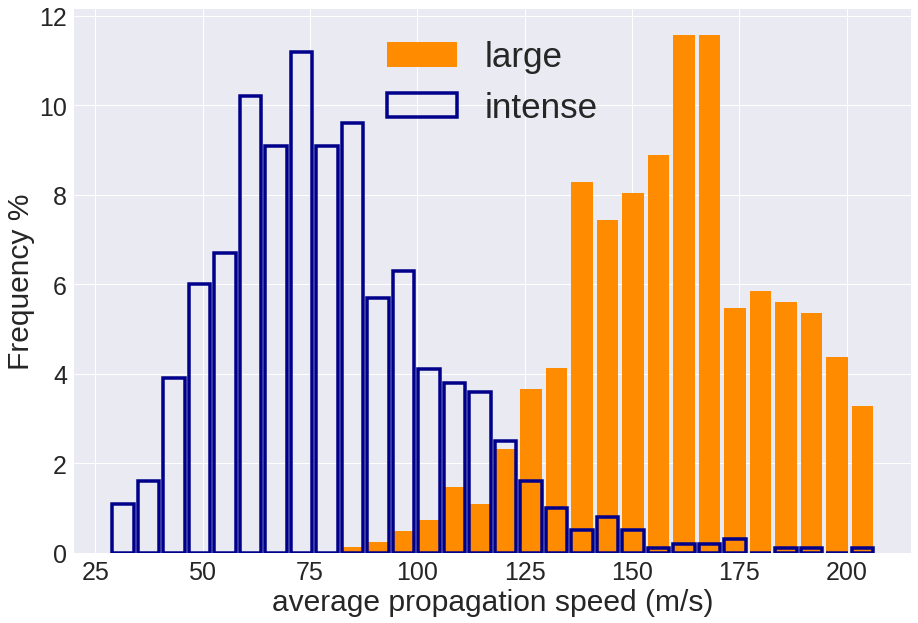

In [201]:
# Lifetimes of tracked features:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})



#plt.figure(figsize=(20, 17))
fig_lifetime, ax_lifetime= plt.subplots(figsize= (15,10))


xaxis = edges[:-1]


plt.bar(xaxis, hist/np.nansum(hist)*100, width= 5,color='darkorange', label= 'large')
plt.bar(xaxis, hist_cnrr/np.nansum(hist_cnrr)*100, width= 5, edgecolor='darkblue', color= 'None', linewidth= 3.5, label= 'intense' )

ax_lifetime.set_xlabel('average propagation speed (m/s)', fontsize= 30)
ax_lifetime.set_ylabel('Frequency %', fontsize = 30)
plt.legend(fontsize= 35)



# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/cnrr_large_vs_intense1000_meaneqr.png')

In [507]:
print (np.median(cells.total_precip.values), np.median(cells_cnrr.total_precip.values), np.median(cells_era.total_precip.values*2))

8009.518128395081 5395.956809997559 2283.558378061998


## Thresholds

In [39]:
# import tracks for CNRR 
savedir='/media/juli/Data/third_pole/mcs_tracking/CNRR/Save'
file = savedir + '/Tracks_CNRR_2006-2016_storms.h5'
Tracks_cnrr = pd.read_hdf(file, 'table')
Tracks_cnrr['timestr']=pd.to_datetime(Tracks_cnrr['timestr'],format='%Y-%m-%d %H:%M:%S')

In [40]:
# import tracks for GPM 
savedir='/media/juli/Data/third_pole/satellite_data/gpm_v06/Save'
file = savedir + '/Tracks_GPM_2006_2016_storms_tpflag.h5'
Tracks_gpm = pd.read_hdf(file, 'table')
Tracks_gpm['timestr']=pd.to_datetime(Tracks_gpm['timestr'],format='%Y-%m-%d %H:%M:%S')

In [102]:
t= [1,2,3,4,5,7,10,15]
t= np.array(t)

In [103]:
gpm= np.array(())
for t in np.unique(Tracks_gpm.threshold_value):
    gpm = np.append(gpm, np.shape(Tracks_gpm[Tracks_gpm.threshold_value == t])[0] / np.shape(Tracks_gpm)[0]*100)

In [104]:
cnrr= np.array(())
for t in np.unique(Tracks_cnrr.threshold_value):
    cnrr = np.append(cnrr, np.shape(Tracks_cnrr[Tracks_cnrr.threshold_value == t])[0] / np.shape(Tracks_cnrr)[0]*100)

In [108]:
Tracks =Tracks_era

In [109]:
era= np.array(())
for t in np.unique(Tracks.threshold_value):
    era = np.append(era, np.shape(Tracks[Tracks.threshold_value == t])[0] / np.shape(Tracks)[0]*100)

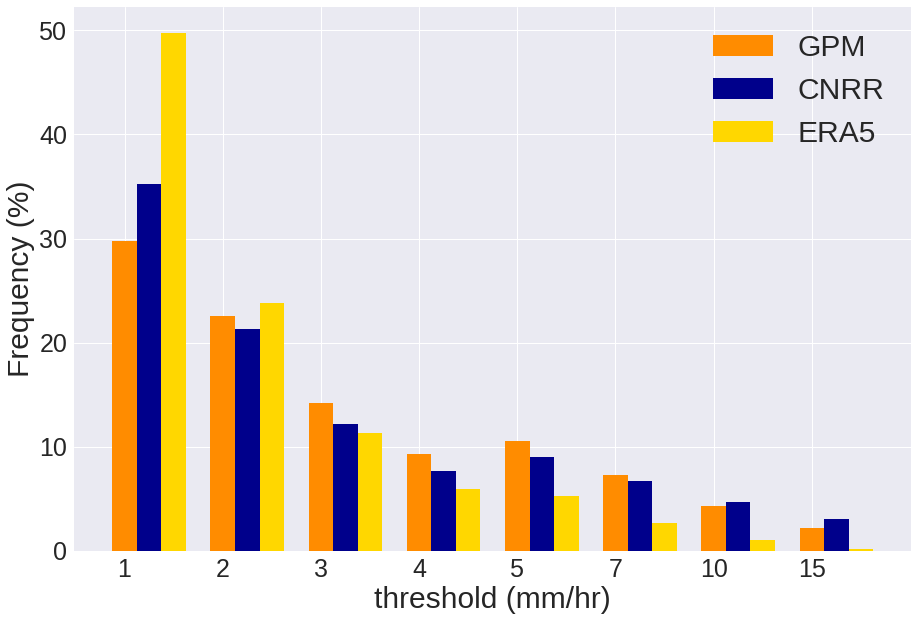

In [110]:
# Lifetimes of tracked features:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

#plt.figure(figsize=(20, 17))
fig_lifetime, ax_lifetime= plt.subplots(figsize= (15,10))

xaxis = np.arange(8)

plt.bar(xaxis + 0.00, gpm, width=0.25, color='darkorange', label='GPM')
plt.bar(xaxis + 0.25, cnrr, width = 0.25, color='darkblue',  label= 'CNRR')
plt.bar(xaxis + 0.50, era, width = 0.25, color='gold',  label= 'ERA5')

ax_lifetime.set_xlabel('threshold (mm/hr)', fontsize= 30)
ax_lifetime.set_ylabel('Frequency (%)', fontsize = 30)
labels = ['1', '2', '3', '4', '5', '7', '10', '15']
plt.xticks(xaxis, labels)
plt.legend(fontsize= 30)

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/threshold_freq_CNRR_GPM_ERA_20062016.png')

# Multiple regression for total precip

## standardization

In [769]:
cell= cells_gpm
dx= 14136.0/1000

In [775]:
cell= cells_era
dx= 40000.0

In [772]:
cell= cells_cnrr
dx= 18000.0/1000


In [776]:

y= cell.total_precip.values - np.nanmean(cell.total_precip.values) / np.nanstd(cell.total_precip.values)
pixels= cell.mean_area.values / (dx*dx)
x1= (pixels- np.nanmean(pixels)) / np.nanstd(pixels)
x2= (cell.mean_rr.values- np.nanmean(cell.mean_rr.values)) / np.nanstd(cell.mean_rr.values)
x3= (cell.max_rr.values- np.nanmean(cell.max_rr.values)) / np.nanstd(cell.max_rr.values)
x4= (cell.lifetime.values- np.nanmean(cell.lifetime.values)) / np.nanstd(cell.lifetime.values)


In [785]:
y= cell.total_precip.values
x2= cell.mean_rr.values -np.nanmean( cell.mean_rr.values)
x3= cell.max_rr.values - np.nanmean( cell.max_rr.values)
x4= cell.lifetime.values - np.nanmean( cell.lifetime.values)


In [786]:
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats.mstats import zscore

print(sm.OLS(zscore(y), zscore(x1)).fit().summary())
print(sm.OLS(zscore(y), zscore(x2)).fit().summary())
print(sm.OLS(zscore(y), zscore(x3)).fit().summary())
print(sm.OLS(zscore(y), zscore(x4)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.418
Model:                            OLS   Adj. R-squared (uncentered):              0.418
Method:                 Least Squares   F-statistic:                              1435.
Date:                Sun, 01 Sep 2019   Prob (F-statistic):                   3.88e-237
Time:                        17:09:16   Log-Likelihood:                         -2296.8
No. Observations:                2000   AIC:                                      4596.
Df Residuals:                    1999   BIC:                                      4601.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##  Plot track densities 

In [48]:
# read in empty CNRR grid 

cnrr = '/media/juli/Data/third_pole/CNRR/data/summermean_2006_2016.nc4'
ds = Dataset(cnrr)
lat= np.array(ds['LAT'])
lon = np.array(ds['LON'])

In [49]:
# import tracks for CNRR 
savedir='/media/juli/Data/third_pole/mcs_tracking/CNRR/Save'
file = savedir + '/Tracks_CNRR_2006-2016_storms.h5'
Tracks = pd.read_hdf(file, 'table')

In [8]:
# subset trackdataframe cnrr_tracks, based on cnrr_intense/cnrr_large and extract only lats and lons 

i = 0 
for c in cnrr_intense.id.values:
    print(c)
    if i == 0:
        df= Tracks.loc[Tracks.cell == c ]
        i+=1 
    else:
        df= df.append(Tracks.loc[Tracks.cell == c ])



NameError: name 'cnrr_intense' is not defined

In [11]:
import xarray as xr
count= np.zeros((141,201))
data = xr.DataArray(count)
data.to_netcdf(path= '/media/juli/Data/third_pole/CNRR/data/density_matrix.nc')

In [22]:
def geo_idx(in_coord, coord_arr):
    geo_idx = (np.abs(coord_arr - in_coord)).argmin()
    return geo_idx

In [23]:
in_lat = track_lats[0]
in_lon = track_lons[0]
lat_idx = geo_idx(in_lat, lat.flatten())
lon_idx = geo_idx(in_lon, lon.flatten())
print(in_lat, lat_idx, in_lon, lon_idx)

20.716601603410062 48 74.84557075310028 6242


In [35]:
a= np.unique(cnrr_intense.init_time.values)
a

array(['2006-01-16 07:00:00', '2006-01-17 00:00:00',
       '2006-01-30 12:00:00', '2006-02-25 07:00:00',
       '2006-05-11 16:00:00', '2006-05-12 15:00:00',
       '2006-05-26 16:00:00', '2006-05-30 07:00:00',
       '2006-05-30 19:00:00', '2006-06-03 22:00:00',
       '2006-06-04 01:00:00', '2006-06-04 21:00:00',
       '2006-06-05 14:00:00', '2006-06-08 15:00:00',
       '2006-06-12 07:00:00', '2006-06-12 15:00:00',
       '2006-06-13 14:00:00', '2006-06-22 19:00:00',
       '2006-06-25 13:00:00', '2006-06-29 18:00:00',
       '2006-06-30 19:00:00', '2006-07-02 19:00:00',
       '2006-07-04 22:00:00', '2006-07-05 10:00:00',
       '2006-07-05 18:00:00', '2006-07-06 15:00:00',
       '2006-07-06 21:00:00', '2006-07-07 19:00:00',
       '2006-07-08 11:00:00', '2006-07-09 13:00:00',
       '2006-07-13 20:00:00', '2006-07-26 21:00:00',
       '2006-07-29 09:00:00', '2006-07-30 05:00:00',
       '2006-07-30 14:00:00', '2006-07-31 13:00:00',
       '2006-07-31 20:00:00', '2006-08-03 13:0

In [34]:
np.sum(count[count > 0] )

94957.0

In [58]:
np.mean(cnrr_intense.max_rr.values)

96.4943217740059

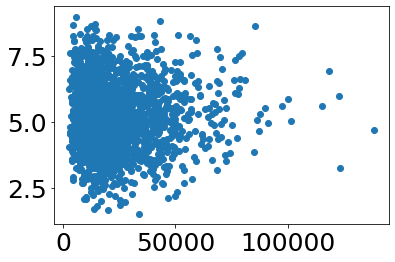

In [55]:
plt.scatter(cnrr_intense.max_area, cnrr_intense.v) 

In [50]:
cnrr_intense[cnrr_intense.id ==  367104.0]

,id,init_time,total_precip,mean_rr,max_rr,lifetime,v,max_area,mean_area,total_area,features>5mm
42564,367104,2013-07-25 05:00:00,34588.455662,5.782097,128.841248,35.0,3.839615,29865.497159,365282.834688,1.045292e+06,32.0


In [51]:
df= Tracks

In [52]:
# loop through grid cells and compare lat and lon table 

track_lats= df.latitude.values
track_lons= df.longitude.values
count= np.zeros((141,201))

for idx,row in enumerate(count):
    for coli, v in enumerate(row):
        lat1 = lat[idx, coli]
        lon1 = lon[idx, coli]
        
        lat2= lat1 + 0.3
        lon2= lon1 + 0.3 
        
        for i, x in enumerate(track_lats):
            y = track_lons[i]
            if x >= lat1 and x < lat2 and y >= lon1 and y < lon2:
                count[idx, coli] +=1 
    print('density matrix updated.', np.shape(count[count > 0]) ) 
        
        
data = xr.DataArray(count)
data.to_netcdf(path= '/media/juli/Data/third_pole/CNRR/data/density_matrix_cnrrall.nc')
print('netcdf file saved')




density matrix updated. (200,)
density matrix updated. (400,)
density matrix updated. (600,)
density matrix updated. (800,)
density matrix updated. (1000,)
density matrix updated. (1200,)
density matrix updated. (1400,)
density matrix updated. (1600,)
density matrix updated. (1800,)
density matrix updated. (1999,)
density matrix updated. (2199,)
density matrix updated. (2399,)
density matrix updated. (2599,)
density matrix updated. (2799,)
density matrix updated. (2999,)
density matrix updated. (3199,)
density matrix updated. (3399,)
density matrix updated. (3599,)
density matrix updated. (3799,)
density matrix updated. (3999,)
density matrix updated. (4199,)
density matrix updated. (4399,)
density matrix updated. (4599,)
density matrix updated. (4799,)
density matrix updated. (4999,)
density matrix updated. (5199,)
density matrix updated. (5399,)
density matrix updated. (5599,)
density matrix updated. (5799,)
density matrix updated. (5999,)
density matrix updated. (6199,)
density matr

NameError: name 'xr' is not defined

In [44]:
    

data = xr.DataArray(count)
data.to_netcdf(path= '/media/juli/Data/third_pole/CNRR/data/density_matrix.nc')
print('netcdf file saved')

netcdf file saved


In [55]:
import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors

In [56]:
count[count> 0 ].shape

(24735,)

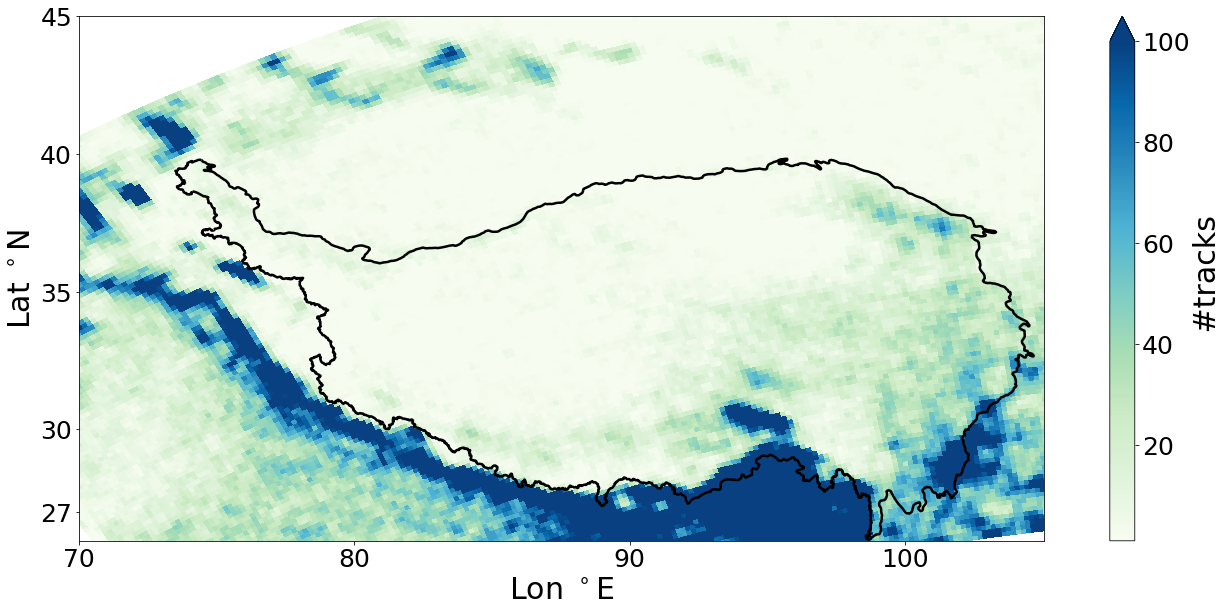

In [65]:
# plot densities with pcolormesh


plt.figure(figsize=(20, 9))


cmap = plt.cm.get_cmap('viridis_r')

m = Basemap(projection='cyl', llcrnrlat=25.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')

xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, count, cmap='GnBu', vmin= 1, vmax = 100 )
cmap.set_under(color='white')

xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$E',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' #tracks', fontsize= 30)


plt.rcParams.update({'font.size': 25})
plt.tight_layout()


plt.savefig('/media/juli/Elements/comparison/cnrr_trackdensity.png')


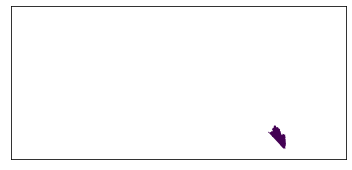

In [61]:
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import numpy
import shapefile


fig = plt.figure()
ax = fig.add_subplot(111)

file='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
sf = shapefile.Reader(file)
for shape_rec in sf.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = Path(vertices, codes)
    clip = PathPatch(clip, transform=ax.transData)
    

# raster 
m = Basemap(projection='cyl', llcrnrlat=25.0,urcrnrlat=41.0, llcrnrlon=70.0, urcrnrlon=105,  resolution = 'c')

xi,yi = m(lon,lat)
cs = m.contourf(xi,yi, count, cmap=cmap, vmin= 1 ,vmax= 10)

# clip 
for contour in cs.collections:
        contour.set_clip_path(clip)